# Imports

In [ ]:
# install PyArabic library for Arabic preprocessing
!pip install PyArabic

     |████████████████████████████████| 126 kB 4.3 MB/s 


In [ ]:
# install tensorflow_addons for AdamW optimizer
!pip install tensorflow_addons

     |████████████████████████████████| 1.1 MB 4.3 MB/s 


In [ ]:
# Standard libraries imports
import io
import re
import ast
import math
import requests
import numpy as np
import pandas as pd
from tqdm import tqdm
from lxml import etree
import pyarabic.araby as araby

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers

In [ ]:
# read the competition training dataset
train_df = pd.read_csv('https://raw.githubusercontent.com/sigmorphon/2022InflectionST/main/part2/ara_1000.train', sep='\t', header=None)
# take only the first and second columns which
# contain the sigular and plural forms
train_df = train_df.iloc[:, :2]
# rename the columns
train_df.columns = ['singular', 'plural']
# remove the Arabic diacritics from each column
for col in train_df.columns:
  train_df[col] = train_df[col].apply(lambda x: araby.strip_diacritics(x))

# fetch the top 10 rows
train_df.head(10)

,singular,plural
0,ساحة,ساحات
1,أمر,أمور
2,أمة,أمم
3,جلسة,جلسات
4,ٱتهام,اتهامات
5,وزارة,وزارات
6,ملفة,ملفات
7,مسؤول,مسؤولين
8,خط,خطوط
9,ولاية,ولايات


In [ ]:
# read the competition validation dataset
valid_df = pd.read_csv('https://raw.githubusercontent.com/sigmorphon/2022InflectionST/main/part2/ara.dev', sep='\t', header=None)
# take only the first and second columns which
# contain the sigular and plural forms
valid_df = valid_df.iloc[:, :2]
# rename the columns
valid_df.columns = ['singular', 'plural']
# remove the Arabic diacritics from each column
for col in valid_df.columns:
  valid_df[col] = valid_df[col].apply(lambda x: araby.strip_diacritics(x))

# fetch the top 10 rows
valid_df.head(10)

,singular,plural
0,تهمة,تهم
1,مانع,موانع
2,بعد,أبعاد
3,توظيف,توظيفات
4,خطر,أخطار
5,مسلك,مسالك
6,متحالف,متحالفين
7,فار,فارين
8,بحث,أبحاث
9,نزاع,نزاعات


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


# Hardware Detection

In [ ]:
# Detect hardware
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
    tpu = None
    gpus = tf.config.experimental.list_logical_devices("GPU")
    
# Select an appropriate distribution strategy
if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu) # Going back and forth between TPU and host is expensive. Better to run 128 batches on the TPU before reporting back.
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])  
elif len(gpus) > 1:
    strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
    print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
    strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
    print('Running on single GPU ', gpus[0].name)
else:
    strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
    print('Running on CPU')
print("Number of accelerators: ", strategy.num_replicas_in_sync)

Running on single GPU  /device:GPU:0
Number of accelerators:  1


# Configs

In [ ]:
class config:

  MAXLEN = 17 # maximum length of sequence

  # model configs
  BATCH_SIZE_PER_REPLICA = 256 # batch size per replica
  BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync # global batch size
  EPOCHS = 100 # number of epochs
  LEARNING_RATE = 1E-4 # learning rate
  LEARTING_RATE_REDUCTION_PATIENCE = 10 # number of epochs to weight before lowering LR
  LEARTING_RATE_REDUCTION_FACTOR = 0.2 # LR lowering factor
  BUFFER = 1024 # buffer size for shuffling the training set
  EMBEDDING_SIZE = 256 # embedding size
  NUM_HEADS = 8 # number of heads
  NUM_BLOCKS = 4 # number of encoder blocks
  KEY_DIM = 64 # dimesion of the key, value, and query
  DROPOUT = 0.0 # dopout rate
  SKIP_RATIO = 0.0 # skip connection ratio

# Dataset

In [ ]:
# list of all Arabic characters
chars = list('اٱبتةثجحخدذرزسشصضطظعغفقكلمنهويءآأؤإئىی')
print('Number of Arabic Characters:', len(chars))

# character to index dictionary
char_to_index = dict((char, index+3) for (index, char) in enumerate(chars))
# index to character dictionary
index_to_char=  dict((index+3, char) for (index, char) in enumerate(chars))

char_to_index['p'] = 0 # pad
char_to_index['s'] = 1 # separator
char_to_index['_'] = 2 # mask


index_to_char[0] = 'p' # pad
index_to_char[1] = 's' # separator
index_to_char[2] = '_' # mask

# additional char_to_index and index_to_char extracted manually as shown in next 
# cells. They were extracted and then saved into a CSV file
df = pd.read_csv('https://drive.google.com/uc?export=download&id=1lQFU7XFy82-1dE5kPK7yDLpJ6tleycCC')
chars_2 = df['char'].values.tolist()
indexes_2 = df['value'].values.tolist()
del df

# additional character to index dictionary
char_to_index_2 = dict(zip(chars_2, indexes_2))
# additional index to character dictionary
index_to_char_2 = dict(zip(indexes_2, chars_2))

Number of Arabic Characters: 38


In [ ]:
# find maximum token length in both datasets
max_len = 0
# iterate over each column
for i in range(2):
  # iterate over each row
  for j in range(len(train_df)):
    if len(train_df.iloc[j, i]) > max_len:
      max_len = len(train_df.iloc[j, i])
print('Train Max Length:', max_len)

max_len = 0
# iterate over each column
for i in range(2):
  # iterate over each row
  for j in range(len(valid_df)):
    if len(valid_df.iloc[j, i]) > max_len:
      max_len = len(valid_df.iloc[j, i])
print('Valid Max Length:', max_len)

Train Max Length: 11
Valid Max Length: 11


In [ ]:
def text_to_index(lists):
    # construct a list that includes the character-based tokenized input words
    bert_indexed_inputs = []
    
    # iterate over texts
    for text in tqdm(lists):
      try:
        indexes = []
        indexes.append(char_to_index['s']) # special separator token
        temp_list = list(text)
        temp_list.reverse() # reverse list (Arabic from right to left)
        for char in temp_list:
          indexes.append(char_to_index[char]) # append index of each character to the list
        indexes.append(char_to_index['s']) # special separator token
        bert_indexed_inputs.append(indexes)
      except: # if the characters are not in the dictionary continue iterating
          continue
    return bert_indexed_inputs

In [ ]:
def text_to_index_labels(lists):
    # construct a list that includes the character-based tokenized input words
    bert_indexed_inputs = []
    
    for text in tqdm(lists):
      try:
        indexes = []
        indexes.append(char_to_index['s']) # special end token
        temp_list = list(text)
        temp_list.reverse() # reverse list (Arabic from right to left)
        for char in temp_list:
          indexes.append(char_to_index[char]) # append index of each character to the list
        bert_indexed_inputs.append(indexes)
      except: # if the characters are not in the dictionary continue iterating
          continue
    return bert_indexed_inputs

In [ ]:
# convert text to indexes (encoder part)
enc_indexed_text_train = text_to_index(train_df.iloc[:, 0].tolist())
enc_indexed_text_valid = text_to_index(valid_df.iloc[:, 0].tolist())
# pad sequences
enc_indexed_text_train = tf.keras.preprocessing.sequence.pad_sequences(enc_indexed_text_train, maxlen=config.MAXLEN, padding='pre')
enc_indexed_text_valid = tf.keras.preprocessing.sequence.pad_sequences(enc_indexed_text_valid, maxlen=config.MAXLEN, padding='pre')

# convert text to indexes (decoder part)
dec_indexed_text_train = text_to_index(train_df.iloc[:, 1].tolist())
dec_indexed_text_valid = text_to_index(valid_df.iloc[:, 1].tolist())
# labels for decoder (no start token)
dec_indexed_text_train_labels = text_to_index_labels(train_df.iloc[:, 1].tolist())
dec_indexed_text_valid_labels = text_to_index_labels(valid_df.iloc[:, 1].tolist())
# pad sequences
dec_indexed_text_train = tf.keras.preprocessing.sequence.pad_sequences(dec_indexed_text_train, maxlen=config.MAXLEN, padding='pre')
dec_indexed_text_valid = tf.keras.preprocessing.sequence.pad_sequences(dec_indexed_text_valid, maxlen=config.MAXLEN, padding='pre')
# pad labels
dec_indexed_text_train_labels = tf.keras.preprocessing.sequence.pad_sequences(dec_indexed_text_train_labels, maxlen=config.MAXLEN, padding='pre')
dec_indexed_text_valid_labels = tf.keras.preprocessing.sequence.pad_sequences(dec_indexed_text_valid_labels, maxlen=config.MAXLEN, padding='pre')

100%|██████████| 343/343 [00:00<00:00, 350376.59it/s]


In [ ]:
# create a TensorFlow training dataset that performs multiple functions including
# shuffling, batching, and prefetching
train_ds = tf.data.Dataset.from_tensor_slices((tf.constant(enc_indexed_text_train), tf.constant(dec_indexed_text_train), tf.constant(dec_indexed_text_train_labels)))
train_ds = train_ds.shuffle(config.BUFFER).batch(config.BATCH_SIZE, drop_remainder=False).prefetch(-1).cache()

# create a TensorFlow validation dataset that performs multiple functions including
# batching and prefetching
valid_ds = tf.data.Dataset.from_tensor_slices((tf.constant(enc_indexed_text_valid), tf.constant(dec_indexed_text_valid), tf.constant(dec_indexed_text_valid_labels)))
valid_ds = valid_ds.batch(config.BATCH_SIZE, drop_remainder=False).prefetch(-1).cache()

# Models

## Pre-trained CBERT

Use the TensorFlow functional API to develop the CBERT model.

In [ ]:
def encoder_block(inputs, num_heads=8, key_dim=64, dropout=0.0, linear_shape=128):
  # multi-head attention layer
  x = layers.MultiHeadAttention(num_heads=num_heads,
                                  key_dim=key_dim,
                                  dropout=dropout)(inputs, inputs)
  # add & norm
  x = layers.Add()([inputs, x])
  x1 = layers.LayerNormalization()(x)
  # feed-forward
  x = layers.Dense(linear_shape, activation='gelu')(x1)
  x2 = layers.Dense(inputs.shape[-1], activation='linear')(x)
  # add & norm
  x = layers.Add()([x1, x2])
  x = layers.LayerNormalization()(x)
  return x

In [ ]:
with strategy.scope():
  # embedding layer that maps each input character index into a vector of the specified length
  # in the config class
  embedding_layer = layers.Embedding(input_dim=len(chars)+3, output_dim=config.EMBEDDING_SIZE, input_length=config.MAXLEN, mask_zero=True)
  # use another trainable embedding layer to learn positional encoding 
  pos_encoding = layers.Embedding(input_dim=config.MAXLEN+1, output_dim=config.EMBEDDING_SIZE, input_length=config.MAXLEN, mask_zero=False)

In [ ]:
def encoder_model(inputs, num_blocks=4, num_heads=8, key_dim=64, dropout=0.0, skip_ratio=0.0):

  # embedding layer for characters
  embed = embedding_layer(inputs)
  # trainable positional encoding
  pos_encod = pos_encoding(tf.range(config.MAXLEN))
  # add pos_encod to embeddings
  encoded_embed = embed + pos_encod
  # multi-head attention
  mha = encoder_block(encoded_embed, num_heads=num_heads, key_dim=key_dim, dropout=dropout)
  mha = skip_ratio * encoded_embed + (1 - skip_ratio) * mha # skip connection to preserve signal
  # repeated blocks
  block_outputs = dict()
  for i in range(1, num_blocks):
    x = mha
    block_outputs[f'x{i}'] = x
    mha = encoder_block(encoded_embed, num_heads=num_heads, key_dim=key_dim, dropout=dropout, linear_shape=128)
    mha = skip_ratio * x + (1 - skip_ratio) * mha # skip connection to preserve signal
  block_outputs[f'x{i+1}'] = mha
  return block_outputs

In [ ]:
def final_model():
  # the full CBERT model
  inputs = layers.Input(shape=(config.MAXLEN,), name='cbert_input')
  bert_output = encoder_model(inputs, num_blocks=config.NUM_BLOCKS, 
                              num_heads=config.NUM_HEADS, key_dim=config.KEY_DIM,
                              dropout=config.DROPOUT, skip_ratio=config.SKIP_RATIO)
  final_encoder_name = [*bert_output][-1]
  dense = layers.Dense(len(chars)+3, activation='softmax')(bert_output[final_encoder_name])

  model = tf.keras.Model(inputs=inputs, outputs=dense)
  return model

In [ ]:
# instantiate the model
cbert = final_model()
# load the pre-trained weights
url = 'https://drive.google.com/uc?export=download&id=1Qus-FZGOscfRDqCyKW2bftCT5tVOLZhK'
r = requests.get(url, allow_redirects=True)
open('best_pre_trained_weights.h5', 'wb').write(r.content)
cbert.load_weights('/content/best_pre_trained_weights.h5')

# define the input as the original CBERT input, and take the contextualized embeddings
# from the layer before the head
pretrained_encoder = tf.keras.Model(inputs=cbert.input, outputs=cbert.layers[-2].output)
# freeze the model weights during fine-tuning
pretrained_encoder.trainable = False

## Full Model

In [ ]:
def main_encoder_block(inputs, cbert_output, num_heads=8, key_dim=64, dropout=0.0, linear_shape=128):
  # multi-head self-attention layer
  self_att = layers.MultiHeadAttention(num_heads=num_heads,
                                       key_dim=key_dim, 
                                       dropout=dropout)(inputs, inputs)
  # CBERT-Encoder attention
  cbert_enc_att = layers.MultiHeadAttention(num_heads=num_heads,
                                            key_dim=key_dim,
                                            dropout=dropout)(query=inputs, value=cbert_output, key=cbert_output)
  
  # Drop Net (mean of both MHA layers)
  drop_net = tf.math.reduce_mean([self_att, cbert_enc_att], axis=0)
  # add & norm
  add = layers.Add(name='encoder_add')([inputs, drop_net])
  norm = layers.LayerNormalization()(add)

  # feed-forward network
  ff = layers.Dense(linear_shape, activation='gelu')(norm)
  ff = layers.Dense(inputs.shape[-1], activation='linear')(ff)
  
  # add & norm
  add = layers.Add()([norm, ff])
  norm = layers.LayerNormalization()(add)
  return norm

In [ ]:
def cbert_encoder_model(inputs, cbert_output):
  # embed input sequences
  embed = embedding_layer(inputs)
  # trainable positional encoding
  pos_encod = pos_encoding(tf.range(config.MAXLEN))
  # add pos_encod to embeddings
  embed = embed + pos_encod

  main_encoder_output = main_encoder_block(embed, cbert_output)

  return main_encoder_output

In [ ]:
def main_decoder_block(inputs, cbert_output, main_encoder_output, 
                       attention_mask, num_heads=8, key_dim=64, 
                       dropout=0.0, linear_shape=128):
  # multi-head masked self-attention layer
  self_att = layers.MultiHeadAttention(num_heads=num_heads,
                                       key_dim=key_dim, 
                                       dropout=dropout)(inputs, inputs, attention_mask=attention_mask)
  # feed-forward network
  ff = layers.Dense(linear_shape, activation='gelu')(self_att)
  ff = layers.Dense(inputs.shape[-1], activation='linear')(ff)
  # add & norm
  add = layers.Add()([self_att, ff])
  self_att_output = layers.LayerNormalization()(add)
  
  # CBERT-Decoder attention
  cbert_dec_att = layers.MultiHeadAttention(num_heads=num_heads,
                                            key_dim=key_dim,
                                            dropout=dropout)(query=self_att_output, 
                                                             value=cbert_output, 
                                                             key=cbert_output)
  # Encoder-Decoder Attention
  enc_dec_att = layers.MultiHeadAttention(num_heads=num_heads,
                                          key_dim=key_dim,
                                          dropout=dropout)(query=self_att_output, value=main_encoder_output, key=main_encoder_output)                                      

  # Drop Net (mean of both MHA layers)
  drop_net = tf.math.reduce_mean([cbert_dec_att, enc_dec_att], axis=0)
  # add & norm
  add = layers.Add()([self_att_output, drop_net])
  norm = layers.LayerNormalization()(add)
 
  # feed-forward network
  ff = layers.Dense(linear_shape, activation='gelu')(norm)
  ff = layers.Dense(inputs.shape[-1], activation='linear')(ff)
  
  # add & norm
  add = layers.Add()([norm, ff])
  norm = layers.LayerNormalization()(add)
  return norm

In [ ]:
def cbert_decoder_model(inputs, cbert_output, main_encoder_output, attention_mask):
  # embed input sequences
  embed = embedding_layer(inputs)
  # trainable positional encoding
  pos_encod = pos_encoding(tf.range(config.MAXLEN))
  # add pos_encod to embeddings
  embed = embed + pos_encod

  main_decoder_output = main_decoder_block(embed, cbert_output, main_encoder_output, attention_mask)

  return main_decoder_output

In [ ]:
def final_decoder_output(enc_inputs, dec_inputs, attention_mask):

  cbert_output = pretrained_encoder(enc_inputs)
  x = cbert_encoder_model(enc_inputs, cbert_output)
  x = cbert_decoder_model(dec_inputs, cbert_output, x, attention_mask)
  x = layers.GlobalAveragePooling1D()(x)
  main_dec_output = layers.Dense(len(chars)+3, activation='softmax')(x)
  return main_dec_output

In [ ]:
def encoder_decoder_model():
  # put it all together
  enc_inputs = layers.Input(shape=(config.MAXLEN,), name='enc_input')
  dec_inputs = layers.Input(shape=(config.MAXLEN,), name='dec_input')
  attention_mask = layers.Input(shape=(config.NUM_HEADS, config.MAXLEN, config.MAXLEN,), name='att_mask')

  main_dec_output = final_decoder_output(enc_inputs, dec_inputs, attention_mask)

  model = tf.keras.Model(inputs=[enc_inputs, dec_inputs, attention_mask], outputs=main_dec_output)
  return model

In [ ]:
# clear the session to release all previous states generated by Keras
tf.keras.backend.clear_session()
# instantiate the model and print the summary
model = encoder_decoder_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 dec_input (InputLayer)         [(None, 17)]         0           []                               
                                                                                                  
 enc_input (InputLayer)         [(None, 17)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 17, 256)      10496       ['enc_input[0][0]',              
                                                                  'dec_input[0][0]']              
                                                                                                  
 model_1 (Functional)           (None, 17, 256)      2382592     ['enc_input[0][0]']          

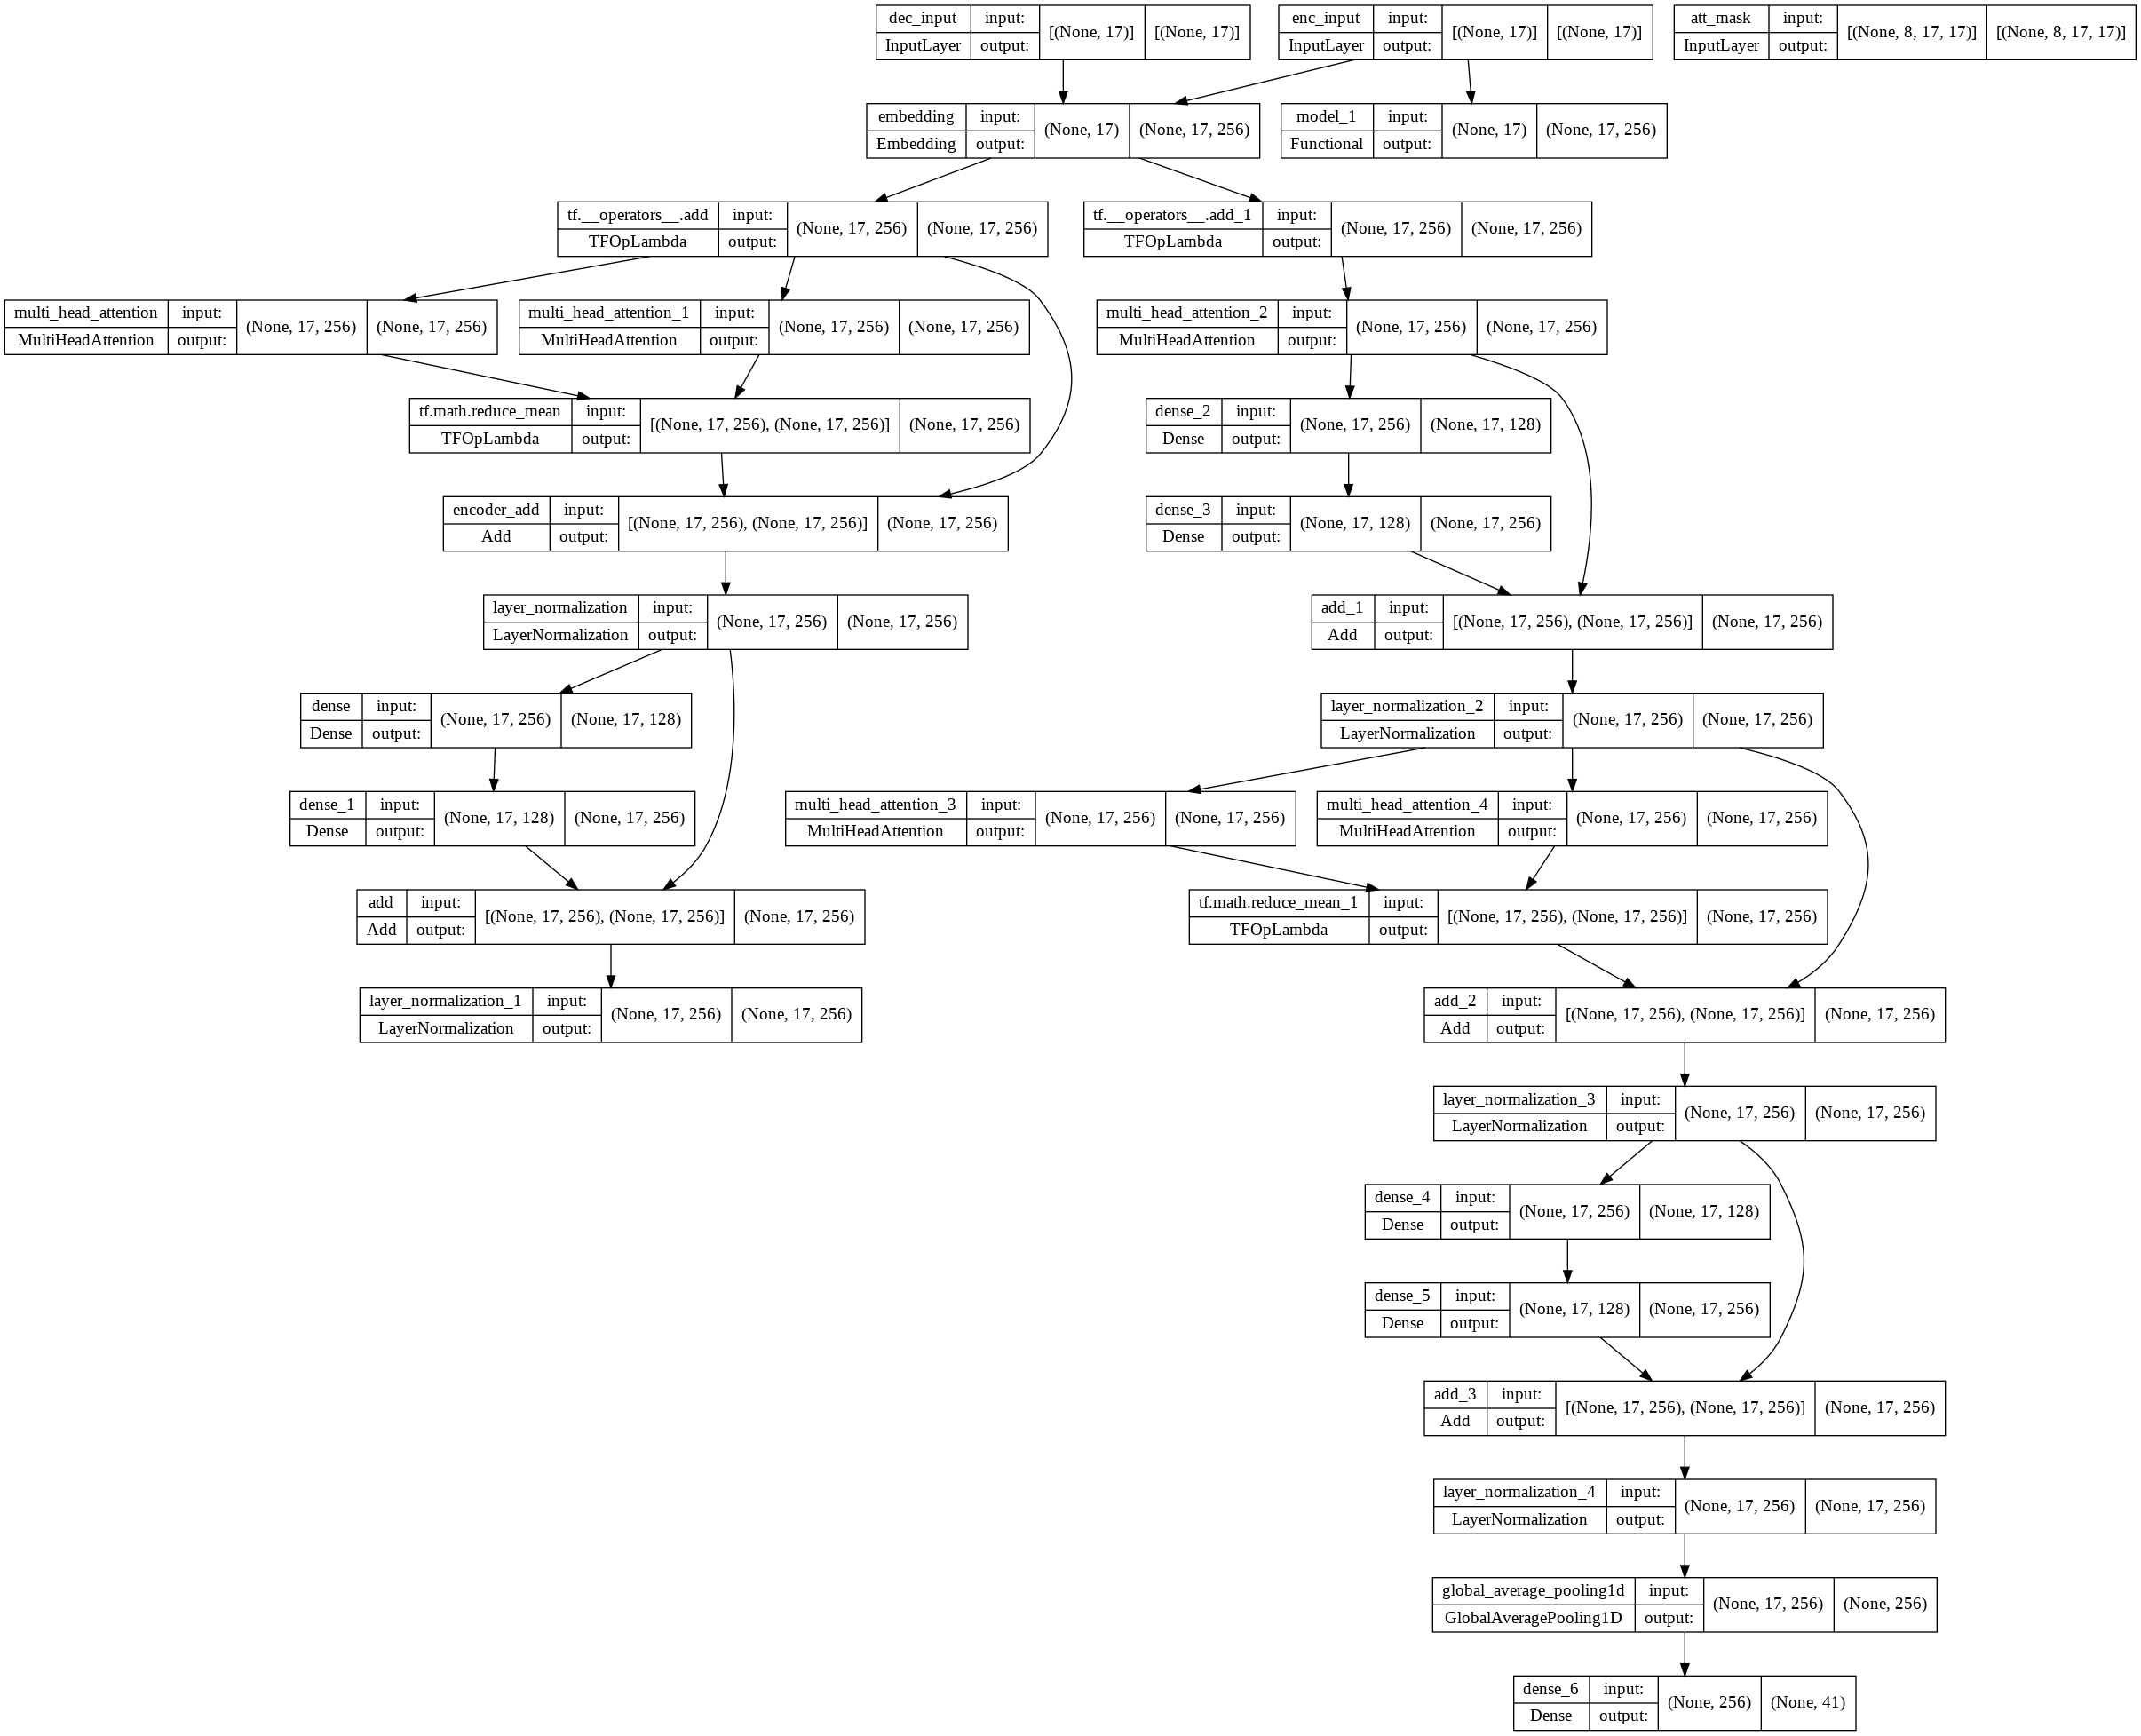

In [ ]:
# plot the model
tf.keras.utils.plot_model(model, show_layer_names=True, show_shapes=True)

# Custom Training

## GPU

In [ ]:
# construct attention masks list
# for each position there a mask that prevents the model from 
# see current and next positions
attention_masks = []
for i in range(1, config.MAXLEN+1):
  # Arabic masking starts from right to left
  attention_mask = [0] * (config.MAXLEN - i) + [1] * i
  attention_masks.append(attention_mask)

In [ ]:
# provide automatic class weights based on the inverse frequency 
# of each token, the more frequent, the less weight
total_num_labels = np.array(dec_indexed_text_train_labels).size
auto_weight_dict = dict()
for i in range(len(chars)+3):
  num_class_examples = (np.array(dec_indexed_text_train_labels) == i).sum()
  if num_class_examples != 0:
    auto_weight_dict[i] = total_num_labels / num_class_examples
  else:
    auto_weight_dict[i] = 0.1

auto_weight_dict[0] = 0.0 # give 'p' zero weight
auto_weight_dict

{0: 0.0,
 1: 17.0,
 2: 0.1,
 3: 15.992474129821261,
 4: 0.1,
 5: 95.50561797752809,
 6: 26.27511591962906,
 7: 459.4594594594595,
 8: 739.1304347826087,
 9: 184.7826086956522,
 10: 141.66666666666666,
 11: 354.1666666666667,
 12: 103.03030303030303,
 13: 1000.0,
 14: 54.83870967741935,
 15: 377.77777777777777,
 16: 112.58278145695364,
 17: 250.0,
 18: 204.81927710843374,
 19: 404.76190476190476,
 20: 204.81927710843374,
 21: 1133.3333333333333,
 22: 97.70114942528735,
 23: 653.8461538461538,
 24: 134.9206349206349,
 25: 107.59493670886076,
 26: 215.18987341772151,
 27: 76.57657657657657,
 28: 41.16222760290557,
 29: 50.89820359281437,
 30: 229.72972972972974,
 31: 66.40625,
 32: 41.46341463414634,
 33: 447.36842105263156,
 34: 1214.2857142857142,
 35: 118.88111888111888,
 36: 1416.6666666666667,
 37: 500.0,
 38: 340.0,
 39: 2125.0,
 40: 0.1}

In [ ]:
# clear the session to release all previous states generated by Keras
tf.keras.backend.clear_session()
# instantiate and compile the model inside the strategy scope defined previous
with strategy.scope():
  model = encoder_decoder_model()
  # use Sparse Categorical Cross-entropy as a loss function as labels are not one-hot encoded
  # use AdamW optimizer initially with a weight decay of 0.0
  # use the Sparse Categorical Accuracy metric to monitor and save the best model weights
  model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=tf.keras.metrics.SparseCategoricalAccuracy(),
                optimizer=tfa.optimizers.AdamW(learning_rate=config.LEARNING_RATE, weight_decay=0.0))

# initialize the best accuracy at - infinity
best_result = -np.inf

# for each epoch iterate over the whole training and validation sets
for epoch in range(config.EPOCHS):
  print(f'Epoch: {epoch+1}/{config.EPOCHS}')
  # iterate over the training dataset
  for batch in tqdm(train_ds, total=len(train_ds)):
    enc_inputs, dec_inputs, labels = batch
    # create a variable for the number of examples in the current batch
    num_examples = len(enc_inputs)
    
    # initialize losses and accuracies list
    losses = []
    accs = []
    # sequencially predict the label (actual previous tokens as input)
    for i in range(config.MAXLEN):
      # extract the current mask from the attention_masks list
      # broadcast the mask to the shape of (num_examples, num_heads(8), max_len(17), max_len(17))
      current_att_mask = tf.broadcast_to(tf.constant(attention_masks[i]), (num_examples, config.NUM_HEADS, config.MAXLEN, config.MAXLEN))
      # train on each batch and pass the class weights
      train_results = model.train_on_batch(x=(enc_inputs, dec_inputs, current_att_mask), y=labels[:, -(i+1)], 
                           class_weight=auto_weight_dict, reset_metrics=True, return_dict=True)
      # append the loss value
      losses.append(train_results['loss'])
      # append the accuracy value
      accs.append(train_results['sparse_categorical_accuracy'])
    
  print('Train loss:', np.mean(losses), 'Train accuracy', np.mean(accs))
  
  # initialize losses and accuracies list
  losses = []
  accs = []
  # iterate over the validation dataset
  for batch in tqdm(valid_ds, total=len(valid_ds)):
    enc_inputs, dec_inputs, labels = batch
    # create a variable for the number of examples in the current batch
    num_examples = len(enc_inputs)
    # create a NumPy array to save the predictions of the previous tokens
    # it is initialized with ones where the model will see 1 in the first 
    # pass which represents the special starting "s" token
    full_sequence_preds = np.ones((num_examples, config.MAXLEN))
    # sequencially predict the label (predicted previous tokens as input (Auto-Regression))
    for i in range(config.MAXLEN):
      # extract the current mask from the attention_masks list
      # broadcast the mask to the shape of (num_examples, num_heads(8), max_len(17), max_len(17))
      current_att_mask = tf.broadcast_to(tf.constant(attention_masks[i]), (num_examples, config.NUM_HEADS, config.MAXLEN, config.MAXLEN))
      # evaluate on each batch
      valid_results = model.test_on_batch(x=(enc_inputs, full_sequence_preds, current_att_mask), y=labels[:, -(i+1)], reset_metrics=True, return_dict=True)
      # predict the tokens of the current position
      preds = model.predict_on_batch(x=(enc_inputs, full_sequence_preds, current_att_mask))
      # take the argmax value which represents the index of the highest prob character
      current_preds = np.argmax(preds, axis=-1)
      # populate the current position with the predicted values which will be used in the next 
      # pass as a decoder input
      full_sequence_preds[:, -(i+1)] = current_preds # populate the column of the current timestep with the predicitons
        
      # append the loss value
      losses.append(valid_results['loss'])
      # append the accuracy value
      accs.append(valid_results['sparse_categorical_accuracy'])
  print('Valid loss:', np.mean(losses), 'Valid accuracy', np.mean(accs))
  mean_acc = np.mean(accs)
  # save the weights of the best model based on the validation accuracy
  if mean_acc > best_result:
    best_result = mean_acc
    print('Saving best model wieghts,', 'Accuracy:', mean_acc)
    model.save_weights('best_full_model_weights.h5')
  else:
    print("Accuracy didn't improve from:", best_result)

Epoch: 1/100


100%|██████████| 4/4 [00:23<00:00,  5.85s/it]


Train loss: 132.50373405042816 Train accuracy 0.022312373169423902


100%|██████████| 2/2 [00:10<00:00,  5.12s/it]


Valid loss: 5.071991177166209 Valid accuracy 0.04366865250117639
Saving best model wieghts, Accuracy: 0.04366865250117639
Epoch: 2/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 124.11348533104447 Train accuracy 0.04513184619410073


100%|██████████| 2/2 [00:05<00:00,  2.56s/it]


Valid loss: 5.753503203392029 Valid accuracy 0.015548407045357367
Accuracy didn't improve from: 0.04366865250117639
Epoch: 3/100


100%|██████████| 4/4 [00:12<00:00,  3.11s/it]


Train loss: 123.2015897806953 Train accuracy 0.05704868146601845


100%|██████████| 2/2 [00:10<00:00,  5.11s/it]


Valid loss: 6.967233475516824 Valid accuracy 0.02422059908070985
Accuracy didn't improve from: 0.04366865250117639
Epoch: 4/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 110.21146905159249 Train accuracy 0.08417849850786083


100%|██████████| 2/2 [00:04<00:00,  2.20s/it]


Valid loss: 6.799932283513686 Valid accuracy 0.029032760792795348
Accuracy didn't improve from: 0.04366865250117639
Epoch: 5/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 105.19082019609563 Train accuracy 0.07352941083338331


100%|██████████| 2/2 [00:05<00:00,  2.55s/it]


Valid loss: 5.919541239738464 Valid accuracy 0.08083217141821104
Saving best model wieghts, Accuracy: 0.08083217141821104
Epoch: 6/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 89.27429550535538 Train accuracy 0.06135902605841265


100%|██████████| 2/2 [00:04<00:00,  2.17s/it]


Valid loss: 6.468060100779814 Valid accuracy 0.09914453426266417
Saving best model wieghts, Accuracy: 0.09914453426266417
Epoch: 7/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 86.03536788067397 Train accuracy 0.1095334683161448


100%|██████████| 2/2 [00:04<00:00,  2.22s/it]


Valid loss: 6.55642897942487 Valid accuracy 0.0965350843308603
Accuracy didn't improve from: 0.09914453426266417
Epoch: 8/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 70.8563260493033 Train accuracy 0.11612575999735032


100%|██████████| 2/2 [00:04<00:00,  2.22s/it]


Valid loss: 6.3096438400885635 Valid accuracy 0.08459976129233837
Accuracy didn't improve from: 0.09914453426266417
Epoch: 9/100


100%|██████████| 4/4 [00:12<00:00,  3.03s/it]


Train loss: 54.44502216928146 Train accuracy 0.15618661221335917


100%|██████████| 2/2 [00:05<00:00,  2.56s/it]


Valid loss: 5.8467179396573234 Valid accuracy 0.10149779170751572
Saving best model wieghts, Accuracy: 0.10149779170751572
Epoch: 10/100


100%|██████████| 4/4 [00:12<00:00,  3.02s/it]


Train loss: 45.270295043640274 Train accuracy 0.1637931045911768


100%|██████████| 2/2 [00:04<00:00,  2.18s/it]


Valid loss: 6.181607390151305 Valid accuracy 0.15318231207921224
Saving best model wieghts, Accuracy: 0.15318231207921224
Epoch: 11/100


100%|██████████| 4/4 [00:12<00:00,  3.01s/it]


Train loss: 44.73206439438988 Train accuracy 0.1790060895111631


100%|██████████| 2/2 [00:04<00:00,  2.18s/it]


Valid loss: 5.306499758187463 Valid accuracy 0.15198059292400584
Accuracy didn't improve from: 0.15318231207921224
Epoch: 12/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 35.26643705280388 Train accuracy 0.1805273821193944


100%|██████████| 2/2 [00:05<00:00,  2.56s/it]


Valid loss: 5.913331249180962 Valid accuracy 0.17271884684177005
Saving best model wieghts, Accuracy: 0.17271884684177005
Epoch: 13/100


100%|██████████| 4/4 [00:12<00:00,  3.05s/it]


Train loss: 26.961485138710806 Train accuracy 0.21323529302197344


100%|██████████| 2/2 [00:04<00:00,  2.19s/it]


Valid loss: 5.58054819001871 Valid accuracy 0.199049715171842
Saving best model wieghts, Accuracy: 0.199049715171842
Epoch: 14/100


100%|██████████| 4/4 [00:12<00:00,  3.04s/it]


Train loss: 37.72881406457985 Train accuracy 0.18382352823391557


100%|██████████| 2/2 [00:04<00:00,  2.21s/it]


Valid loss: 6.115861796280917 Valid accuracy 0.17258414615164785
Accuracy didn't improve from: 0.199049715171842
Epoch: 15/100


100%|██████████| 4/4 [00:12<00:00,  3.01s/it]


Train loss: 31.330903226400125 Train accuracy 0.22489858131088755


100%|██████████| 2/2 [00:05<00:00,  2.56s/it]


Valid loss: 5.974753635771134 Valid accuracy 0.15683897518936327
Accuracy didn't improve from: 0.199049715171842
Epoch: 16/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 22.388827289728557 Train accuracy 0.25152129847008514


100%|██████████| 2/2 [00:05<00:00,  2.56s/it]


Valid loss: 5.653942677904578 Valid accuracy 0.19208502451724865
Accuracy didn't improve from: 0.199049715171842
Epoch: 17/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 29.593581217176773 Train accuracy 0.24974645104478388


100%|██████████| 2/2 [00:04<00:00,  2.10s/it]


Valid loss: 5.924884657649433 Valid accuracy 0.15878813768572667
Accuracy didn't improve from: 0.199049715171842
Epoch: 18/100


100%|██████████| 4/4 [00:11<00:00,  2.92s/it]


Train loss: 25.022476511404793 Train accuracy 0.22768762800842524


100%|██████████| 2/2 [00:04<00:00,  2.12s/it]


Valid loss: 5.698985145372503 Valid accuracy 0.2051058581427616
Saving best model wieghts, Accuracy: 0.2051058581427616
Epoch: 19/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 31.930176072260913 Train accuracy 0.18864097117501147


100%|██████████| 2/2 [00:04<00:00,  2.17s/it]


Valid loss: 5.583117826896555 Valid accuracy 0.14952301025828896
Accuracy didn't improve from: 0.2051058581427616
Epoch: 20/100


100%|██████████| 4/4 [00:11<00:00,  2.95s/it]


Train loss: 21.785197475377252 Train accuracy 0.2545638925341122


100%|██████████| 2/2 [00:05<00:00,  2.55s/it]


Valid loss: 5.680063486099243 Valid accuracy 0.18352772174950907
Accuracy didn't improve from: 0.2051058581427616
Epoch: 21/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 20.672850998008954 Train accuracy 0.2652129835503943


100%|██████████| 2/2 [00:05<00:00,  2.56s/it]


Valid loss: 5.524385732762954 Valid accuracy 0.17310313233996139
Accuracy didn't improve from: 0.2051058581427616
Epoch: 22/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 30.670819706776562 Train accuracy 0.2368154118440169


100%|██████████| 2/2 [00:04<00:00,  2.13s/it]


Valid loss: 5.489356342483969 Valid accuracy 0.17040784481693716
Accuracy didn't improve from: 0.2051058581427616
Epoch: 23/100


100%|██████████| 4/4 [00:11<00:00,  2.98s/it]


Train loss: 15.400689595324152 Train accuracy 0.27814401935457306


100%|██████████| 2/2 [00:04<00:00,  2.15s/it]


Valid loss: 5.654692661236314 Valid accuracy 0.18853004342492888
Accuracy didn't improve from: 0.2051058581427616
Epoch: 24/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 14.207923962789422 Train accuracy 0.29893509293084636


100%|██████████| 2/2 [00:05<00:00,  2.55s/it]


Valid loss: 5.498946946333437 Valid accuracy 0.21450304141377702
Saving best model wieghts, Accuracy: 0.21450304141377702
Epoch: 25/100


100%|██████████| 4/4 [00:11<00:00,  2.95s/it]


Train loss: 14.441686942296869 Train accuracy 0.28549695888753324


100%|██████████| 2/2 [00:04<00:00,  2.13s/it]


Valid loss: 5.708867066046771 Valid accuracy 0.20392394569866798
Accuracy didn't improve from: 0.21450304141377702
Epoch: 26/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 20.503022629329386 Train accuracy 0.2570993907147032


100%|██████████| 2/2 [00:05<00:00,  2.56s/it]


Valid loss: 4.955281860688153 Valid accuracy 0.22471502006930463
Saving best model wieghts, Accuracy: 0.22471502006930463
Epoch: 27/100


100%|██████████| 4/4 [00:11<00:00,  2.98s/it]


Train loss: 16.884352132678032 Train accuracy 0.2783975668854135


100%|██████████| 2/2 [00:05<00:00,  2.55s/it]


Valid loss: 5.746156273519292 Valid accuracy 0.2292247715899173
Saving best model wieghts, Accuracy: 0.2292247715899173
Epoch: 28/100


100%|██████████| 4/4 [00:11<00:00,  2.98s/it]


Train loss: 14.420811263953938 Train accuracy 0.286257605506655


100%|██████████| 2/2 [00:05<00:00,  2.55s/it]


Valid loss: 5.502086577170036 Valid accuracy 0.20526036565356395
Accuracy didn't improve from: 0.2292247715899173
Epoch: 29/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 13.49816747185062 Train accuracy 0.2837221099282889


100%|██████████| 2/2 [00:04<00:00,  2.20s/it]


Valid loss: 5.818979613044682 Valid accuracy 0.2275476465549539
Accuracy didn't improve from: 0.2292247715899173
Epoch: 30/100


100%|██████████| 4/4 [00:11<00:00,  2.97s/it]


Train loss: 10.487558085252257 Train accuracy 0.31059837442658406


100%|██████████| 2/2 [00:04<00:00,  2.14s/it]


Valid loss: 5.8141338159056275 Valid accuracy 0.24656255422707865
Saving best model wieghts, Accuracy: 0.24656255422707865
Epoch: 31/100


100%|██████████| 4/4 [00:11<00:00,  2.97s/it]


Train loss: 12.052961573004723 Train accuracy 0.2550709961420473


100%|██████████| 2/2 [00:05<00:00,  2.56s/it]


Valid loss: 5.566544398665428 Valid accuracy 0.23154897922102144
Accuracy didn't improve from: 0.24656255422707865
Epoch: 32/100


100%|██████████| 4/4 [00:12<00:00,  3.01s/it]


Train loss: 13.947453268310603 Train accuracy 0.2872717994648744


100%|██████████| 2/2 [00:04<00:00,  2.21s/it]


Valid loss: 5.751833580872592 Valid accuracy 0.20224418030942187
Accuracy didn't improve from: 0.24656255422707865
Epoch: 33/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 9.031999169027104 Train accuracy 0.32860041289206815


100%|██████████| 2/2 [00:05<00:00,  2.56s/it]


Valid loss: 5.402181568391183 Valid accuracy 0.2301769038552747
Accuracy didn't improve from: 0.24656255422707865
Epoch: 34/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 9.591606465332648 Train accuracy 0.31414807155070934


100%|██████████| 2/2 [00:05<00:00,  2.56s/it]


Valid loss: 5.646564795690424 Valid accuracy 0.211175202337258
Accuracy didn't improve from: 0.24656255422707865
Epoch: 35/100


100%|██████████| 4/4 [00:11<00:00,  2.98s/it]


Train loss: 17.665275253574638 Train accuracy 0.2801724143928903


100%|██████████| 2/2 [00:05<00:00,  2.56s/it]


Valid loss: 6.451723139075672 Valid accuracy 0.22733767473084085
Accuracy didn't improve from: 0.24656255422707865
Epoch: 36/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 9.131625423098312 Train accuracy 0.3336714002687265


100%|██████████| 2/2 [00:05<00:00,  2.56s/it]


Valid loss: 5.576123812619378 Valid accuracy 0.2266417337471948
Accuracy didn't improve from: 0.24656255422707865
Epoch: 37/100


100%|██████████| 4/4 [00:11<00:00,  2.96s/it]


Train loss: 9.535349318209816 Train accuracy 0.32631845583262686


100%|██████████| 2/2 [00:04<00:00,  2.17s/it]


Valid loss: 5.50835871082895 Valid accuracy 0.22345783846343265
Accuracy didn't improve from: 0.24656255422707865
Epoch: 38/100


100%|██████████| 4/4 [00:11<00:00,  2.96s/it]


Train loss: 8.771477008128867 Train accuracy 0.3138945214724278


100%|██████████| 2/2 [00:04<00:00,  2.17s/it]


Valid loss: 5.817914077464272 Valid accuracy 0.2225783363203792
Accuracy didn't improve from: 0.24656255422707865
Epoch: 39/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 7.961840081740828 Train accuracy 0.3286004056058386


100%|██████████| 2/2 [00:04<00:00,  2.18s/it]


Valid loss: 5.768672692425111 Valid accuracy 0.23703727323342771
Accuracy didn't improve from: 0.24656255422707865
Epoch: 40/100


100%|██████████| 4/4 [00:11<00:00,  2.93s/it]


Train loss: 6.482145443120423 Train accuracy 0.33544624421526403


100%|██████████| 2/2 [00:05<00:00,  2.56s/it]


Valid loss: 5.64621842082809 Valid accuracy 0.22833866779418552
Accuracy didn't improve from: 0.24656255422707865
Epoch: 41/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 8.183717837228494 Train accuracy 0.32124746223802075


100%|██████████| 2/2 [00:04<00:00,  2.17s/it]


Valid loss: 6.289601522333482 Valid accuracy 0.19246930782409274
Accuracy didn't improve from: 0.24656255422707865
Epoch: 42/100


100%|██████████| 4/4 [00:11<00:00,  2.94s/it]


Train loss: 10.343258717480827 Train accuracy 0.3012170376913512


100%|██████████| 2/2 [00:04<00:00,  2.11s/it]


Valid loss: 5.669060124193921 Valid accuracy 0.2484100321855615
Saving best model wieghts, Accuracy: 0.2484100321855615
Epoch: 43/100


100%|██████████| 4/4 [00:11<00:00,  2.95s/it]


Train loss: 7.190539620378438 Train accuracy 0.32555781167877074


100%|██████████| 2/2 [00:05<00:00,  2.56s/it]


Valid loss: 5.878462889615228 Valid accuracy 0.2599280552171609
Saving best model wieghts, Accuracy: 0.2599280552171609
Epoch: 44/100


100%|██████████| 4/4 [00:11<00:00,  2.94s/it]


Train loss: 7.115214645862579 Train accuracy 0.324290058329044


100%|██████████| 2/2 [00:04<00:00,  2.10s/it]


Valid loss: 5.7962143263396095 Valid accuracy 0.260056149762343
Saving best model wieghts, Accuracy: 0.260056149762343
Epoch: 45/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 6.330583982607898 Train accuracy 0.3412778897156172


100%|██████████| 2/2 [00:04<00:00,  2.19s/it]


Valid loss: 5.882447883486748 Valid accuracy 0.2518699306118138
Accuracy didn't improve from: 0.260056149762343
Epoch: 46/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 6.134407320224187 Train accuracy 0.34812373246121053


100%|██████████| 2/2 [00:04<00:00,  2.16s/it]


Valid loss: 6.001493539880304 Valid accuracy 0.21997548902735992
Accuracy didn't improve from: 0.260056149762343
Epoch: 47/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 14.860007535008823 Train accuracy 0.2834685601239257


100%|██████████| 2/2 [00:04<00:00,  2.29s/it]


Valid loss: 6.532119170707815 Valid accuracy 0.19005266303086982
Accuracy didn't improve from: 0.260056149762343
Epoch: 48/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 64.96282496960724 Train accuracy 0.1495943211347741


100%|██████████| 2/2 [00:04<00:00,  2.15s/it]


Valid loss: 7.086894652422736 Valid accuracy 0.17032596907194922
Accuracy didn't improve from: 0.260056149762343
Epoch: 49/100


100%|██████████| 4/4 [00:11<00:00,  2.97s/it]


Train loss: 11.561662802363143 Train accuracy 0.2941176462370683


100%|██████████| 2/2 [00:05<00:00,  2.55s/it]


Valid loss: 6.179599811049068 Valid accuracy 0.23511980232947013
Accuracy didn't improve from: 0.260056149762343
Epoch: 50/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 7.583224915406284 Train accuracy 0.3412778925095849


100%|██████████| 2/2 [00:05<00:00,  2.55s/it]


Valid loss: 5.921750798821449 Valid accuracy 0.2482726922368302
Accuracy didn't improve from: 0.260056149762343
Epoch: 51/100


100%|██████████| 4/4 [00:12<00:00,  3.03s/it]


Train loss: 5.4385410196640915 Train accuracy 0.34432048835408163


100%|██████████| 2/2 [00:05<00:00,  2.56s/it]


Valid loss: 5.841895656550632 Valid accuracy 0.24811818483559525
Accuracy didn't improve from: 0.260056149762343
Epoch: 52/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 6.114570453324738 Train accuracy 0.3326572030234863


100%|██████████| 2/2 [00:05<00:00,  2.56s/it]


Valid loss: 6.0086859254276055 Valid accuracy 0.23902605265817223
Accuracy didn't improve from: 0.260056149762343
Epoch: 53/100


100%|██████████| 4/4 [00:12<00:00,  3.04s/it]


Train loss: 6.915619212038377 Train accuracy 0.3496450323008877


100%|██████████| 2/2 [00:05<00:00,  2.56s/it]


Valid loss: 5.895475341116681 Valid accuracy 0.23233999958371415
Accuracy didn't improve from: 0.260056149762343
Epoch: 54/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 4.756195905015749 Train accuracy 0.36130831724799733


100%|██████████| 2/2 [00:04<00:00,  2.22s/it]


Valid loss: 5.9174013181644325 Valid accuracy 0.23928224317291202
Accuracy didn't improve from: 0.260056149762343
Epoch: 55/100


100%|██████████| 4/4 [00:12<00:00,  3.02s/it]


Train loss: 6.376534043866045 Train accuracy 0.3430527373600532


100%|██████████| 2/2 [00:04<00:00,  2.22s/it]


Valid loss: 6.396848864415112 Valid accuracy 0.2165089899345356
Accuracy didn't improve from: 0.260056149762343
Epoch: 56/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 7.293512318502454 Train accuracy 0.33265720579006214


100%|██████████| 2/2 [00:05<00:00,  2.56s/it]


Valid loss: 6.1299591862103515 Valid accuracy 0.20334685462362626
Accuracy didn't improve from: 0.260056149762343
Epoch: 57/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 5.695929448394215 Train accuracy 0.3483772838816923


100%|██████████| 2/2 [00:05<00:00,  2.55s/it]


Valid loss: 6.269460114486077 Valid accuracy 0.2312993899206905
Accuracy didn't improve from: 0.260056149762343
Epoch: 58/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 3.7093955716666054 Train accuracy 0.35851926937261047


100%|██████████| 2/2 [00:04<00:00,  2.20s/it]


Valid loss: 6.107637017965317 Valid accuracy 0.26123145923894997
Saving best model wieghts, Accuracy: 0.26123145923894997
Epoch: 59/100


100%|██████████| 4/4 [00:12<00:00,  3.01s/it]


Train loss: 6.250998340985355 Train accuracy 0.3521805264548782


100%|██████████| 2/2 [00:04<00:00,  2.21s/it]


Valid loss: 6.06122205713216 Valid accuracy 0.2452789576833739
Accuracy didn't improve from: 0.26123145923894997
Epoch: 60/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 3.6652013784384025 Train accuracy 0.36866125675356565


100%|██████████| 2/2 [00:05<00:00,  2.55s/it]


Valid loss: 6.309032840763821 Valid accuracy 0.2532750174184056
Accuracy didn't improve from: 0.26123145923894997
Epoch: 61/100


100%|██████████| 4/4 [00:12<00:00,  3.02s/it]


Train loss: 3.922690555015031 Train accuracy 0.36308316371458416


100%|██████████| 2/2 [00:05<00:00,  2.56s/it]


Valid loss: 6.480836708756054 Valid accuracy 0.2614480319487698
Saving best model wieghts, Accuracy: 0.2614480319487698
Epoch: 62/100


100%|██████████| 4/4 [00:11<00:00,  3.00s/it]


Train loss: 3.6012269407510757 Train accuracy 0.3668864142314038


100%|██████████| 2/2 [00:04<00:00,  2.18s/it]


Valid loss: 6.107516244053841 Valid accuracy 0.26471380593583865
Saving best model wieghts, Accuracy: 0.26471380593583865
Epoch: 63/100


100%|██████████| 4/4 [00:12<00:00,  3.00s/it]


Train loss: 4.663174571359859 Train accuracy 0.35294117504621253


100%|██████████| 2/2 [00:05<00:00,  2.56s/it]


Valid loss: 6.334470854086034 Valid accuracy 0.23807392050238216
Accuracy didn't improve from: 0.26471380593583865
Epoch: 64/100


100%|██████████| 4/4 [00:12<00:00,  3.01s/it]


Train loss: 10.052009458051009 Train accuracy 0.286764708101092


100%|██████████| 2/2 [00:04<00:00,  2.20s/it]


Valid loss: 6.638496163136819 Valid accuracy 0.24441266355707364
Accuracy didn't improve from: 0.26471380593583865
Epoch: 65/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 7.338005197398803 Train accuracy 0.3141480728929095


100%|██████████| 2/2 [00:05<00:00,  2.56s/it]


Valid loss: 6.742033486857133 Valid accuracy 0.25355365850469647
Accuracy didn't improve from: 0.26471380593583865
Epoch: 66/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 7.754621111842639 Train accuracy 0.3382352938711205


100%|██████████| 2/2 [00:04<00:00,  2.19s/it]


Valid loss: 6.847495183348656 Valid accuracy 0.2420950614135055
Accuracy didn't improve from: 0.26471380593583865
Epoch: 67/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 3.5350635994006607 Train accuracy 0.357758618398186


100%|██████████| 2/2 [00:05<00:00,  2.55s/it]


Valid loss: 6.2672130421680565 Valid accuracy 0.2710023665910258
Saving best model wieghts, Accuracy: 0.2710023665910258
Epoch: 68/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 4.042999405194731 Train accuracy 0.37170385782990384


100%|██████████| 2/2 [00:05<00:00,  2.56s/it]


Valid loss: 6.417036325615995 Valid accuracy 0.26355170359944596
Accuracy didn't improve from: 0.2710023665910258
Epoch: 69/100


100%|██████████| 4/4 [00:12<00:00,  3.00s/it]


Train loss: 2.9713847301900387 Train accuracy 0.36637930895256643


100%|██████████| 2/2 [00:05<00:00,  2.56s/it]


Valid loss: 6.21438969058149 Valid accuracy 0.2633351271643358
Accuracy didn't improve from: 0.2710023665910258
Epoch: 70/100


100%|██████████| 4/4 [00:11<00:00,  2.99s/it]


Train loss: 2.569848937146804 Train accuracy 0.37905679812983556


100%|██████████| 2/2 [00:05<00:00,  2.56s/it]


Valid loss: 6.399762161514339 Valid accuracy 0.2749020146096454
Saving best model wieghts, Accuracy: 0.2749020146096454
Epoch: 71/100


100%|██████████| 4/4 [00:12<00:00,  3.01s/it]


Train loss: 2.9561176295666134 Train accuracy 0.36080121418789907


100%|██████████| 2/2 [00:05<00:00,  2.56s/it]


Valid loss: 6.374013054896803 Valid accuracy 0.26658109663163915
Accuracy didn't improve from: 0.2749020146096454
Epoch: 72/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 3.6696669476873733 Train accuracy 0.3597870161756873


100%|██████████| 2/2 [00:05<00:00,  2.56s/it]


Valid loss: 6.452151976087514 Valid accuracy 0.25665567924871163
Accuracy didn't improve from: 0.2749020146096454
Epoch: 73/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 13.307981825488454 Train accuracy 0.3024847907397677


100%|██████████| 2/2 [00:05<00:00,  2.56s/it]


Valid loss: 7.33949791859178 Valid accuracy 0.17486213158596964
Accuracy didn't improve from: 0.2749020146096454
Epoch: 74/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 32.3166661393993 Train accuracy 0.26546653201255727


100%|██████████| 2/2 [00:05<00:00,  2.56s/it]


Valid loss: 5.990721194183125 Valid accuracy 0.16068844102761326
Accuracy didn't improve from: 0.2749020146096454
Epoch: 75/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 23.84068512741257 Train accuracy 0.2913285978138447


100%|██████████| 2/2 [00:04<00:00,  2.16s/it]


Valid loss: 6.887167930603027 Valid accuracy 0.15031667459098733
Accuracy didn't improve from: 0.2749020146096454
Epoch: 76/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 10.136770756367374 Train accuracy 0.33924949547166333


100%|██████████| 2/2 [00:04<00:00,  2.23s/it]


Valid loss: 6.848890372058925 Valid accuracy 0.23588837343542016
Accuracy didn't improve from: 0.2749020146096454
Epoch: 77/100


100%|██████████| 4/4 [00:12<00:00,  3.03s/it]


Train loss: 4.354163976276622 Train accuracy 0.35395537311320796


100%|██████████| 2/2 [00:05<00:00,  2.56s/it]


Valid loss: 7.020143879687085 Valid accuracy 0.24959854748757446
Accuracy didn't improve from: 0.2749020146096454
Epoch: 78/100


100%|██████████| 4/4 [00:11<00:00,  3.00s/it]


Train loss: 3.9201981263125645 Train accuracy 0.36359026230981245


100%|██████████| 2/2 [00:05<00:00,  2.56s/it]


Valid loss: 7.048367152319235 Valid accuracy 0.2588940458920072
Accuracy didn't improve from: 0.2749020146096454
Epoch: 79/100


100%|██████████| 4/4 [00:12<00:00,  3.03s/it]


Train loss: 3.2526870203368805 Train accuracy 0.36359026378897186


100%|██████████| 2/2 [00:05<00:00,  2.56s/it]


Valid loss: 7.051622116390397 Valid accuracy 0.25028788429849286
Accuracy didn't improve from: 0.2749020146096454
Epoch: 80/100


100%|██████████| 4/4 [00:12<00:00,  3.02s/it]


Train loss: 3.251995118225322 Train accuracy 0.3608012162970708


100%|██████████| 2/2 [00:04<00:00,  2.20s/it]


Valid loss: 6.961080218062682 Valid accuracy 0.25356026278699145
Accuracy didn't improve from: 0.2749020146096454
Epoch: 81/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 2.513369709253311 Train accuracy 0.3701825554427855


100%|██████████| 2/2 [00:05<00:00,  2.56s/it]


Valid loss: 6.915653331314816 Valid accuracy 0.24846945922164357
Accuracy didn't improve from: 0.2749020146096454
Epoch: 82/100


100%|██████████| 4/4 [00:12<00:00,  3.06s/it]


Train loss: 2.3657077375580284 Train accuracy 0.36359025905018344


100%|██████████| 2/2 [00:04<00:00,  2.25s/it]


Valid loss: 6.9486218200010414 Valid accuracy 0.2489224142011474
Accuracy didn't improve from: 0.2749020146096454
Epoch: 83/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 2.46481062581434 Train accuracy 0.3749999998082571


100%|██████████| 2/2 [00:05<00:00,  2.55s/it]


Valid loss: 6.99856239732574 Valid accuracy 0.2583988329724354
Accuracy didn't improve from: 0.2749020146096454
Epoch: 84/100


100%|██████████| 4/4 [00:12<00:00,  3.04s/it]


Train loss: 3.9413508281988254 Train accuracy 0.32834685736281033


100%|██████████| 2/2 [00:04<00:00,  2.19s/it]


Valid loss: 6.897900885518859 Valid accuracy 0.25527700124418035
Accuracy didn't improve from: 0.2749020146096454
Epoch: 85/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 2.583629984189482 Train accuracy 0.37221095535685034


100%|██████████| 2/2 [00:04<00:00,  2.22s/it]


Valid loss: 6.7587330481585335 Valid accuracy 0.24433738968389876
Accuracy didn't improve from: 0.2749020146096454
Epoch: 86/100


100%|██████████| 4/4 [00:12<00:00,  3.09s/it]


Train loss: 2.1312828521956417 Train accuracy 0.38083164103548317


100%|██████████| 2/2 [00:04<00:00,  2.17s/it]


Valid loss: 6.756881305400063 Valid accuracy 0.24288608265273712
Accuracy didn't improve from: 0.2749020146096454
Epoch: 87/100


100%|██████████| 4/4 [00:12<00:00,  3.03s/it]


Train loss: 1.7875807589906103 Train accuracy 0.37677484712399106


100%|██████████| 2/2 [00:05<00:00,  2.56s/it]


Valid loss: 6.831312776488416 Valid accuracy 0.25413470835808444
Accuracy didn't improve from: 0.2749020146096454
Epoch: 88/100


100%|██████████| 4/4 [00:12<00:00,  3.02s/it]


Train loss: 2.0793961179168785 Train accuracy 0.3757606500704937


100%|██████████| 2/2 [00:05<00:00,  2.56s/it]


Valid loss: 6.76047291299876 Valid accuracy 0.2418718836544191
Accuracy didn't improve from: 0.2749020146096454
Epoch: 89/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 1.929721957182183 Train accuracy 0.38133874497212034


100%|██████████| 2/2 [00:04<00:00,  2.26s/it]


Valid loss: 6.9054346461506455 Valid accuracy 0.24587321511524565
Accuracy didn't improve from: 0.2749020146096454
Epoch: 90/100


100%|██████████| 4/4 [00:12<00:00,  3.02s/it]


Train loss: 1.7164492385790628 Train accuracy 0.37728194656836633


100%|██████████| 2/2 [00:04<00:00,  2.17s/it]


Valid loss: 6.714884786921389 Valid accuracy 0.24850247329210534
Accuracy didn't improve from: 0.2749020146096454
Epoch: 91/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 1.5804792857345413 Train accuracy 0.3788032459971659


100%|██████████| 2/2 [00:04<00:00,  2.21s/it]


Valid loss: 6.941240881295765 Valid accuracy 0.2518831364372197
Accuracy didn't improve from: 0.2749020146096454
Epoch: 92/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 1.6302906336153256 Train accuracy 0.3732251493150697


100%|██████████| 4/4 [00:12<00:00,  3.02s/it]


Train loss: 1.3094659953871195 Train accuracy 0.3914807302712956


100%|██████████| 2/2 [00:04<00:00,  2.19s/it]


Valid loss: 6.994157685953028 Valid accuracy 0.2495166718521539
Accuracy didn't improve from: 0.2749020146096454
Epoch: 94/100


100%|██████████| 4/4 [00:12<00:00,  3.03s/it]


Train loss: 3.6649517460780987 Train accuracy 0.36156186587451133


100%|██████████| 2/2 [00:04<00:00,  2.19s/it]


Valid loss: 7.041379313258564 Valid accuracy 0.24504917849074392
Accuracy didn't improve from: 0.2749020146096454
Epoch: 95/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 3.536210600505857 Train accuracy 0.35065922595779686


100%|██████████| 2/2 [00:04<00:00,  2.24s/it]


Valid loss: 7.119472508921342 Valid accuracy 0.24538724453133695
Accuracy didn't improve from: 0.2749020146096454
Epoch: 96/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 19.44413044040694 Train accuracy 0.25000000071218786


100%|██████████| 2/2 [00:04<00:00,  2.19s/it]


Valid loss: 6.857976123690605 Valid accuracy 0.19883974630604773
Accuracy didn't improve from: 0.2749020146096454
Epoch: 97/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 19.988505061934976 Train accuracy 0.3253042593269664


100%|██████████| 2/2 [00:05<00:00,  2.55s/it]


Valid loss: 6.870845468605266 Valid accuracy 0.20164992079577027
Accuracy didn't improve from: 0.2749020146096454
Epoch: 98/100


100%|██████████| 4/4 [00:12<00:00,  3.01s/it]


Train loss: 6.158232261152828 Train accuracy 0.34229209430187063


100%|██████████| 2/2 [00:05<00:00,  2.56s/it]


Valid loss: 7.486316229490673 Valid accuracy 0.2224766521112007
Accuracy didn't improve from: 0.2749020146096454
Epoch: 99/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 3.292596284080954 Train accuracy 0.3788032472571906


100%|██████████| 2/2 [00:04<00:00,  2.25s/it]


Valid loss: 7.359088657533421 Valid accuracy 0.26054476541193095
Accuracy didn't improve from: 0.2749020146096454
Epoch: 100/100


100%|██████████| 4/4 [00:11<00:00,  3.00s/it]


Train loss: 2.3415065978598943 Train accuracy 0.3732251528486171


100%|██████████| 2/2 [00:04<00:00,  2.16s/it]

Valid loss: 7.475176357171115 Valid accuracy 0.25141037124044757
Accuracy didn't improve from: 0.2749020146096454


In [ ]:
# clear the session to release all previous states generated by Keras
tf.keras.backend.clear_session()
# instantiate and compile the model inside the strategy scope defined previous
with strategy.scope():
  model = encoder_decoder_model()
  # use Sparse Categorical Cross-entropy as a loss function as labels are not one-hot encoded
  # use AdamW optimizer initially with a weight decay of 0.0
  # use the Sparse Categorical Accuracy and top k=5 accuracy metrics to monitor and save the best model weights
  metrics = [tf.keras.metrics.SparseCategoricalAccuracy(),
             tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='top_k_acc')]
  model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=metrics,
                optimizer=tfa.optimizers.AdamW(learning_rate=config.LEARNING_RATE, weight_decay=0.0))

# initialize the best accuracy at - infinity
best_result = -np.inf
# for each epoch iterate over the whole training and validation sets
for epoch in range(config.EPOCHS):
  print(f'Epoch: {epoch+1}/{config.EPOCHS}')
  # iterate over the training dataset
  for batch in tqdm(train_ds, total=len(train_ds)):
    enc_inputs, dec_inputs, labels = batch
    # create a variable for the number of examples in the current batch
    num_examples = len(enc_inputs)
    # initialize losses and accuracies list
    losses = []
    accs = []
    top_accs = []
    # sequencially predict the label (actual previous token as input)
    for i in range(config.MAXLEN):
      # extract the current mask from the attention_masks list
      # broadcast the mask to the shape of (num_examples, num_heads(8), max_len(17), max_len(17))
      current_att_mask = tf.broadcast_to(tf.constant(attention_masks[i]), (num_examples, config.NUM_HEADS, config.MAXLEN, config.MAXLEN))
      # train on each batch and pass the class weights
      train_results = model.train_on_batch(x=(enc_inputs, dec_inputs, current_att_mask), y=labels[:, -(i+1)], 
                           class_weight=auto_weight_dict, reset_metrics=True, return_dict=True)
      # append the loss value
      losses.append(train_results['loss'])
      # append the accuracy value
      accs.append(train_results['sparse_categorical_accuracy'])
      # append the top 5 accuracy value
      top_accs.append(train_results['top_k_acc'])
  print('Train loss:', np.mean(losses), 'Train accuracy', np.mean(accs), 'Train top 5 accuracy', np.mean(top_accs))

  # initialize losses and accuracies list
  losses = []
  accs = []
  top_accs = []
  # iterate over the validation dataset
  for batch in tqdm(valid_ds, total=len(valid_ds)):
    enc_inputs, dec_inputs, labels = batch
    # create a variable for the number of examples in the current batch
    num_examples = len(enc_inputs)
    # create a NumPy array to save the predictions of the previous tokens
    # it is initialized with ones where the model will see 1 in the first 
    # pass which represents the special starting "s" token
    full_sequence_preds = np.ones((num_examples, config.MAXLEN))
    # sequencially predict the label (predicted previous token as input (Auto-Regression))
    for i in range(config.MAXLEN):
      # extract the current mask from the attention_masks list
      # broadcast the mask to the shape of (num_examples, num_heads(8), max_len(17), max_len(17))
      current_att_mask = tf.broadcast_to(tf.constant(attention_masks[i]), (num_examples, config.NUM_HEADS, config.MAXLEN, config.MAXLEN))
      # evaluate on each batch
      valid_results = model.test_on_batch(x=(enc_inputs, full_sequence_preds, current_att_mask), y=labels[:, -(i+1)], reset_metrics=True, return_dict=True)
      # predict the tokens of the current position
      preds = model.predict_on_batch(x=(enc_inputs, full_sequence_preds, current_att_mask))
      # take the argmax value which represents the index of the highest prob character
      current_preds = np.argmax(preds, axis=-1)
      # populate the current position with the predicted values which will be used in the next 
      # pass as a decoder input
      full_sequence_preds[:, -(i+1)] = current_preds # populate the column of the current timestep with the predicitons
        
      # append the loss value  
      losses.append(valid_results['loss'])
      # append the accuracy value
      accs.append(valid_results['sparse_categorical_accuracy'])
      # append the top 5 accuracy value
      top_accs.append(valid_results['top_k_acc'])
  print('Valid loss:', np.mean(losses), 'Valid accuracy', np.mean(accs), 'Valid top 5 accuracy', np.mean(top_accs))

  mean_acc = np.mean(accs)
  # save the weights of the best model based on the validation accuracy
  if mean_acc > best_result:
    best_result = mean_acc
    print('Saving best model wieghts,', 'Accuracy:', mean_acc)
    model.save_weights('best_full_model_weights.h5')
  else:
    print("Accuracy didn't improve from:", best_result)

Epoch: 1/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 137.49740825681124 Train accuracy 0.010649087208816233 Train top 5 accuracy 0.09077078991514795


100%|██████████| 2/2 [00:10<00:00,  5.11s/it]


Valid loss: 5.02009306234472 Valid accuracy 0.038564644863500315 Valid top 5 accuracy 0.16856696993550835
Saving best model wieghts, Accuracy: 0.038564644863500315
Epoch: 2/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 115.26943562574246 Train accuracy 0.056288033449912775 Train top 5 accuracy 0.187626773628461


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 5.571088959189022 Valid accuracy 0.024732980658026302 Valid top 5 accuracy 0.10238785713034518
Accuracy didn't improve from: 0.038564644863500315
Epoch: 3/100


100%|██████████| 4/4 [00:05<00:00,  1.39s/it]


Train loss: 127.46692996866562 Train accuracy 0.04513184498885975 Train top 5 accuracy 0.16708925152745316


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.411651968955994 Valid accuracy 0.011288243838969399 Valid top 5 accuracy 0.12460250714245964
Accuracy didn't improve from: 0.038564644863500315
Epoch: 4/100


100%|██████████| 4/4 [00:05<00:00,  1.39s/it]


Train loss: 125.17163347146091 Train accuracy 0.05958417814005824 Train top 5 accuracy 0.18509127796791933


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.451581625377431 Valid accuracy 0.045221644508488035 Valid top 5 accuracy 0.13434832532177954
Saving best model wieghts, Accuracy: 0.045221644508488035
Epoch: 5/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 107.76297615030232 Train accuracy 0.1125760650371804 Train top 5 accuracy 0.23123731891460278


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


Valid loss: 6.31594449632308 Valid accuracy 0.04918996167971807 Valid top 5 accuracy 0.109858329024385
Saving best model wieghts, Accuracy: 0.04918996167971807
Epoch: 6/100


100%|██████████| 4/4 [00:05<00:00,  1.43s/it]


Train loss: 103.56939998532043 Train accuracy 0.06262677614851032 Train top 5 accuracy 0.19726166471510248


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.262837220640743 Valid accuracy 0.05590242552844917 Valid top 5 accuracy 0.1816960879985024
Saving best model wieghts, Accuracy: 0.05590242552844917
Epoch: 7/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 76.48828495469164 Train accuracy 0.09634888454285614 Train top 5 accuracy 0.2160243413082379


100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


Valid loss: 5.904667026856366 Valid accuracy 0.09097812171368037 Valid top 5 accuracy 0.23171008739839583
Saving best model wieghts, Accuracy: 0.09097812171368037
Epoch: 8/100


100%|██████████| 4/4 [00:06<00:00,  1.52s/it]


Train loss: 80.91225210533423 Train accuracy 0.0915314398760743 Train top 5 accuracy 0.22920892590328173


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


Valid loss: 6.380482070586261 Valid accuracy 0.0870916790821973 Valid top 5 accuracy 0.23283917467822046
Accuracy didn't improve from: 0.09097812171368037
Epoch: 9/100


100%|██████████| 4/4 [00:05<00:00,  1.42s/it]


Train loss: 54.92074109920684 Train accuracy 0.15770791246391394 Train top 5 accuracy 0.3088235278504298


100%|██████████| 2/2 [00:03<00:00,  1.58s/it]


Valid loss: 5.444342034704545 Valid accuracy 0.13973097273093812 Valid top 5 accuracy 0.298457046642023
Saving best model wieghts, Accuracy: 0.13973097273093812
Epoch: 10/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 47.8049997827586 Train accuracy 0.17469574259046247 Train top 5 accuracy 0.33012170306242566


100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


Valid loss: 6.464541656129501 Valid accuracy 0.10798707933110349 Valid top 5 accuracy 0.26209511312053485
Accuracy didn't improve from: 0.13973097273093812
Epoch: 11/100


100%|██████████| 4/4 [00:05<00:00,  1.41s/it]


Train loss: 35.07660713353578 Train accuracy 0.19472616448012345 Train top 5 accuracy 0.36409736095982437


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


Valid loss: 5.758597545764026 Valid accuracy 0.17309652915334 Valid top 5 accuracy 0.33626368236454096
Saving best model wieghts, Accuracy: 0.17309652915334
Epoch: 12/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 33.60056934987797 Train accuracy 0.2157707886003396 Train top 5 accuracy 0.36790060827179866


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 5.952986247399274 Valid accuracy 0.14883631040506504 Valid top 5 accuracy 0.31564031957703476
Accuracy didn't improve from: 0.17309652915334
Epoch: 13/100


100%|██████████| 4/4 [00:05<00:00,  1.45s/it]


Train loss: 32.25298536525053 Train accuracy 0.19092291615465107 Train top 5 accuracy 0.33950304113985863


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 5.526696525952396 Valid accuracy 0.16326223269981496 Valid top 5 accuracy 0.3309457402895479
Accuracy didn't improve from: 0.17309652915334
Epoch: 14/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 33.966442581485296 Train accuracy 0.21602434212999308 Train top 5 accuracy 0.3668864110539503


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


Valid loss: 6.204115327666788 Valid accuracy 0.14653191583998063 Valid top 5 accuracy 0.3062721857910647
Accuracy didn't improve from: 0.17309652915334
Epoch: 15/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 33.29439844278728 Train accuracy 0.2251521294717403 Train top 5 accuracy 0.35826572285526814


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 5.753085481769898 Valid accuracy 0.17516454309225082 Valid top 5 accuracy 0.3374944544013809
Saving best model wieghts, Accuracy: 0.17516454309225082
Epoch: 16/100


100%|██████████| 4/4 [00:05<00:00,  1.43s/it]


Train loss: 27.002175858792135 Train accuracy 0.2231237285441774 Train top 5 accuracy 0.3765212976209381


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 5.966283160097459 Valid accuracy 0.20259545173715143 Valid top 5 accuracy 0.3584162655341275
Saving best model wieghts, Accuracy: 0.20259545173715143
Epoch: 17/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 34.907870324218976 Train accuracy 0.1769776875974939 Train top 5 accuracy 0.3265720064313534


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 5.621833685566397 Valid accuracy 0.15124239421942653 Valid top 5 accuracy 0.3379540100474568
Accuracy didn't improve from: 0.20259545173715143
Epoch: 18/100


100%|██████████| 4/4 [00:05<00:00,  1.41s/it]


Train loss: 20.99238628674956 Train accuracy 0.25988843648091836 Train top 5 accuracy 0.38818458418416624


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


Valid loss: 5.714391669806312 Valid accuracy 0.211033900761429 Valid top 5 accuracy 0.33837395424351974
Saving best model wieghts, Accuracy: 0.211033900761429
Epoch: 19/100


100%|██████████| 4/4 [00:05<00:00,  1.41s/it]


Train loss: 14.748735957285938 Train accuracy 0.28245436285129366 Train top 5 accuracy 0.39148072947693224


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 5.3661046624183655 Valid accuracy 0.19506159096079714 Valid top 5 accuracy 0.3465601752566941
Accuracy didn't improve from: 0.211033900761429
Epoch: 20/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 17.263725925894345 Train accuracy 0.2664807280799484 Train top 5 accuracy 0.39579106968663197


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


Valid loss: 5.28710496162667 Valid accuracy 0.1899021191193777 Valid top 5 accuracy 0.3367721023147597
Accuracy didn't improve from: 0.211033900761429
Epoch: 21/100


100%|██████████| 4/4 [00:05<00:00,  1.41s/it]


Train loss: 20.6953405019115 Train accuracy 0.23859026104978778 Train top 5 accuracy 0.3633367177646826


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 5.376733730821049 Valid accuracy 0.21362090012168183 Valid top 5 accuracy 0.36455428085344677
Saving best model wieghts, Accuracy: 0.21362090012168183
Epoch: 22/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 16.688990938312866 Train accuracy 0.2822008131838897 Train top 5 accuracy 0.39072008058428764


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 5.37399522171301 Valid accuracy 0.19184864279540145 Valid top 5 accuracy 0.35545554165454474
Accuracy didn't improve from: 0.21362090012168183
Epoch: 23/100


100%|██████████| 4/4 [00:05<00:00,  1.43s/it]


Train loss: 15.650208034936119 Train accuracy 0.2553245476447046 Train top 5 accuracy 0.3785496933166595


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 5.150913675918298 Valid accuracy 0.22015905095373883 Valid top 5 accuracy 0.35693590211517673
Saving best model wieghts, Accuracy: 0.22015905095373883
Epoch: 24/100


100%|██████████| 4/4 [00:05<00:00,  1.41s/it]


Train loss: 19.01064346686882 Train accuracy 0.3090770810513812 Train top 5 accuracy 0.3932555777239887


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


Valid loss: 5.657036229091532 Valid accuracy 0.1830615608350319 Valid top 5 accuracy 0.31709426772945065
Accuracy didn't improve from: 0.22015905095373883
Epoch: 25/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 10.977322731824483 Train accuracy 0.29538539440973716 Train top 5 accuracy 0.38793103301021103


100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


Valid loss: 5.667661633561639 Valid accuracy 0.2322713295545648 Valid top 5 accuracy 0.35863944373148327
Saving best model wieghts, Accuracy: 0.2322713295545648
Epoch: 26/100


100%|██████████| 4/4 [00:05<00:00,  1.42s/it]


Train loss: 15.855176540858606 Train accuracy 0.25253550100195055 Train top 5 accuracy 0.3633367131354616


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


Valid loss: 5.700998019646196 Valid accuracy 0.21644032165846405 Valid top 5 accuracy 0.3529411757036167
Accuracy didn't improve from: 0.2322713295545648
Epoch: 27/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 19.90912652892225 Train accuracy 0.28625760495881825 Train top 5 accuracy 0.38869168102631674


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


Valid loss: 5.5062870646224304 Valid accuracy 0.2369514353135053 Valid top 5 accuracy 0.36330369827063647
Saving best model wieghts, Accuracy: 0.2369514353135053
Epoch: 28/100


100%|██████████| 4/4 [00:05<00:00,  1.41s/it]


Train loss: 11.039443888208446 Train accuracy 0.28904664820498405 Train top 5 accuracy 0.3856490827165544


100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


Valid loss: 5.504648753825356 Valid accuracy 0.24471111190231407 Valid top 5 accuracy 0.3662446134668939
Saving best model wieghts, Accuracy: 0.24471111190231407
Epoch: 29/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 11.910952471634921 Train accuracy 0.2895537537577398 Train top 5 accuracy 0.3889452316250433


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


Valid loss: 5.727067367995486 Valid accuracy 0.23382696136832237 Valid top 5 accuracy 0.3606744419564219
Accuracy didn't improve from: 0.24471111190231407
Epoch: 30/100


100%|██████████| 4/4 [00:05<00:00,  1.42s/it]


Train loss: 14.133264240096597 Train accuracy 0.2723123785108328 Train top 5 accuracy 0.38919878066243496


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


Valid loss: 5.78532072726418 Valid accuracy 0.21073545044397607 Valid top 5 accuracy 0.3567193326923777
Accuracy didn't improve from: 0.24471111190231407
Epoch: 31/100


100%|██████████| 4/4 [00:05<00:00,  1.42s/it]


Train loss: 10.947904933901395 Train accuracy 0.2865111600224148 Train top 5 accuracy 0.3861561852562077


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


Valid loss: 5.807255963192267 Valid accuracy 0.24224296420374336 Valid top 5 accuracy 0.3646757726502769
Accuracy didn't improve from: 0.24471111190231407
Epoch: 32/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 14.551947649787454 Train accuracy 0.28828600911861835 Train top 5 accuracy 0.39553752522367763


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 5.7735842816969924 Valid accuracy 0.160259255043724 Valid top 5 accuracy 0.3371497850645991
Accuracy didn't improve from: 0.24471111190231407
Epoch: 33/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 49.572492480278015 Train accuracy 0.20486815451808713 Train top 5 accuracy 0.36866125631529617


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


Valid loss: 5.320364061523886 Valid accuracy 0.1831236281158293 Valid top 5 accuracy 0.31985822319984436
Accuracy didn't improve from: 0.24471111190231407
Epoch: 34/100


100%|██████████| 4/4 [00:05<00:00,  1.39s/it]


Train loss: 14.757874577360994 Train accuracy 0.30045638649779205 Train top 5 accuracy 0.39756592119331746


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


Valid loss: 5.990700007361524 Valid accuracy 0.21435249772141962 Valid top 5 accuracy 0.36398643540108905
Accuracy didn't improve from: 0.24471111190231407
Epoch: 35/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 10.356357733992969 Train accuracy 0.311105476500576 Train top 5 accuracy 0.3869168368880363


100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


Valid loss: 6.00351507172865 Valid accuracy 0.21511446827036493 Valid top 5 accuracy 0.3609504408257849
Accuracy didn't improve from: 0.24471111190231407
Epoch: 36/100


100%|██████████| 4/4 [00:05<00:00,  1.42s/it]


Train loss: 7.537250754587791 Train accuracy 0.3417849865577677 Train top 5 accuracy 0.395030422574457


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 5.874758951804218 Valid accuracy 0.2258441089926397 Valid top 5 accuracy 0.3633301106884199
Accuracy didn't improve from: 0.24471111190231407
Epoch: 37/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 7.989607069422217 Train accuracy 0.3341785003978978 Train top 5 accuracy 0.3932555770939764


100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


Valid loss: 6.047419719836292 Valid accuracy 0.23343607476528952 Valid top 5 accuracy 0.36523041413987384
Accuracy didn't improve from: 0.24471111190231407
Epoch: 38/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 7.216937677825198 Train accuracy 0.33138945296078043 Train top 5 accuracy 0.39629817663637157


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.034473757533466 Valid accuracy 0.2387500530218377 Valid top 5 accuracy 0.3631954117513755
Accuracy didn't improve from: 0.24471111190231407
Epoch: 39/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 8.915987210238681 Train accuracy 0.3194726168671075 Train top 5 accuracy 0.4003549698630677


100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


Valid loss: 5.937210952534395 Valid accuracy 0.21375823908430688 Valid top 5 accuracy 0.3502432485932813
Accuracy didn't improve from: 0.24471111190231407
Epoch: 40/100


100%|██████████| 4/4 [00:05<00:00,  1.41s/it]


Train loss: 8.156513722503886 Train accuracy 0.32276876451557174 Train top 5 accuracy 0.3884381336872192


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


Valid loss: 6.484383407761069 Valid accuracy 0.24028984008028226 Valid top 5 accuracy 0.3608025378164123
Accuracy didn't improve from: 0.24471111190231407
Epoch: 41/100


100%|██████████| 4/4 [00:08<00:00,  2.07s/it]


Train loss: 6.723360328113332 Train accuracy 0.3308823532698786 Train top 5 accuracy 0.3894523327403209


100%|██████████| 2/2 [00:05<00:00,  2.56s/it]


Valid loss: 6.326612909927087 Valid accuracy 0.24275138294872114 Valid top 5 accuracy 0.3624175953514436
Accuracy didn't improve from: 0.24471111190231407
Epoch: 42/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 6.943451451904633 Train accuracy 0.3356998004567097 Train top 5 accuracy 0.3978194749694975


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.220578684526331 Valid accuracy 0.2435463671298588 Valid top 5 accuracy 0.3644459944437532
Accuracy didn't improve from: 0.24471111190231407
Epoch: 43/100


100%|██████████| 4/4 [00:05<00:00,  1.42s/it]


Train loss: 9.679168513592552 Train accuracy 0.3144016237107708 Train top 5 accuracy 0.39350913084276457


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.208358885610805 Valid accuracy 0.24782633869086995 Valid top 5 accuracy 0.36775798788842035
Saving best model wieghts, Accuracy: 0.24782633869086995
Epoch: 44/100


100%|██████████| 4/4 [00:05<00:00,  1.42s/it]


Train loss: 6.829204085995169 Train accuracy 0.33544624747489304 Train top 5 accuracy 0.3942697766401312


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


Valid loss: 5.796596763765111 Valid accuracy 0.23601911162190578 Valid top 5 accuracy 0.3508731628603795
Accuracy didn't improve from: 0.24782633869086995
Epoch: 45/100


100%|██████████| 4/4 [00:05<00:00,  1.44s/it]


Train loss: 9.610905226539163 Train accuracy 0.3075557843891575 Train top 5 accuracy 0.3871703827753663


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.10847515306052 Valid accuracy 0.18656371270909028 Valid top 5 accuracy 0.32701704037540097
Accuracy didn't improve from: 0.24782633869086995
Epoch: 46/100


100%|██████████| 4/4 [00:05<00:00,  1.42s/it]


Train loss: 6.003748441881993 Train accuracy 0.3435598394340452 Train top 5 accuracy 0.3960446230519344


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.190249534214244 Valid accuracy 0.22811549145947485 Valid top 5 accuracy 0.36218121516353946
Accuracy didn't improve from: 0.24782633869086995
Epoch: 47/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 9.832502754295573 Train accuracy 0.3326572025852168 Train top 5 accuracy 0.3980730216785827


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.261989468160798 Valid accuracy 0.20639605535303845 Valid top 5 accuracy 0.35702438181375756
Accuracy didn't improve from: 0.24782633869086995
Epoch: 48/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 6.382452883702867 Train accuracy 0.33519269621876235 Train top 5 accuracy 0.38438133700915117


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.516298931311159 Valid accuracy 0.22676322817364158 Valid top 5 accuracy 0.3623779795187361
Accuracy didn't improve from: 0.24782633869086995
Epoch: 49/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 5.031722617499969 Train accuracy 0.35801216899691257 Train top 5 accuracy 0.39908722286824794


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


Valid loss: 6.526570361326723 Valid accuracy 0.24648992169429274 Valid top 5 accuracy 0.3673538903103155
Accuracy didn't improve from: 0.24782633869086995
Epoch: 50/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 5.026958081213867 Train accuracy 0.34989858380354505 Train top 5 accuracy 0.3914807298056343


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.486973087577259 Valid accuracy 0.23209041039295056 Valid top 5 accuracy 0.3590923975057462
Accuracy didn't improve from: 0.24782633869086995
Epoch: 51/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 9.791890866616193 Train accuracy 0.34634888747378306 Train top 5 accuracy 0.3937626759905149


100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


Valid loss: 6.3140380259822395 Valid accuracy 0.23864836870309183 Valid top 5 accuracy 0.3606480309630142
Accuracy didn't improve from: 0.24782633869086995
Epoch: 52/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 5.1364545234862495 Train accuracy 0.35851927139960665 Train top 5 accuracy 0.4011156179065652


100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


Valid loss: 6.168536957572488 Valid accuracy 0.23579593506806037 Valid top 5 accuracy 0.36102571294588204
Accuracy didn't improve from: 0.24782633869086995
Epoch: 53/100


100%|██████████| 4/4 [00:05<00:00,  1.40s/it]


Train loss: 4.967585426043062 Train accuracy 0.3372210999129011 Train top 5 accuracy 0.38894523348768845


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


Valid loss: 6.353939060779179 Valid accuracy 0.264612121069256 Valid top 5 accuracy 0.3675282066140105
Saving best model wieghts, Accuracy: 0.264612121069256
Epoch: 54/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 4.878292274825713 Train accuracy 0.33468560006140785 Train top 5 accuracy 0.3998478647759732


100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


Valid loss: 6.556222097838626 Valid accuracy 0.2534519713371992 Valid top 5 accuracy 0.36089761708589163
Accuracy didn't improve from: 0.264612121069256
Epoch: 55/100


100%|██████████| 4/4 [00:05<00:00,  1.41s/it]


Train loss: 6.115822627263911 Train accuracy 0.3280933062710306 Train top 5 accuracy 0.3899594292811611


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.308665826040156 Valid accuracy 0.23671241126516285 Valid top 5 accuracy 0.36307392061194954
Accuracy didn't improve from: 0.264612121069256
Epoch: 56/100


100%|██████████| 4/4 [00:05<00:00,  1.40s/it]


Train loss: 4.364353545886629 Train accuracy 0.3466024308958474 Train top 5 accuracy 0.39629817148670554


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


Valid loss: 6.251065712641267 Valid accuracy 0.24774050329099684 Valid top 5 accuracy 0.36286395229399204
Accuracy didn't improve from: 0.264612121069256
Epoch: 57/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 3.40433463892516 Train accuracy 0.3569979703546885 Train top 5 accuracy 0.39832657022292123


100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


Valid loss: 6.360944393803091 Valid accuracy 0.2624886425978997 Valid top 5 accuracy 0.36455428172998566
Accuracy didn't improve from: 0.264612121069256
Epoch: 58/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 4.309101818238988 Train accuracy 0.35040567919392795 Train top 5 accuracy 0.3952839743510327


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


Valid loss: 6.268759040271535 Valid accuracy 0.23499567061662674 Valid top 5 accuracy 0.3624109943561694
Accuracy didn't improve from: 0.264612121069256
Epoch: 59/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 5.845854057108655 Train accuracy 0.3270791027256671 Train top 5 accuracy 0.38945233293206377


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.393489546635571 Valid accuracy 0.22580845412962577 Valid top 5 accuracy 0.3612819037893239
Accuracy didn't improve from: 0.264612121069256
Epoch: 60/100


100%|██████████| 4/4 [00:05<00:00,  1.40s/it]


Train loss: 7.535026946926818 Train accuracy 0.30476673522635417 Train top 5 accuracy 0.39528397287187333


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 7.224225764765459 Valid accuracy 0.2482687300618957 Valid top 5 accuracy 0.35530103721162853
Accuracy didn't improve from: 0.264612121069256
Epoch: 61/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 64.99392662241178 Train accuracy 0.1909229204277782 Train top 5 accuracy 0.3280933054218836


100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


Valid loss: 6.361966795781079 Valid accuracy 0.15109448978567824 Valid top 5 accuracy 0.3140252579880111
Accuracy didn't improve from: 0.264612121069256
Epoch: 62/100


100%|██████████| 4/4 [00:05<00:00,  1.42s/it]


Train loss: 10.414115487652666 Train accuracy 0.33417850245228586 Train top 5 accuracy 0.3970588242415996


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


Valid loss: 6.541178852319717 Valid accuracy 0.23644565714194493 Valid top 5 accuracy 0.36439316774554115
Accuracy didn't improve from: 0.264612121069256
Epoch: 63/100


100%|██████████| 4/4 [00:05<00:00,  1.41s/it]


Train loss: 4.713351600310382 Train accuracy 0.36891480910537 Train top 5 accuracy 0.40441176626721725


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.430313750224955 Valid accuracy 0.23908151642364614 Valid top 5 accuracy 0.36477745565421443
Accuracy didn't improve from: 0.264612121069256
Epoch: 64/100


100%|██████████| 4/4 [00:05<00:00,  1.40s/it]


Train loss: 3.9558033241945156 Train accuracy 0.36308316396111073 Train top 5 accuracy 0.39731237204635844


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


Valid loss: 6.480650517870398 Valid accuracy 0.24768767944153616 Valid top 5 accuracy 0.3700980397270006
Accuracy didn't improve from: 0.264612121069256
Epoch: 65/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 3.5147442668676376 Train accuracy 0.3521805265918374 Train top 5 accuracy 0.38894523072111253


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.495973412604893 Valid accuracy 0.2478619949782596 Valid top 5 accuracy 0.3706790894708213
Accuracy didn't improve from: 0.264612121069256
Epoch: 66/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 3.382830237641054 Train accuracy 0.3671399635701057 Train top 5 accuracy 0.40289046199006195


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


Valid loss: 6.45138943195343 Valid accuracy 0.25078309929984455 Valid top 5 accuracy 0.3672720160992706
Accuracy didn't improve from: 0.264612121069256
Epoch: 67/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 3.6705288163879337 Train accuracy 0.3564908762517221 Train top 5 accuracy 0.39528397467973475


100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


Valid loss: 6.468799750594532 Valid accuracy 0.2562449824284105 Valid top 5 accuracy 0.36683226815041375
Accuracy didn't improve from: 0.264612121069256
Epoch: 68/100


100%|██████████| 4/4 [00:05<00:00,  1.40s/it]


Train loss: 3.0026434914154163 Train accuracy 0.3656186589916401 Train top 5 accuracy 0.39655172082540746


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.371523140107884 Valid accuracy 0.248626605991055 Valid top 5 accuracy 0.3679613543345648
Accuracy didn't improve from: 0.264612121069256
Epoch: 69/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 2.72979293413022 Train accuracy 0.3666328573599458 Train top 5 accuracy 0.39426977647578015


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.31258540819673 Valid accuracy 0.2468147824573166 Valid top 5 accuracy 0.3663396916406996
Accuracy didn't improve from: 0.264612121069256
Epoch: 70/100


100%|██████████| 4/4 [00:05<00:00,  1.41s/it]


Train loss: 2.5558456563774277 Train accuracy 0.3737322497455513 Train top 5 accuracy 0.40035496994524317


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.454301659675205 Valid accuracy 0.2559953920324059 Valid top 5 accuracy 0.36715712573598414
Accuracy didn't improve from: 0.264612121069256
Epoch: 71/100


100%|██████████| 4/4 [00:05<00:00,  1.42s/it]


Train loss: 5.7850914097884125 Train accuracy 0.3425456419970621 Train top 5 accuracy 0.385141986723551


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


Valid loss: 6.623452242682962 Valid accuracy 0.24991020132951877 Valid top 5 accuracy 0.3669405539027032
Accuracy didn't improve from: 0.264612121069256
Epoch: 72/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 4.578175436047947 Train accuracy 0.3496450310682549 Train top 5 accuracy 0.3902129817425328


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


Valid loss: 6.374269483720555 Valid accuracy 0.26016047542147774 Valid top 5 accuracy 0.3680960536003113
Accuracy didn't improve from: 0.264612121069256
Epoch: 73/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 3.9641394650234894 Train accuracy 0.3549695762750857 Train top 5 accuracy 0.3924949264756459


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


Valid loss: 6.444080301943948 Valid accuracy 0.22971074173555656 Valid top 5 accuracy 0.3607074560268837
Accuracy didn't improve from: 0.264612121069256
Epoch: 74/100


100%|██████████| 4/4 [00:05<00:00,  1.39s/it]


Train loss: 16.28502369628233 Train accuracy 0.2641987827442148 Train top 5 accuracy 0.32733266036409664


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


Valid loss: 6.5846526736722275 Valid accuracy 0.19044355401659713 Valid top 5 accuracy 0.3516021183527568
Accuracy didn't improve from: 0.264612121069256
Epoch: 75/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 8.490381683880354 Train accuracy 0.3443204847383587 Train top 5 accuracy 0.3935091278844458


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.68039859217756 Valid accuracy 0.1683437929433935 Valid top 5 accuracy 0.31407808161833706
Accuracy didn't improve from: 0.264612121069256
Epoch: 76/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 3.089031002977315 Train accuracy 0.3673935090465581 Train top 5 accuracy 0.39908722179996614


100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


Valid loss: 6.8073029553188995 Valid accuracy 0.2584146810147692 Valid top 5 accuracy 0.3654535905841519
Accuracy didn't improve from: 0.264612121069256
Epoch: 77/100


100%|██████████| 4/4 [00:05<00:00,  1.40s/it]


Train loss: 2.464055575430393 Train accuracy 0.36308316103018384 Train top 5 accuracy 0.3922413780956584


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


Valid loss: 6.737276906476302 Valid accuracy 0.26430970912470536 Valid top 5 accuracy 0.3657916558577734
Accuracy didn't improve from: 0.264612121069256
Epoch: 78/100


100%|██████████| 4/4 [00:05<00:00,  1.41s/it]


Train loss: 2.383774071931839 Train accuracy 0.3564908712390153 Train top 5 accuracy 0.3932555794770665


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


Valid loss: 6.737627731526599 Valid accuracy 0.2618613713147009 Valid top 5 accuracy 0.36592635567135673
Accuracy didn't improve from: 0.264612121069256
Epoch: 79/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 2.1068215541651143 Train accuracy 0.37677484583657456 Train top 5 accuracy 0.4021298154257238


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.687299728393555 Valid accuracy 0.2612803214613129 Valid top 5 accuracy 0.3651353326790473
Accuracy didn't improve from: 0.264612121069256
Epoch: 80/100


100%|██████████| 4/4 [00:05<00:00,  1.40s/it]


Train loss: 2.1581660749062017 Train accuracy 0.37297160424949494 Train top 5 accuracy 0.40010142383877845


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


Valid loss: 6.668120697140694 Valid accuracy 0.2585427765460575 Valid top 5 accuracy 0.36467577188330536
Accuracy didn't improve from: 0.264612121069256
Epoch: 81/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 2.0083897166392384 Train accuracy 0.36739350652650876 Train top 5 accuracy 0.39452332699233117


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.740598768872373 Valid accuracy 0.257108636200428 Valid top 5 accuracy 0.36285074252416105
Accuracy didn't improve from: 0.264612121069256
Epoch: 82/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 1.913085103911512 Train accuracy 0.37728195001973824 Train top 5 accuracy 0.40491886478027


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


Valid loss: 6.691810952389941 Valid accuracy 0.25742689509163885 Valid top 5 accuracy 0.36591314940768127
Accuracy didn't improve from: 0.264612121069256
Epoch: 83/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 1.7817001272650326 Train accuracy 0.3714503015336745 Train top 5 accuracy 0.38945233684909697


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.6714922452674195 Valid accuracy 0.25526379870579524 Valid top 5 accuracy 0.36034297965028705
Accuracy didn't improve from: 0.264612121069256
Epoch: 84/100


100%|██████████| 4/4 [00:05<00:00,  1.40s/it]


Train loss: 2.3444226612063015 Train accuracy 0.3808316384058665 Train top 5 accuracy 0.41049695688792887


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.585522381698384 Valid accuracy 0.24196036192862427 Valid top 5 accuracy 0.3550091922721442
Accuracy didn't improve from: 0.264612121069256
Epoch: 85/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 6.91114858844701 Train accuracy 0.31313387512722435 Train top 5 accuracy 0.38083164158331995


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 7.070590637185994 Valid accuracy 0.22406529887195895 Valid top 5 accuracy 0.3498034999870202
Accuracy didn't improve from: 0.264612121069256
Epoch: 86/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 17.92337728247923 Train accuracy 0.3293610549915363 Train top 5 accuracy 0.386916835573228


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.666447702576132 Valid accuracy 0.17139563052093282 Valid top 5 accuracy 0.3052645882262903
Accuracy didn't improve from: 0.264612121069256
Epoch: 87/100


100%|██████████| 4/4 [00:05<00:00,  1.42s/it]


Train loss: 8.234073752646937 Train accuracy 0.33468559496652556 Train top 5 accuracy 0.39680527142413397


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


Valid loss: 6.51454141385415 Valid accuracy 0.2518329526133397 Valid top 5 accuracy 0.3653254931902184
Accuracy didn't improve from: 0.264612121069256
Epoch: 88/100


100%|██████████| 4/4 [00:05<00:00,  1.43s/it]


Train loss: 2.9312834345242558 Train accuracy 0.3727180485832779 Train top 5 accuracy 0.39858011915074554


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.757115826887243 Valid accuracy 0.2433258335599128 Valid top 5 accuracy 0.3669471586232676
Accuracy didn't improve from: 0.264612121069256
Epoch: 89/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 2.090042207609205 Train accuracy 0.3681541609523051 Train top 5 accuracy 0.38488843670005307


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


Valid loss: 6.757725694600274 Valid accuracy 0.2559399303487119 Valid top 5 accuracy 0.36761008246856575
Accuracy didn't improve from: 0.264612121069256
Epoch: 90/100


100%|██████████| 4/4 [00:05<00:00,  1.42s/it]


Train loss: 2.1324645333430348 Train accuracy 0.3815922952421448 Train top 5 accuracy 0.39934076965950865


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.863513612571885 Valid accuracy 0.24000723780516317 Valid top 5 accuracy 0.3633036983802038
Accuracy didn't improve from: 0.264612121069256
Epoch: 91/100


100%|██████████| 4/4 [00:05<00:00,  1.42s/it]


Train loss: 1.917810890440117 Train accuracy 0.3750000006300123 Train top 5 accuracy 0.39072008274824305


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.887184658471276 Valid accuracy 0.24901749686721494 Valid top 5 accuracy 0.3621680072563536
Accuracy didn't improve from: 0.264612121069256
Epoch: 92/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 1.810526266694069 Train accuracy 0.38235293802640896 Train top 5 accuracy 0.3975659247542567


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.820639388526187 Valid accuracy 0.2399451706339331 Valid top 5 accuracy 0.35907919069423394
Accuracy didn't improve from: 0.264612121069256
Epoch: 93/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 1.7092299314544481 Train accuracy 0.37905679361018185 Train top 5 accuracy 0.39553752379930196


100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


Valid loss: 6.9337989696685005 Valid accuracy 0.24679233276230447 Valid top 5 accuracy 0.36340538237024755
Accuracy didn't improve from: 0.264612121069256
Epoch: 94/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 1.4359194688937242 Train accuracy 0.37525354868129773 Train top 5 accuracy 0.3881845846224357


100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


Valid loss: 6.942668635179015 Valid accuracy 0.24836117160670898 Valid top 5 accuracy 0.3627358545713565
Accuracy didn't improve from: 0.264612121069256
Epoch: 95/100


100%|██████████| 4/4 [00:05<00:00,  1.49s/it]


Train loss: 1.4076708349234917 Train accuracy 0.38159229148946266 Train top 5 accuracy 0.39452332502011866


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.926960570847287 Valid accuracy 0.24643445847665563 Valid top 5 accuracy 0.3620597222710357
Accuracy didn't improve from: 0.264612121069256
Epoch: 96/100


100%|██████████| 4/4 [00:06<00:00,  1.56s/it]


Train loss: 1.3141293530078495 Train accuracy 0.38057809175156493 Train top 5 accuracy 0.39426977696883325


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


Valid loss: 6.896054660572725 Valid accuracy 0.24823967948117676 Valid top 5 accuracy 0.3609174280701315
Accuracy didn't improve from: 0.264612121069256
Epoch: 97/100


100%|██████████| 4/4 [00:05<00:00,  1.45s/it]


Train loss: 1.290159033392282 Train accuracy 0.38133874146596475 Train top 5 accuracy 0.39173427755560947


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 7.008120698963895 Valid accuracy 0.25243117309668484 Valid top 5 accuracy 0.3606744428329608
Accuracy didn't improve from: 0.264612121069256
Epoch: 98/100


100%|██████████| 4/4 [00:05<00:00,  1.47s/it]


Train loss: 1.404928206178524 Train accuracy 0.3818458405268543 Train top 5 accuracy 0.39604462661287365


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.947567999362946 Valid accuracy 0.24029644063728697 Valid top 5 accuracy 0.35828817000283913
Accuracy didn't improve from: 0.264612121069256
Epoch: 99/100


100%|██████████| 4/4 [00:05<00:00,  1.46s/it]


Train loss: 1.4163146943730467 Train accuracy 0.38362069049959674 Train top 5 accuracy 0.39705882689860816


100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


Valid loss: 7.04020432426649 Valid accuracy 0.24884714230018504 Valid top 5 accuracy 0.3598966258851921
Accuracy didn't improve from: 0.264612121069256
Epoch: 100/100


100%|██████████| 4/4 [00:05<00:00,  1.45s/it]


Train loss: 0.951484069447307 Train accuracy 0.3833671379286577 Train top 5 accuracy 0.39629817496546926


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]

Valid loss: 6.98566547036171 Valid accuracy 0.25156487754600887 Valid top 5 accuracy 0.3611736159552546
Accuracy didn't improve from: 0.264612121069256


In [ ]:
# !mv /content/best_full_model_weights.h5 /content/drive/MyDrive/NLP_Course

In [ ]:
# clear the session to release all previous states generated by Keras
tf.keras.backend.clear_session()
# instantiate and compile the model inside the strategy scope defined previous
with strategy.scope():
  model = encoder_decoder_model()
  # use Sparse Categorical Cross-entropy as a loss function as labels are not one-hot encoded
  # use AdamW optimizer initially with a weight decay of 0.0
  # use the Sparse Categorical Accuracy and top k=5 accuracy metrics to monitor and save the best model weights
  metrics = [tf.keras.metrics.SparseCategoricalAccuracy(),
             tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='top_k_acc')]
  model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=metrics,
                optimizer=tfa.optimizers.AdamW(learning_rate=config.LEARNING_RATE, weight_decay=0.0))

# initialize the best accuracy at - infinity
best_result = -np.inf
# initialize the epoch of the best result as 0
epoch_of_best_result = 0
# initialize a variable for the current learning rate
current_learning = config.LEARNING_RATE
# for each epoch iterate over the whole training and validation sets
for epoch in range(config.EPOCHS):
  print(f'Epoch: {epoch+1}/{config.EPOCHS}')
  # iterate over the training dataset
  for batch in tqdm(train_ds, total=len(train_ds)):
    enc_inputs, dec_inputs, labels = batch
    # create a variable for the number of examples in the current batch
    num_examples = len(enc_inputs)
    # initialize losses and accuracies list
    losses = []
    accs = []
    top_accs = []
    # sequencially predict the label (actual previous token as input)
    for i in range(config.MAXLEN):
      # extract the current mask from the attention_masks list
      # broadcast the mask to the shape of (num_examples, num_heads(8), max_len(17), max_len(17))
      current_att_mask = tf.broadcast_to(tf.constant(attention_masks[i]), (num_examples, config.NUM_HEADS, config.MAXLEN, config.MAXLEN))
      # train on each batch and pass the class weights
      train_results = model.train_on_batch(x=(enc_inputs, dec_inputs, current_att_mask), y=labels[:, -(i+1)], 
                           class_weight=auto_weight_dict, reset_metrics=True, return_dict=True)
      # append the loss value
      losses.append(train_results['loss'])
      # append the accuracy value
      accs.append(train_results['sparse_categorical_accuracy'])
      # append the top 5 accuracy value
      top_accs.append(train_results['top_k_acc'])
  print('Train loss:', np.mean(losses), 'Train accuracy', np.mean(accs), 'Train top 5 accuracy', np.mean(top_accs))

  # initialize losses and accuracies list
  losses = []
  accs = []
  top_accs = []
  # iterate over the validation dataset
  for batch in tqdm(valid_ds, total=len(valid_ds)):
    enc_inputs, dec_inputs, labels = batch
    # create a variable for the number of examples in the current batch
    num_examples = len(enc_inputs)
    # create a NumPy array to save the predictions of the previous tokens
    # it is initialized with ones where the model will see 1 in the first 
    # pass which represents the special starting "s" token
    full_sequence_preds = np.ones((num_examples, config.MAXLEN))
    # sequencially predict the label (predicted previous token as input (Auto-Regression))
    for i in range(config.MAXLEN):
      # extract the current mask from the attention_masks list
      # broadcast the mask to the shape of (num_examples, num_heads(8), max_len(17), max_len(17))
      current_att_mask = tf.broadcast_to(tf.constant(attention_masks[i]), (num_examples, config.NUM_HEADS, config.MAXLEN, config.MAXLEN))
      # evaluate on each batch
      valid_results = model.test_on_batch(x=(enc_inputs, full_sequence_preds, current_att_mask), y=labels[:, -(i+1)], reset_metrics=True, return_dict=True)
      # predict the tokens of the current position
      preds = model.predict_on_batch(x=(enc_inputs, full_sequence_preds, current_att_mask))
      # take the argmax value which represents the index of the highest prob character
      current_preds = np.argmax(preds, axis=-1)
      # populate the current position with the predicted values which will be used in the next 
      # pass as a decoder input
      full_sequence_preds[:, -(i+1)] = current_preds # populate the column of the current timestep with the predicitons
        
      # append the loss value  
      losses.append(valid_results['loss'])
      # append the accuracy value
      accs.append(valid_results['sparse_categorical_accuracy'])
      # append the top 5 accuracy value
      top_accs.append(valid_results['top_k_acc'])
  print('Valid loss:', np.mean(losses), 'Valid accuracy', np.mean(accs), 'Valid top 5 accuracy', np.mean(top_accs))

  mean_acc = np.mean(accs)
  # save the weights of the best model based on the validation accuracy
  # lower the LR a factor defined in the config class if the validation accuracy 
  # does not improve for the stated patience in the config class
  if mean_acc > best_result:
    best_result = mean_acc
    epoch_of_best_result = epoch
    print('Saving best model wieghts,', 'Accuracy:', mean_acc)
    model.save_weights('best_full_model_weights.h5')
  else:
    print("Accuracy didn't improve from:", best_result)
  if epoch - epoch_of_best_result == config.LEARTING_RATE_REDUCTION_PATIENCE:
    current_learning = current_learning * config.LEARTING_RATE_REDUCTION_FACTOR
    print("model didn't improve for 10 epochs---->", f"lower learning rate to {current_learning}")
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=metrics,
                optimizer=tf.keras.optimizers.Adam(learning_rate=current_learning))  

    

Epoch: 1/100


100%|██████████| 4/4 [00:11<00:00,  2.92s/it]


Train loss: 154.6742080923389 Train accuracy 0.008620689705233364 Train top 5 accuracy 0.05400608553934623


100%|██████████| 2/2 [00:10<00:00,  5.11s/it]


Valid loss: 5.456694616990931 Valid accuracy 0.00045295596561011146 Valid top 5 accuracy 0.09859649683622752
Saving best model wieghts, Accuracy: 0.00045295596561011146
Epoch: 2/100


100%|██████████| 4/4 [00:05<00:00,  1.38s/it]


Train loss: 148.28139893710613 Train accuracy 0.012423935209346168 Train top 5 accuracy 0.13007099436157765


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


Valid loss: 4.95032469665303 Valid accuracy 0.051582836600787496 Valid top 5 accuracy 0.0934330633677104
Saving best model wieghts, Accuracy: 0.051582836600787496
Epoch: 3/100


100%|██████████| 4/4 [00:05<00:00,  1.35s/it]


Train loss: 131.9648285262725 Train accuracy 0.011916835901930052 Train top 5 accuracy 0.1597363118575338


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.58903181552887 Valid accuracy 0.007415008128565901 Valid top 5 accuracy 0.12451403007349547
Accuracy didn't improve from: 0.051582836600787496
Epoch: 4/100


100%|██████████| 4/4 [00:05<00:00,  1.34s/it]


Train loss: 140.96722889735418 Train accuracy 0.04513184567365576 Train top 5 accuracy 0.17849898658802404


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 5.2254222911946915 Valid accuracy 0.06854293484459906 Valid top 5 accuracy 0.15558179040603778
Saving best model wieghts, Accuracy: 0.06854293484459906
Epoch: 5/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 129.03379944142173 Train accuracy 0.029158215230221256 Train top 5 accuracy 0.14553752653848598


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.300386961768655 Valid accuracy 0.048703991862780904 Valid top 5 accuracy 0.14733614345245502
Accuracy didn't improve from: 0.06854293484459906
Epoch: 6/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 100.29453527138514 Train accuracy 0.08367139898130999 Train top 5 accuracy 0.24315415917183547


100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


Valid loss: 5.793930341215694 Valid accuracy 0.042349402409266025 Valid top 5 accuracy 0.17885025787879438
Accuracy didn't improve from: 0.06854293484459906
Epoch: 7/100


100%|██████████| 4/4 [00:05<00:00,  1.31s/it]


Train loss: 94.37613904651474 Train accuracy 0.12576064944048138 Train top 5 accuracy 0.2667342840200838


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


Valid loss: 5.979460835456848 Valid accuracy 0.023794054108507493 Valid top 5 accuracy 0.15599513053894043
Accuracy didn't improve from: 0.06854293484459906
Epoch: 8/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 89.0730907540111 Train accuracy 0.12677484843879938 Train top 5 accuracy 0.26572008031036926


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.255956797038808 Valid accuracy 0.060412177706466 Valid top 5 accuracy 0.18193907422177932
Accuracy didn't improve from: 0.06854293484459906
Epoch: 9/100


100%|██████████| 4/4 [00:05<00:00,  1.33s/it]


Train loss: 69.23635404513163 Train accuracy 0.12829614597756198 Train top 5 accuracy 0.31059837667271495


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 5.8447672198800475 Valid accuracy 0.098983424332212 Valid top 5 accuracy 0.21377144545754967
Saving best model wieghts, Accuracy: 0.098983424332212
Epoch: 10/100


100%|██████████| 4/4 [00:05<00:00,  1.34s/it]


Train loss: 52.53916199768291 Train accuracy 0.16100405734580228 Train top 5 accuracy 0.3298681530937114


100%|██████████| 2/2 [00:01<00:00,  1.01it/s]


Valid loss: 5.659133616615744 Valid accuracy 0.093265350908041 Valid top 5 accuracy 0.21652879894656293
Accuracy didn't improve from: 0.098983424332212
Epoch: 11/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 42.327701805707285 Train accuracy 0.18585192746318438 Train top 5 accuracy 0.3410243375829476


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.017159153433407 Valid accuracy 0.12507527255836656 Valid top 5 accuracy 0.29861155086580443
Saving best model wieghts, Accuracy: 0.12507527255836656
Epoch: 12/100


100%|██████████| 4/4 [00:05<00:00,  1.34s/it]


Train loss: 44.422206793199564 Train accuracy 0.1541582146549926 Train top 5 accuracy 0.3334178501904449


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.794475092607386 Valid accuracy 0.12308913272093325 Valid top 5 accuracy 0.27161379070842967
Accuracy didn't improve from: 0.12507527255836656
Epoch: 13/100


100%|██████████| 4/4 [00:05<00:00,  1.35s/it]


Train loss: 49.58614774355117 Train accuracy 0.19827586250817952 Train top 5 accuracy 0.3673935113200808


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.171368500765632 Valid accuracy 0.14532755457741373 Valid top 5 accuracy 0.3225759573499946
Saving best model wieghts, Accuracy: 0.14532755457741373
Epoch: 14/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 35.47929577836219 Train accuracy 0.1990365132360774 Train top 5 accuracy 0.345334685736281


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.444173621780732 Valid accuracy 0.1596848049803692 Valid top 5 accuracy 0.3272732289179283
Saving best model wieghts, Accuracy: 0.1596848049803692
Epoch: 15/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 30.449926932068433 Train accuracy 0.18483772775267854 Train top 5 accuracy 0.34001014088554415


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.574959441142924 Valid accuracy 0.16681721258689375 Valid top 5 accuracy 0.3148955149466501
Saving best model wieghts, Accuracy: 0.16681721258689375
Epoch: 16/100


100%|██████████| 4/4 [00:05<00:00,  1.34s/it]


Train loss: 28.69062860836001 Train accuracy 0.22591278293882222 Train top 5 accuracy 0.3727180520894335


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.15394800901413 Valid accuracy 0.17784266294363668 Valid top 5 accuracy 0.3510672869708608
Saving best model wieghts, Accuracy: 0.17784266294363668
Epoch: 17/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 26.60914273735355 Train accuracy 0.22540567952263005 Train top 5 accuracy 0.3405172437538995


100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


Valid loss: 6.017252723960316 Valid accuracy 0.17626061641118107 Valid top 5 accuracy 0.343212526949013
Accuracy didn't improve from: 0.17784266294363668
Epoch: 18/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 22.702654605402667 Train accuracy 0.24467546079198227 Train top 5 accuracy 0.3897058801342021


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.327880084514618 Valid accuracy 0.15211529032710722 Valid top 5 accuracy 0.29402256680323796
Accuracy didn't improve from: 0.17784266294363668
Epoch: 19/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 18.592168796588393 Train accuracy 0.26774848008747487 Train top 5 accuracy 0.38818458262283134


100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


Valid loss: 6.293074045111151 Valid accuracy 0.18410877247943597 Valid top 5 accuracy 0.35797651407911496
Saving best model wieghts, Accuracy: 0.18410877247943597
Epoch: 20/100


100%|██████████| 4/4 [00:05<00:00,  1.34s/it]


Train loss: 21.92280887680895 Train accuracy 0.2390973600832855 Train top 5 accuracy 0.35623731754501076


100%|██████████| 2/2 [00:01<00:00,  1.02it/s]


Valid loss: 6.469618052244186 Valid accuracy 0.2178480501341469 Valid top 5 accuracy 0.3633037001332816
Saving best model wieghts, Accuracy: 0.2178480501341469
Epoch: 21/100


100%|██████████| 4/4 [00:05<00:00,  1.34s/it]


Train loss: 21.832307315924588 Train accuracy 0.23706896334667416 Train top 5 accuracy 0.3559837710824521


100%|██████████| 2/2 [00:01<00:00,  1.02it/s]


Valid loss: 6.96018992802676 Valid accuracy 0.16473070784088442 Valid top 5 accuracy 0.3399599613073994
Accuracy didn't improve from: 0.2178480501341469
Epoch: 22/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 27.698823735117912 Train accuracy 0.18737322439932647 Train top 5 accuracy 0.35471602323848533


100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


Valid loss: 6.39108806848526 Valid accuracy 0.188191979246981 Valid top 5 accuracy 0.3557117356754401
Accuracy didn't improve from: 0.2178480501341469
Epoch: 23/100


100%|██████████| 4/4 [00:05<00:00,  1.33s/it]


Train loss: 16.82933428445283 Train accuracy 0.2829614565707743 Train top 5 accuracy 0.3818458439782262


100%|██████████| 2/2 [00:01<00:00,  1.02it/s]


Valid loss: 6.0929548091748185 Valid accuracy 0.17178652194492958 Valid top 5 accuracy 0.32630789279937744
Accuracy didn't improve from: 0.2178480501341469
Epoch: 24/100


100%|██████████| 4/4 [00:05<00:00,  1.34s/it]


Train loss: 13.406529112773782 Train accuracy 0.2925963521222858 Train top 5 accuracy 0.3897058807368226


100%|██████████| 2/2 [00:01<00:00,  1.02it/s]


Valid loss: 6.265865165521117 Valid accuracy 0.21896129112471552 Valid top 5 accuracy 0.3593353816472432
Saving best model wieghts, Accuracy: 0.21896129112471552
Epoch: 25/100


100%|██████████| 4/4 [00:05<00:00,  1.35s/it]


Train loss: 12.765656159204596 Train accuracy 0.28422921170097065 Train top 5 accuracy 0.3894523295902592


100%|██████████| 2/2 [00:01<00:00,  1.02it/s]


Valid loss: 6.489471728310866 Valid accuracy 0.18057360379573176 Valid top 5 accuracy 0.34374735953614993
Accuracy didn't improve from: 0.21896129112471552
Epoch: 26/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 15.300013824420816 Train accuracy 0.27510141657994075 Train top 5 accuracy 0.38564908518182006


100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


Valid loss: 5.911974660613957 Valid accuracy 0.1936049997149145 Valid top 5 accuracy 0.35489430026534724
Accuracy didn't improve from: 0.21896129112471552
Epoch: 27/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 15.724077032331158 Train accuracy 0.27205882522770586 Train top 5 accuracy 0.3856490816756645


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


Valid loss: 6.617325348012588 Valid accuracy 0.21922672539949417 Valid top 5 accuracy 0.3611339986981714
Saving best model wieghts, Accuracy: 0.21922672539949417
Epoch: 28/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 12.584916968117742 Train accuracy 0.29158214849474673 Train top 5 accuracy 0.38387423942742105


100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


Valid loss: 6.772039516883738 Valid accuracy 0.19397608289385543 Valid top 5 accuracy 0.3521699644625187
Accuracy didn't improve from: 0.21922672539949417
Epoch: 29/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 10.064708217101938 Train accuracy 0.3316430053947603 Train top 5 accuracy 0.3937626815510585


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


Valid loss: 6.368556914960637 Valid accuracy 0.19275455286397652 Valid top 5 accuracy 0.3303356347057749
Accuracy didn't improve from: 0.21922672539949417
Epoch: 30/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 10.990445600713 Train accuracy 0.31921906484400525 Train top 5 accuracy 0.3930020298644462


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.183163216885398 Valid accuracy 0.1877588324029656 Valid top 5 accuracy 0.32225110129836726
Accuracy didn't improve from: 0.21922672539949417
Epoch: 31/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 11.20954723349389 Train accuracy 0.3057809318141902 Train top 5 accuracy 0.3912271788508138


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


Valid loss: 6.715982836835525 Valid accuracy 0.1906574860434322 Valid top 5 accuracy 0.35071601269437985
Accuracy didn't improve from: 0.21922672539949417
Epoch: 32/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 12.05574676087674 Train accuracy 0.3103448339354466 Train top 5 accuracy 0.39021298302994933


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


Valid loss: 6.395547638044638 Valid accuracy 0.22785005652729204 Valid top 5 accuracy 0.3608289494672242
Saving best model wieghts, Accuracy: 0.22785005652729204
Epoch: 33/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 10.163923288969432 Train accuracy 0.29386409744620323 Train top 5 accuracy 0.385395537240102


100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


Valid loss: 6.907388836145401 Valid accuracy 0.21609565034946976 Valid top 5 accuracy 0.3402121915098499
Accuracy didn't improve from: 0.22785005652729204
Epoch: 34/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 11.066417190958472 Train accuracy 0.29690669561900634 Train top 5 accuracy 0.3891987801967737


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.328823493684039 Valid accuracy 0.24247274416334488 Valid top 5 accuracy 0.3650006347281091
Saving best model wieghts, Accuracy: 0.24247274416334488
Epoch: 35/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 7.021044590893914 Train accuracy 0.3341784999596284 Train top 5 accuracy 0.3950304250123308


100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


Valid loss: 6.417035446447485 Valid accuracy 0.2317853589706561 Valid top 5 accuracy 0.35897090417497296
Accuracy didn't improve from: 0.24247274416334488
Epoch: 36/100


100%|██████████| 4/4 [00:05<00:00,  1.33s/it]


Train loss: 8.516860023140907 Train accuracy 0.3042596316732028 Train top 5 accuracy 0.3909736294573283


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.558081712792902 Valid accuracy 0.23883589116089485 Valid top 5 accuracy 0.35907258860328617
Accuracy didn't improve from: 0.24247274416334488
Epoch: 37/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 9.210735808400546 Train accuracy 0.30882353111005884 Train top 5 accuracy 0.3912271788508138


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.854704474701601 Valid accuracy 0.21446474630604773 Valid top 5 accuracy 0.3566242484923671
Accuracy didn't improve from: 0.24247274416334488
Epoch: 38/100


100%|██████████| 4/4 [00:05<00:00,  1.35s/it]


Train loss: 6.504734249675975 Train accuracy 0.336967545808019 Train top 5 accuracy 0.3927484804709606


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.658009781556971 Valid accuracy 0.24413666205809398 Valid top 5 accuracy 0.3629590307964998
Saving best model wieghts, Accuracy: 0.24413666205809398
Epoch: 39/100


100%|██████████| 4/4 [00:05<00:00,  1.34s/it]


Train loss: 7.417399092193912 Train accuracy 0.31769776790786314 Train top 5 accuracy 0.38919878194985147


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.834110927055864 Valid accuracy 0.23432613898287802 Valid top 5 accuracy 0.3569755247410606
Accuracy didn't improve from: 0.24413666205809398
Epoch: 40/100


100%|██████████| 4/4 [00:05<00:00,  1.33s/it]


Train loss: 7.147218480706215 Train accuracy 0.33569979511530085 Train top 5 accuracy 0.3940162291914663


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.841553153360591 Valid accuracy 0.21020062212996624 Valid top 5 accuracy 0.35158231043640303
Accuracy didn't improve from: 0.24413666205809398
Epoch: 41/100


100%|██████████| 4/4 [00:05<00:00,  1.34s/it]


Train loss: 6.4857578628203445 Train accuracy 0.32555781148702784 Train top 5 accuracy 0.3940162291914663


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.904090729706428 Valid accuracy 0.2486767878427225 Valid top 5 accuracy 0.36605445021653876
Saving best model wieghts, Accuracy: 0.2486767878427225
Epoch: 42/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 6.038574843722231 Train accuracy 0.3351926983005422 Train top 5 accuracy 0.3942697750787963


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


Valid loss: 6.666400890139973 Valid accuracy 0.24463583846740863 Valid top 5 accuracy 0.3653453020926784
Accuracy didn't improve from: 0.2486767878427225
Epoch: 43/100


100%|██████████| 4/4 [00:05<00:00,  1.35s/it]


Train loss: 12.606413695742102 Train accuracy 0.2910750537891598 Train top 5 accuracy 0.38970588218859015


100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


Valid loss: 6.61271248144262 Valid accuracy 0.1713573366184445 Valid top 5 accuracy 0.3109007880968206
Accuracy didn't improve from: 0.2486767878427225
Epoch: 44/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 17.4452664614929 Train accuracy 0.2966531418154345 Train top 5 accuracy 0.39173427939086275


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.42504141961827 Valid accuracy 0.1880770905272049 Valid top 5 accuracy 0.3125581059824018
Accuracy didn't improve from: 0.2486767878427225
Epoch: 45/100


100%|██████████| 4/4 [00:05<00:00,  1.34s/it]


Train loss: 44.86442464327111 Train accuracy 0.22210953480509274 Train top 5 accuracy 0.3795638909727773


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.411385329330669 Valid accuracy 0.09020954896421994 Valid top 5 accuracy 0.2044957547503359
Accuracy didn't improve from: 0.2486767878427225
Epoch: 46/100


100%|██████████| 4/4 [00:05<00:00,  1.36s/it]


Train loss: 16.390338714618018 Train accuracy 0.3007099369321676 Train top 5 accuracy 0.38995943538954153


100%|██████████| 2/2 [00:01<00:00,  1.00it/s]


Valid loss: 6.993836751755546 Valid accuracy 0.20933432646972291 Valid top 5 accuracy 0.35104087323826905
Accuracy didn't improve from: 0.2486767878427225
Epoch: 47/100


100%|██████████| 4/4 [00:05<00:00,  1.34s/it]


Train loss: 8.26582579840632 Train accuracy 0.3425456398878904 Train top 5 accuracy 0.3930020263582906


100%|██████████| 2/2 [00:01<00:00,  1.02it/s]


Valid loss: 6.996380798080388 Valid accuracy 0.22724919536096208 Valid top 5 accuracy 0.35923369864330573
Accuracy didn't improve from: 0.2486767878427225
Epoch: 48/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 6.477445045814795 Train accuracy 0.3516734285992296 Train top 5 accuracy 0.3945233244722819


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.956133465556538 Valid accuracy 0.224098313928527 Valid top 5 accuracy 0.35675234742024364
Accuracy didn't improve from: 0.2486767878427225
Epoch: 49/100


100%|██████████| 4/4 [00:05<00:00,  1.33s/it]


Train loss: 5.935666353386991 Train accuracy 0.3519269796088338 Train top 5 accuracy 0.3947768756188452


100%|██████████| 2/2 [00:01<00:00,  1.00it/s]


Valid loss: 6.947705140885184 Valid accuracy 0.2201498068649979 Valid top 5 accuracy 0.3576648612232769
Accuracy didn't improve from: 0.2486767878427225
Epoch: 50/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 5.2633603614042785 Train accuracy 0.35471602644333067 Train top 5 accuracy 0.395030423259253


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.953987339840216 Valid accuracy 0.2285195866270977 Valid top 5 accuracy 0.35889563391752105
Accuracy didn't improve from: 0.2486767878427225
Epoch: 51/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 4.525357347200899 Train accuracy 0.36130831680972786 Train top 5 accuracy 0.39503042676540856


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.970192466588581 Valid accuracy 0.24498050769462304 Valid top 5 accuracy 0.36174806722385044
Accuracy didn't improve from: 0.2486767878427225
model didn't improve for 10 epochs----> lower learning rate to 2e-05
Epoch: 52/100


100%|██████████| 4/4 [00:11<00:00,  2.93s/it]


Train loss: 4.13460994336535 Train accuracy 0.36130832206896124 Train top 5 accuracy 0.39528397440581636


100%|██████████| 2/2 [00:10<00:00,  5.11s/it]


Valid loss: 7.061620437047061 Valid accuracy 0.25113172872978096 Valid top 5 accuracy 0.36116041177335906
Saving best model wieghts, Accuracy: 0.25113172872978096
Epoch: 53/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 3.8366135135293007 Train accuracy 0.3605476686292711 Train top 5 accuracy 0.39528397440581636


100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


Valid loss: 7.073450113044066 Valid accuracy 0.25293034884859533 Valid top 5 accuracy 0.36184314704116655
Saving best model wieghts, Accuracy: 0.25293034884859533
Epoch: 54/100


100%|██████████| 4/4 [00:05<00:00,  1.34s/it]


Train loss: 3.667528662173187 Train accuracy 0.3602941224406309 Train top 5 accuracy 0.39528397440581636


100%|██████████| 2/2 [00:01<00:00,  1.01it/s]


Valid loss: 7.114677389754968 Valid accuracy 0.2549521410289933 Valid top 5 accuracy 0.3623977875446572
Saving best model wieghts, Accuracy: 0.2549521410289933
Epoch: 55/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 3.482888137592989 Train accuracy 0.36359026630902114 Train top 5 accuracy 0.39553752555237975


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 7.134532977552975 Valid accuracy 0.2554183036965482 Valid top 5 accuracy 0.36343179577413726
Saving best model wieghts, Accuracy: 0.2554183036965482
Epoch: 56/100


100%|██████████| 4/4 [00:05<00:00,  1.35s/it]


Train loss: 3.337509474333595 Train accuracy 0.36866125590441856 Train top 5 accuracy 0.39553752555237975


100%|██████████| 2/2 [00:01<00:00,  1.02it/s]


Valid loss: 7.128908483421101 Valid accuracy 0.2536130818154882 Valid top 5 accuracy 0.3628771561471855
Accuracy didn't improve from: 0.2554183036965482
Epoch: 57/100


100%|██████████| 4/4 [00:05<00:00,  1.35s/it]


Train loss: 3.2872441042872036 Train accuracy 0.3729716043590623 Train top 5 accuracy 0.39553752555237975


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 7.169055149835699 Valid accuracy 0.2434935442665044 Valid top 5 accuracy 0.3606057731325136
Accuracy didn't improve from: 0.2554183036965482
Epoch: 58/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 3.1408991053262176 Train accuracy 0.3727180479532656 Train top 5 accuracy 0.3957910731927875


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


Valid loss: 7.23067359012716 Valid accuracy 0.24372332444524064 Valid top 5 accuracy 0.35888902864911976
Accuracy didn't improve from: 0.2554183036965482
Epoch: 59/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 3.0542768882039715 Train accuracy 0.36992900462492423 Train top 5 accuracy 0.3957910731927875


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


Valid loss: 7.212690767119913 Valid accuracy 0.2482660899267477 Valid top 5 accuracy 0.3582261039272827
Accuracy didn't improve from: 0.2554183036965482
Epoch: 60/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 3.0310690836871372 Train accuracy 0.3646044621024938 Train top 5 accuracy 0.39553752204622417


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 7.191841914373286 Valid accuracy 0.2550868413904134 Valid top 5 accuracy 0.36150508176754503
Accuracy didn't improve from: 0.2554183036965482
Epoch: 61/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 3.1630922512096515 Train accuracy 0.3595334672204712 Train top 5 accuracy 0.3957910731927875


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 7.282748487942359 Valid accuracy 0.260184245512766 Valid top 5 accuracy 0.3613901919520953
Saving best model wieghts, Accuracy: 0.260184245512766
Epoch: 62/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 2.5343909276758922 Train accuracy 0.37068965631153655 Train top 5 accuracy 0.3957910731927875


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 7.3413068652153015 Valid accuracy 0.26507828209330053 Valid top 5 accuracy 0.3619646388379967
Saving best model wieghts, Accuracy: 0.26507828209330053
Epoch: 63/100


100%|██████████| 4/4 [00:05<00:00,  1.33s/it]


Train loss: 2.6597835130113014 Train accuracy 0.369929006378002 Train top 5 accuracy 0.3957910731927875


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 7.4164601371568795 Valid accuracy 0.25593068801304875 Valid top 5 accuracy 0.36152488804038835
Accuracy didn't improve from: 0.26507828209330053
Epoch: 64/100


100%|██████████| 4/4 [00:05<00:00,  1.36s/it]


Train loss: 2.3731460198760033 Train accuracy 0.37221095442552776 Train top 5 accuracy 0.3957910731927875


100%|██████████| 2/2 [00:01<00:00,  1.02it/s]


Valid loss: 7.394062372691491 Valid accuracy 0.2614414301865241 Valid top 5 accuracy 0.3627490605063298
Accuracy didn't improve from: 0.26507828209330053
Epoch: 65/100


100%|██████████| 4/4 [00:05<00:00,  1.36s/it]


Train loss: 2.2419338885913875 Train accuracy 0.37525354890043244 Train top 5 accuracy 0.3960446208331953


100%|██████████| 2/2 [00:01<00:00,  1.01it/s]


Valid loss: 7.342323957120671 Valid accuracy 0.2642674503080985 Valid top 5 accuracy 0.36285074164762215
Accuracy didn't improve from: 0.26507828209330053
Epoch: 66/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 2.2070079750436196 Train accuracy 0.37753550220719156 Train top 5 accuracy 0.3960446208331953


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


Valid loss: 7.303320921519223 Valid accuracy 0.26422783513279524 Valid top 5 accuracy 0.3604842783773647
Accuracy didn't improve from: 0.26507828209330053
Epoch: 67/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 2.2182298775981453 Train accuracy 0.3793103409492794 Train top 5 accuracy 0.3960446208331953


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 7.372915077735396 Valid accuracy 0.2504846510641715 Valid top 5 accuracy 0.3584294704829945
Accuracy didn't improve from: 0.26507828209330053
Epoch: 68/100


100%|██████████| 4/4 [00:05<00:00,  1.33s/it]


Train loss: 2.1633291084538486 Train accuracy 0.38057809317594066 Train top 5 accuracy 0.3960446208331953


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 7.4145624400938255 Valid accuracy 0.25070782838498845 Valid top 5 accuracy 0.35775333730613484
Accuracy didn't improve from: 0.26507828209330053
Epoch: 69/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 1.9727203438387197 Train accuracy 0.38133874168509946 Train top 5 accuracy 0.3960446208331953


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 7.438862541142632 Valid accuracy 0.2614084153490908 Valid top 5 accuracy 0.35844267904758453
Accuracy didn't improve from: 0.26507828209330053
Epoch: 70/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 1.8242459292797482 Train accuracy 0.37931035004337044 Train top 5 accuracy 0.3960446208331953


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 7.477609158438795 Valid accuracy 0.2665586432113367 Valid top 5 accuracy 0.36343179577413726
Saving best model wieghts, Accuracy: 0.2665586432113367
Epoch: 71/100


100%|██████████| 4/4 [00:05<00:00,  1.34s/it]


Train loss: 2.240682331078193 Train accuracy 0.3673935106900685 Train top 5 accuracy 0.3960446243393509


100%|██████████| 2/2 [00:01<00:00,  1.01it/s]


Valid loss: 7.592026989249622 Valid accuracy 0.25427997232798266 Valid top 5 accuracy 0.36151828540160375
Accuracy didn't improve from: 0.2665586432113367
Epoch: 72/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 2.0580763645908413 Train accuracy 0.37347870139295564 Train top 5 accuracy 0.3962981719797587


100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


Valid loss: 7.545439856893876 Valid accuracy 0.26203568761839585 Valid top 5 accuracy 0.36478406037477884
Accuracy didn't improve from: 0.2665586432113367
Epoch: 73/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 1.8297016614061945 Train accuracy 0.38133874343817725 Train top 5 accuracy 0.3962981719797587


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


Valid loss: 7.408782943206675 Valid accuracy 0.2575549888698494 Valid top 5 accuracy 0.35990322797613983
Accuracy didn't improve from: 0.2665586432113367
Epoch: 74/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 1.9745754264295101 Train accuracy 0.37601419740959124 Train top 5 accuracy 0.3962981719797587


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


Valid loss: 7.40803318865159 Valid accuracy 0.24786595726276145 Valid top 5 accuracy 0.3564010720480891
Accuracy didn't improve from: 0.2665586432113367
Epoch: 75/100


100%|██████████| 4/4 [00:05<00:00,  1.35s/it]


Train loss: 2.5020661868483707 Train accuracy 0.36460446067811814 Train top 5 accuracy 0.3960446208331953


100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


Valid loss: 7.500071101328906 Valid accuracy 0.24199733795488582 Valid top 5 accuracy 0.35325019160176024
Accuracy didn't improve from: 0.2665586432113367
Epoch: 76/100


100%|██████████| 4/4 [00:05<00:00,  1.33s/it]


Train loss: 3.21905453415478 Train accuracy 0.3552231217241463 Train top 5 accuracy 0.39477687386576743


100%|██████████| 2/2 [00:01<00:00,  1.01it/s]


Valid loss: 7.87223800666192 Valid accuracy 0.25664907737689857 Valid top 5 accuracy 0.35682101471020894
Accuracy didn't improve from: 0.2665586432113367
Epoch: 77/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 1.650199605480713 Train accuracy 0.3815922945847406 Train top 5 accuracy 0.3962981719797587


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


Valid loss: 7.826112873413983 Valid accuracy 0.26745135074152665 Valid top 5 accuracy 0.36048427936347094
Saving best model wieghts, Accuracy: 0.26745135074152665
Epoch: 78/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 1.480096479110858 Train accuracy 0.38412778851959634 Train top 5 accuracy 0.3962981719797587


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 7.689443700453815 Valid accuracy 0.26916148864171086 Valid top 5 accuracy 0.3609438381870003
Saving best model wieghts, Accuracy: 0.26916148864171086
Epoch: 79/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 1.421825599801891 Train accuracy 0.3846348873065675 Train top 5 accuracy 0.3962981719797587


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 7.679379557862001 Valid accuracy 0.26689010814708825 Valid top 5 accuracy 0.3598147491540979
Accuracy didn't improve from: 0.26916148864171086
Epoch: 80/100


100%|██████████| 4/4 [00:05<00:00,  1.35s/it]


Train loss: 1.3675024174153805 Train accuracy 0.38488843670005307 Train top 5 accuracy 0.3962981719797587


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


Valid loss: 7.665961983449319 Valid accuracy 0.2662205788142541 Valid top 5 accuracy 0.3595849688657943
Accuracy didn't improve from: 0.26916148864171086
Epoch: 81/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 1.3246617265703047 Train accuracy 0.38488843670005307 Train top 5 accuracy 0.3962981719797587


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 7.672606536570718 Valid accuracy 0.26544276186648535 Valid top 5 accuracy 0.35879394773613005
Accuracy didn't improve from: 0.26916148864171086
Epoch: 82/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 1.283689591266653 Train accuracy 0.38514198784661646 Train top 5 accuracy 0.3962981719797587


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


Valid loss: 7.6623779079493355 Valid accuracy 0.26588911475504146 Valid top 5 accuracy 0.3592336967806606
Accuracy didn't improve from: 0.26916148864171086
Epoch: 83/100


100%|██████████| 4/4 [00:05<00:00,  1.34s/it]


Train loss: 1.2477934715502403 Train accuracy 0.385395537240102 Train top 5 accuracy 0.3962981719797587


100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


Valid loss: 7.67575690851492 Valid accuracy 0.2655576498192899 Valid top 5 accuracy 0.3592336967806606
Accuracy didn't improve from: 0.26916148864171086
Epoch: 84/100


100%|██████████| 4/4 [00:05<00:00,  1.33s/it]


Train loss: 1.2335070777027046 Train accuracy 0.38412778851959634 Train top 5 accuracy 0.3962981719797587


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 7.687870236880639 Valid accuracy 0.2644417684744386 Valid top 5 accuracy 0.359118808827856
Accuracy didn't improve from: 0.26916148864171086
Epoch: 85/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 1.3492863895919394 Train accuracy 0.3800709894584382 Train top 5 accuracy 0.3962981719797587


100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


Valid loss: 7.7321699629811675 Valid accuracy 0.2590261053513078 Valid top 5 accuracy 0.35901052121292143
Accuracy didn't improve from: 0.26916148864171086
Epoch: 86/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 1.6387323532253504 Train accuracy 0.37297160118160877 Train top 5 accuracy 0.3962981719797587


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


Valid loss: 7.801961887408705 Valid accuracy 0.26049986262531843 Valid top 5 accuracy 0.35923369951984463
Accuracy didn't improve from: 0.26916148864171086
Epoch: 87/100


100%|██████████| 4/4 [00:05<00:00,  1.34s/it]


Train loss: 1.2213919271221931 Train accuracy 0.38336713683298407 Train top 5 accuracy 0.3962981719797587


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


Valid loss: 7.826342795701588 Valid accuracy 0.2659353328978314 Valid top 5 accuracy 0.3616067645523478
Accuracy didn't improve from: 0.26916148864171086
Epoch: 88/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 1.2714142752811313 Train accuracy 0.38640973130788875 Train top 5 accuracy 0.3962981719797587


100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


Valid loss: 7.791001832660506 Valid accuracy 0.25920966574374366 Valid top 5 accuracy 0.3543462631676127
Accuracy didn't improve from: 0.26916148864171086
model didn't improve for 10 epochs----> lower learning rate to 4.000000000000001e-06
Epoch: 89/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 1.0022729589220356 Train accuracy 0.3874239358941422 Train top 5 accuracy 0.3962981719797587


100%|██████████| 2/2 [00:10<00:00,  5.11s/it]


Valid loss: 7.800049633664243 Valid accuracy 0.26828859176705866 Valid top 5 accuracy 0.3618365448406514
Accuracy didn't improve from: 0.26916148864171086
Epoch: 90/100


100%|██████████| 4/4 [00:05<00:00,  1.40s/it]


Train loss: 0.9969914335319224 Train accuracy 0.38767748704070554 Train top 5 accuracy 0.3962981719797587


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


Valid loss: 7.7879522986271805 Valid accuracy 0.27111461627132755 Valid top 5 accuracy 0.3616067663054256
Saving best model wieghts, Accuracy: 0.27111461627132755
Epoch: 91/100


100%|██████████| 4/4 [00:05<00:00,  1.35s/it]


Train loss: 0.9893956963411149 Train accuracy 0.38767748353454995 Train top 5 accuracy 0.3962981719797587


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


Valid loss: 7.77985839370419 Valid accuracy 0.27076994715368047 Valid top 5 accuracy 0.3612686992787263
Accuracy didn't improve from: 0.27111461627132755
Epoch: 92/100


100%|██████████| 4/4 [00:05<00:00,  1.35s/it]


Train loss: 0.9802943062146797 Train accuracy 0.38793103117495775 Train top 5 accuracy 0.3962981719797587


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


Valid loss: 7.778079877881443 Valid accuracy 0.2709997265654452 Valid top 5 accuracy 0.3612686992787263
Accuracy didn't improve from: 0.27111461627132755
Epoch: 93/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 0.9706925939330283 Train accuracy 0.38793103117495775 Train top 5 accuracy 0.3962981719797587


100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


Valid loss: 7.773893025868079 Valid accuracy 0.2713443956830922 Valid top 5 accuracy 0.360930632252027
Saving best model wieghts, Accuracy: 0.2713443956830922
Epoch: 94/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 0.9608906947405023 Train accuracy 0.38793103117495775 Train top 5 accuracy 0.3962981719797587


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


Valid loss: 7.771194359835456 Valid accuracy 0.27157417421831803 Valid top 5 accuracy 0.3612686966491096
Saving best model wieghts, Accuracy: 0.27157417421831803
Epoch: 95/100


100%|██████████| 4/4 [00:05<00:00,  1.35s/it]


Train loss: 0.9510026028489366 Train accuracy 0.3881845823215211 Train top 5 accuracy 0.3962981719797587


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 7.783322648090475 Valid accuracy 0.26999213020591173 Valid top 5 accuracy 0.36115380869630503
Accuracy didn't improve from: 0.27157417421831803
Epoch: 96/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 0.9410796638249475 Train accuracy 0.3884381334680845 Train top 5 accuracy 0.3962981719797587


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


Valid loss: 7.789555332239936 Valid accuracy 0.26999213020591173 Valid top 5 accuracy 0.3610389189904227
Accuracy didn't improve from: 0.27157417421831803
Epoch: 97/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 0.9311528251889873 Train accuracy 0.3886916811084923 Train top 5 accuracy 0.3962981719797587


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 7.799200831967242 Valid accuracy 0.26874814971404914 Valid top 5 accuracy 0.3607008537168012
Accuracy didn't improve from: 0.27157417421831803
Epoch: 98/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 0.9212437785942765 Train accuracy 0.3889452305019778 Train top 5 accuracy 0.3962981719797587


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 7.80822741196436 Valid accuracy 0.26908621674074845 Valid top 5 accuracy 0.3607008537168012
Accuracy didn't improve from: 0.27157417421831803
Epoch: 99/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 0.9113663181333858 Train accuracy 0.3889452305019778 Train top 5 accuracy 0.3962981719797587


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


Valid loss: 7.809765671982484 Valid accuracy 0.26931599615251317 Valid top 5 accuracy 0.36035618459915414
Accuracy didn't improve from: 0.27157417421831803
Epoch: 100/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 0.9015316157875692 Train accuracy 0.3889452305019778 Train top 5 accuracy 0.3962981719797587


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]

Valid loss: 7.815402437658871 Valid accuracy 0.26931599615251317 Valid top 5 accuracy 0.35934198527213407
Accuracy didn't improve from: 0.27157417421831803


In [ ]:
# clear the session to release all previous states generated by Keras
tf.keras.backend.clear_session()
# instantiate and compile the model inside the strategy scope defined previous
with strategy.scope():
  model = encoder_decoder_model()
  # use Sparse Categorical Cross-entropy as a loss function as labels are not one-hot encoded
  # use AdamW optimizer initially with a weight decay of 0.0
  # use the Sparse Categorical Accuracy and top k=5 accuracy metrics to monitor and save the best model weights
  metrics = [tf.keras.metrics.SparseCategoricalAccuracy(),
             tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='top_k_acc')]
  model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=metrics,
                optimizer=tfa.optimizers.AdamW(learning_rate=config.LEARNING_RATE, weight_decay=0.0))

# initialize the best accuracy at - infinity
best_result = -np.inf
# initialize the epoch of the best result as 0
epoch_of_best_result = 0
# initialize a variable for the current learning rate
current_learning = config.LEARNING_RATE
# for each epoch iterate over the whole training and validation sets
for epoch in range(config.EPOCHS):
  print(f'Epoch: {epoch+1}/{config.EPOCHS}')
  # iterate over the training dataset
  for batch in tqdm(train_ds, total=len(train_ds)):
    enc_inputs, dec_inputs, labels = batch
    # create a variable for the number of examples in the current batch
    num_examples = len(enc_inputs)
    # initialize losses and accuracies list
    losses = []
    accs = []
    top_accs = []
    # sequencially predict the label (actual previous token as input)
    for i in range(config.MAXLEN):
      # extract the current mask from the attention_masks list
      # broadcast the mask to the shape of (num_examples, num_heads(8), max_len(17), max_len(17))
      current_att_mask = tf.broadcast_to(tf.constant(attention_masks[i]), (num_examples, config.NUM_HEADS, config.MAXLEN, config.MAXLEN))
      # train on each batch and pass the class weights
      train_results = model.train_on_batch(x=(enc_inputs, dec_inputs, current_att_mask), y=labels[:, -(i+1)], 
                           class_weight=auto_weight_dict, reset_metrics=True, return_dict=True)
      # append the loss value
      losses.append(train_results['loss'])
      # append the accuracy value
      accs.append(train_results['sparse_categorical_accuracy'])
      # append the top 5 accuracy value
      top_accs.append(train_results['top_k_acc'])
  print('Train loss:', np.mean(losses), 'Train accuracy', np.mean(accs), 'Train top 5 accuracy', np.mean(top_accs))

  # initialize losses and accuracies list
  losses = []
  accs = []
  top_accs = []
  # iterate over the validation dataset
  for batch in tqdm(valid_ds, total=len(valid_ds)):
    enc_inputs, dec_inputs, labels = batch
    # create a variable for the number of examples in the current batch
    num_examples = len(enc_inputs)
    # create a NumPy array to save the predictions of the previous tokens
    # it is initialized with ones where the model will see 1 in the first 
    # pass which represents the special starting "s" token
    full_sequence_preds = np.ones((num_examples, config.MAXLEN))
    # sequencially predict the label (predicted previous token as input (Auto-Regression))
    for i in range(config.MAXLEN):
      # extract the current mask from the attention_masks list
      # broadcast the mask to the shape of (num_examples, num_heads(8), max_len(17), max_len(17))
      current_att_mask = tf.broadcast_to(tf.constant(attention_masks[i]), (num_examples, config.NUM_HEADS, config.MAXLEN, config.MAXLEN))
      # evaluate on each batch
      valid_results = model.test_on_batch(x=(enc_inputs, full_sequence_preds, current_att_mask), y=labels[:, -(i+1)], reset_metrics=True, return_dict=True)
      # predict the tokens of the current position
      preds = model.predict_on_batch(x=(enc_inputs, full_sequence_preds, current_att_mask))
      # take the argmax value which represents the index of the highest prob character
      current_preds = np.argmax(preds, axis=-1)
      # populate the current position with the predicted values which will be used in the next 
      # pass as a decoder input
      full_sequence_preds[:, -(i+1)] = current_preds # populate the column of the current timestep with the predicitons
        
      # append the loss value  
      losses.append(valid_results['loss'])
      # append the accuracy value
      accs.append(valid_results['sparse_categorical_accuracy'])
      # append the top 5 accuracy value
      top_accs.append(valid_results['top_k_acc'])
  print('Valid loss:', np.mean(losses), 'Valid accuracy', np.mean(accs), 'Valid top 5 accuracy', np.mean(top_accs))

  mean_acc = np.mean(accs)
  # save the weights of the best model based on the validation accuracy
  # lower the LR a factor defined in the config class if the validation accuracy 
  # does not improve for the stated patience in the config class
  if mean_acc > best_result:
    best_result = mean_acc
    epoch_of_best_result = epoch
    print('Saving best model wieghts,', 'Accuracy:', mean_acc)
    model.save_weights('best_full_model_weights.h5')
  else:
    print("Accuracy didn't improve from:", best_result)
  if epoch - epoch_of_best_result == config.LEARTING_RATE_REDUCTION_PATIENCE:
    current_learning = current_learning * config.LEARTING_RATE_REDUCTION_FACTOR
    print("model didn't improve for 10 epochs---->", f"lower learning rate to {current_learning}")
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=metrics,
                optimizer=tf.keras.optimizers.Adam(learning_rate=current_learning))  

    

Epoch: 1/100


100%|██████████| 4/4 [00:16<00:00,  4.14s/it]


Train loss: 129.72933166079662 Train accuracy 0.0035496957271414645 Train top 5 accuracy 0.09558823345886434


100%|██████████| 2/2 [00:05<00:00,  2.56s/it]


Valid loss: 5.4399215333602005 Valid accuracy 0.03662472525063683 Valid top 5 accuracy 0.14323048698989785
Saving best model wieghts, Accuracy: 0.03662472525063683
Epoch: 2/100


100%|██████████| 4/4 [00:05<00:00,  1.30s/it]


Train loss: 124.46908564514973 Train accuracy 0.021551723811118043 Train top 5 accuracy 0.13286004010040095


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


Valid loss: 6.240948705112233 Valid accuracy 0.06170237524544492 Valid top 5 accuracy 0.13116442675099654
Saving best model wieghts, Accuracy: 0.06170237524544492
Epoch: 3/100


100%|██████████| 4/4 [00:05<00:00,  1.28s/it]


Train loss: 119.89506050506058 Train accuracy 0.06338742241153822 Train top 5 accuracy 0.17444218938951106


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


Valid loss: 6.868494749069214 Valid accuracy 0.06465649276095278 Valid top 5 accuracy 0.11811322105281494
Saving best model wieghts, Accuracy: 0.06465649276095278
Epoch: 4/100


100%|██████████| 4/4 [00:05<00:00,  1.30s/it]


Train loss: 118.80689693373792 Train accuracy 0.0349898584844435 Train top 5 accuracy 0.11029411778401803


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


Valid loss: 6.378824977313771 Valid accuracy 0.10689100579303853 Valid top 5 accuracy 0.2037179372547304
Saving best model wieghts, Accuracy: 0.10689100579303853
Epoch: 5/100


100%|██████████| 4/4 [00:05<00:00,  1.33s/it]


Train loss: 105.12412245396305 Train accuracy 0.05628803276511676 Train top 5 accuracy 0.15998985763529644


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.440104302238016 Valid accuracy 0.07448418471304809 Valid top 5 accuracy 0.20850368797340812
Accuracy didn't improve from: 0.10689100579303853
Epoch: 6/100


100%|██████████| 4/4 [00:05<00:00,  1.45s/it]


Train loss: 99.87336068907204 Train accuracy 0.07936105444369947 Train top 5 accuracy 0.19624746486763744


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


Valid loss: 6.553198793355157 Valid accuracy 0.031290937543791884 Valid top 5 accuracy 0.15440648312077804
Accuracy didn't improve from: 0.10689100579303853
Epoch: 7/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 84.34214443056023 Train accuracy 0.08341785084784907 Train top 5 accuracy 0.2190669409602004


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.670273500330308 Valid accuracy 0.05553794794661157 Valid top 5 accuracy 0.21716927649343715
Accuracy didn't improve from: 0.10689100579303853
Epoch: 8/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 72.82809571045287 Train accuracy 0.09685598480898668 Train top 5 accuracy 0.21374239183633642


100%|██████████| 2/2 [00:01<00:00,  1.02it/s]


Valid loss: 6.032687243293314 Valid accuracy 0.08148189250598936 Valid top 5 accuracy 0.2221187754150699
Accuracy didn't improve from: 0.10689100579303853
Epoch: 9/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 47.74858434673618 Train accuracy 0.1364097379914978 Train top 5 accuracy 0.31034483029233184


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.292342340244966 Valid accuracy 0.08970773132408366 Valid top 5 accuracy 0.2735669155988623
Accuracy didn't improve from: 0.10689100579303853
Epoch: 10/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 57.00656681288691 Train accuracy 0.11308316511156805 Train top 5 accuracy 0.27307302178815007


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


Valid loss: 6.338091583812938 Valid accuracy 0.12180289735688883 Valid top 5 accuracy 0.2889119543354301
Saving best model wieghts, Accuracy: 0.12180289735688883
Epoch: 11/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 43.485364601454314 Train accuracy 0.1660750501186532 Train top 5 accuracy 0.3144016219029093


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


Valid loss: 6.814276491894441 Valid accuracy 0.16974491768461816 Valid top 5 accuracy 0.3210269288324258
Saving best model wieghts, Accuracy: 0.16974491768461816
Epoch: 12/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 34.937961628770125 Train accuracy 0.1909229232765296 Train top 5 accuracy 0.35826572351267233


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


Valid loss: 7.106264549143174 Valid accuracy 0.15438667345134652 Valid top 5 accuracy 0.31737686890889616
Accuracy didn't improve from: 0.16974491768461816
Epoch: 13/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 32.87523112402243 Train accuracy 0.20968559871920767 Train top 5 accuracy 0.3613083138514091


100%|██████████| 2/2 [00:02<00:00,  1.00s/it]


Valid loss: 6.577102701453602 Valid accuracy 0.1296510512337965 Valid top 5 accuracy 0.2985983452595332
Accuracy didn't improve from: 0.16974491768461816
Epoch: 14/100


100%|██████████| 4/4 [00:05<00:00,  1.31s/it]


Train loss: 32.2103235550663 Train accuracy 0.20182555692051263 Train top 5 accuracy 0.3443204827661462


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 7.099571689086802 Valid accuracy 0.18669841438531876 Valid top 5 accuracy 0.33124154740396666
Saving best model wieghts, Accuracy: 0.18669841438531876
Epoch: 15/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 25.830393877976082 Train accuracy 0.2157707901342827 Train top 5 accuracy 0.3646044653621228


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


Valid loss: 6.937162143342635 Valid accuracy 0.17328669076018474 Valid top 5 accuracy 0.32398104492355795
Accuracy didn't improve from: 0.18669841438531876
Epoch: 16/100


100%|██████████| 4/4 [00:05<00:00,  1.39s/it]


Train loss: 31.54929986245492 Train accuracy 0.16404665242332747 Train top 5 accuracy 0.3136409730924403


100%|██████████| 2/2 [00:01<00:00,  1.00it/s]


Valid loss: 6.7721196763655716 Valid accuracy 0.2031104733400485 Valid top 5 accuracy 0.34783716839464274
Saving best model wieghts, Accuracy: 0.2031104733400485
Epoch: 17/100


100%|██████████| 4/4 [00:05<00:00,  1.36s/it]


Train loss: 23.707971401950893 Train accuracy 0.22058823617065654 Train top 5 accuracy 0.36004056576091575


100%|██████████| 2/2 [00:02<00:00,  1.00s/it]


Valid loss: 6.7642355368417855 Valid accuracy 0.17617874209056883 Valid top 5 accuracy 0.34852650421945486
Accuracy didn't improve from: 0.2031104733400485
Epoch: 18/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 20.227246463298798 Train accuracy 0.22819472663104534 Train top 5 accuracy 0.3696754567379899


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


Valid loss: 6.899551095331416 Valid accuracy 0.20469912097734563 Valid top 5 accuracy 0.3533122547189979
Saving best model wieghts, Accuracy: 0.20469912097734563
Epoch: 19/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 21.32786650079138 Train accuracy 0.24797160581082983 Train top 5 accuracy 0.35573022136026444


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


Valid loss: 6.803005006383447 Valid accuracy 0.21141818757442868 Valid top 5 accuracy 0.35536706655779304
Saving best model wieghts, Accuracy: 0.21141818757442868
Epoch: 20/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 18.405020806719275 Train accuracy 0.24746450559948296 Train top 5 accuracy 0.36511155888986063


100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


Valid loss: 6.6097914322334175 Valid accuracy 0.22117985018035946 Valid top 5 accuracy 0.3543396599809913
Saving best model wieghts, Accuracy: 0.22117985018035946
Epoch: 21/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 29.19733269074384 Train accuracy 0.18280933287871234 Train top 5 accuracy 0.33113589756848183


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.85931157978142 Valid accuracy 0.193457095829003 Valid top 5 accuracy 0.35012175515294075
Accuracy didn't improve from: 0.22117985018035946
Epoch: 22/100


100%|██████████| 4/4 [00:05<00:00,  1.38s/it]


Train loss: 19.786194746108617 Train accuracy 0.25354969452190046 Train top 5 accuracy 0.38032454178285074


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.737752187777968 Valid accuracy 0.18811010361156044 Valid top 5 accuracy 0.35229805824072924
Accuracy didn't improve from: 0.22117985018035946
Epoch: 23/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 16.237203159753015 Train accuracy 0.2771298167131403 Train top 5 accuracy 0.38640973248573784


100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


Valid loss: 6.898210635956596 Valid accuracy 0.1985346928019734 Valid top 5 accuracy 0.3429563354481669
Accuracy didn't improve from: 0.22117985018035946
Epoch: 24/100


100%|██████████| 4/4 [00:05<00:00,  1.34s/it]


Train loss: 14.883042786927785 Train accuracy 0.28498985919663133 Train top 5 accuracy 0.38564908178523183


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.363479609875118 Valid accuracy 0.21022307215368047 Valid top 5 accuracy 0.3424967760768007
Accuracy didn't improve from: 0.22117985018035946
Epoch: 25/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 16.90253053167287 Train accuracy 0.27636916940922246 Train top 5 accuracy 0.36764705600216985


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.343359161825741 Valid accuracy 0.1765300137374331 Valid top 5 accuracy 0.34138089484151674
Accuracy didn't improve from: 0.22117985018035946
Epoch: 26/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 14.188852414488792 Train accuracy 0.2867647051975569 Train top 5 accuracy 0.3831135903704254


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.117330062915297 Valid accuracy 0.23757870528189576 Valid top 5 accuracy 0.36093723609605255
Saving best model wieghts, Accuracy: 0.23757870528189576
Epoch: 27/100


100%|██████████| 4/4 [00:05<00:00,  1.42s/it]


Train loss: 12.960203630959287 Train accuracy 0.26724137820522575 Train top 5 accuracy 0.37221095374073176


100%|██████████| 2/2 [00:01<00:00,  1.01it/s]


Valid loss: 6.686923165531719 Valid accuracy 0.20770606190404473 Valid top 5 accuracy 0.34843802726005807
Accuracy didn't improve from: 0.23757870528189576
Epoch: 28/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 16.07629717097563 Train accuracy 0.26901622916407447 Train top 5 accuracy 0.3790567926240756


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


Valid loss: 6.558658394743414 Valid accuracy 0.20870045167120063 Valid top 5 accuracy 0.36036278877188177
Accuracy didn't improve from: 0.23757870528189576
Epoch: 29/100


100%|██████████| 4/4 [00:05<00:00,  1.35s/it]


Train loss: 10.54067687690258 Train accuracy 0.30451318355934587 Train top 5 accuracy 0.38590263515053425


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.4198265391237594 Valid accuracy 0.22463974729180336 Valid top 5 accuracy 0.36140339788706866
Accuracy didn't improve from: 0.23757870528189576
Epoch: 30/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 11.360494826646413 Train accuracy 0.30527383505421524 Train top 5 accuracy 0.38209939391954856


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.607919234563322 Valid accuracy 0.23471306428751526 Valid top 5 accuracy 0.36694055379313584
Accuracy didn't improve from: 0.23757870528189576
Epoch: 31/100


100%|██████████| 4/4 [00:05<00:00,  1.34s/it]


Train loss: 9.751985201064278 Train accuracy 0.3154158217503744 Train top 5 accuracy 0.3902129815233981


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.237841994446867 Valid accuracy 0.2018202749245307 Valid top 5 accuracy 0.34666185935630517
Accuracy didn't improve from: 0.23757870528189576
Epoch: 32/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 8.581198866753017 Train accuracy 0.3136409670662354 Train top 5 accuracy 0.3894523304667981


100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


Valid loss: 6.272198761210722 Valid accuracy 0.24041133286321864 Valid top 5 accuracy 0.3645542838117656
Saving best model wieghts, Accuracy: 0.24041133286321864
Epoch: 33/100


100%|██████████| 4/4 [00:05<00:00,  1.41s/it]


Train loss: 10.777050032335168 Train accuracy 0.2908215039026211 Train top 5 accuracy 0.3836206923622419


100%|██████████| 2/2 [00:01<00:00,  1.01it/s]


Valid loss: 6.251956729327931 Valid accuracy 0.2064224663464462 Valid top 5 accuracy 0.3559415147585027
Accuracy didn't improve from: 0.24041133286321864
Epoch: 34/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 9.362011768362102 Train accuracy 0.305020286811187 Train top 5 accuracy 0.3897058827364269


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


Valid loss: 6.204699597814503 Valid accuracy 0.23298971869927995 Valid top 5 accuracy 0.3624308007385801
Accuracy didn't improve from: 0.24041133286321864
Epoch: 35/100


100%|██████████| 4/4 [00:05<00:00,  1.35s/it]


Train loss: 7.523334980010986 Train accuracy 0.31997971790020957 Train top 5 accuracy 0.38945233367164345


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


Valid loss: 6.278972065624068 Valid accuracy 0.24561702229959123 Valid top 5 accuracy 0.36865729750955806
Saving best model wieghts, Accuracy: 0.24561702229959123
Epoch: 36/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 12.536978165892993 Train accuracy 0.291582148960408 Train top 5 accuracy 0.3798174424754346


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


Valid loss: 6.5485880725524 Valid accuracy 0.2407322323278469 Valid top 5 accuracy 0.365906545344521
Accuracy didn't improve from: 0.24561702229959123
Epoch: 37/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 15.970666971276788 Train accuracy 0.30578093340291695 Train top 5 accuracy 0.3775354960714193


100%|██████████| 2/2 [00:02<00:00,  1.00s/it]


Valid loss: 6.58795905288528 Valid accuracy 0.1925181709229946 Valid top 5 accuracy 0.33453373161747174
Accuracy didn't improve from: 0.24561702229959123
Epoch: 38/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 16.77370628495427 Train accuracy 0.2723123752512038 Train top 5 accuracy 0.3719573983210413


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.346181594273624 Valid accuracy 0.20037292886306257 Valid top 5 accuracy 0.32781466512995605
Accuracy didn't improve from: 0.24561702229959123
Epoch: 39/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 37.274166378028255 Train accuracy 0.21424948944545844 Train top 5 accuracy 0.37018255314187093


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 5.985604494810104 Valid accuracy 0.20257828439421513 Valid top 5 accuracy 0.3321276532814783
Accuracy didn't improve from: 0.24561702229959123
Epoch: 40/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 11.153589529149672 Train accuracy 0.2999492931344053 Train top 5 accuracy 0.3886916822863414


100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


Valid loss: 6.81043134191457 Valid accuracy 0.2353825966882355 Valid top 5 accuracy 0.3623977884211961
Accuracy didn't improve from: 0.24561702229959123
Epoch: 41/100


100%|██████████| 4/4 [00:05<00:00,  1.33s/it]


Train loss: 8.447179093956947 Train accuracy 0.3136409720241585 Train top 5 accuracy 0.38818458319806


100%|██████████| 2/2 [00:01<00:00,  1.02it/s]


Valid loss: 6.7883226836428925 Valid accuracy 0.2394988141296541 Valid top 5 accuracy 0.36251267549746174
Accuracy didn't improve from: 0.24561702229959123
Epoch: 42/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 7.334046737236135 Train accuracy 0.31820487017359805 Train top 5 accuracy 0.38818458319806


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.846039200530333 Valid accuracy 0.24973324489067583 Valid top 5 accuracy 0.36478406125131774
Saving best model wieghts, Accuracy: 0.24973324489067583
Epoch: 43/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 6.289604157209396 Train accuracy 0.33291075121173086 Train top 5 accuracy 0.389198782196378


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.914556249976158 Valid accuracy 0.26015783430022354 Valid top 5 accuracy 0.3637698626912692
Saving best model wieghts, Accuracy: 0.26015783430022354
Epoch: 44/100


100%|██████████| 4/4 [00:05<00:00,  1.39s/it]


Train loss: 5.835788888089797 Train accuracy 0.3351926975061788 Train top 5 accuracy 0.3897058827364269


100%|██████████| 2/2 [00:01<00:00,  1.02it/s]


Valid loss: 6.991727272377295 Valid accuracy 0.2692037463626441 Valid top 5 accuracy 0.36535190681324287
Saving best model wieghts, Accuracy: 0.2692037463626441
Epoch: 45/100


100%|██████████| 4/4 [00:05<00:00,  1.37s/it]


Train loss: 6.233880400657654 Train accuracy 0.31617646494551616 Train top 5 accuracy 0.38919878074461045


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


Valid loss: 7.136096686124802 Valid accuracy 0.25007791324135137 Valid top 5 accuracy 0.36480386774329576
Accuracy didn't improve from: 0.2692037463626441
Epoch: 46/100


100%|██████████| 4/4 [00:05<00:00,  1.37s/it]


Train loss: 7.079425843322978 Train accuracy 0.3212474670863765 Train top 5 accuracy 0.3884381325641537


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.919992692330304 Valid accuracy 0.22200652989832795 Valid top 5 accuracy 0.3613571772242294
Accuracy didn't improve from: 0.2692037463626441
Epoch: 47/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 6.17165460656671 Train accuracy 0.3450811366988894 Train top 5 accuracy 0.3912271797273527


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


Valid loss: 6.7418992291478546 Valid accuracy 0.24393989715506048 Valid top 5 accuracy 0.36318220515899796
Accuracy didn't improve from: 0.2692037463626441
Epoch: 48/100


100%|██████████| 4/4 [00:05<00:00,  1.33s/it]


Train loss: 5.631370749543695 Train accuracy 0.34305273900356364 Train top 5 accuracy 0.3904665297938182


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.876167596263044 Valid accuracy 0.25474217282060313 Valid top 5 accuracy 0.36579825970179897
Accuracy didn't improve from: 0.2692037463626441
Epoch: 49/100


100%|██████████| 4/4 [00:05<00:00,  1.32s/it]


Train loss: 4.7563349464360405 Train accuracy 0.34939148107214885 Train top 5 accuracy 0.3909736300325569


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.853297541246695 Valid accuracy 0.24349354580044746 Valid top 5 accuracy 0.3636483694700634
Accuracy didn't improve from: 0.2692037463626441
Epoch: 50/100


100%|██████████| 4/4 [00:05<00:00,  1.37s/it]


Train loss: 7.6633954276056855 Train accuracy 0.316937123233562 Train top 5 accuracy 0.3871703856241177


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 7.021729199325337 Valid accuracy 0.25106570157496366 Valid top 5 accuracy 0.3585575663429849
Accuracy didn't improve from: 0.2692037463626441
Epoch: 51/100


100%|██████████| 4/4 [00:05<00:00,  1.36s/it]


Train loss: 5.024079413974986 Train accuracy 0.32910750515978127 Train top 5 accuracy 0.3884381322628435


100%|██████████| 2/2 [00:01<00:00,  1.01it/s]


Valid loss: 6.983695733196595 Valid accuracy 0.26109676095930967 Valid top 5 accuracy 0.3648989500806612
Accuracy didn't improve from: 0.2692037463626441
Epoch: 52/100


100%|██████████| 4/4 [00:05<00:00,  1.37s/it]


Train loss: 7.267644123119466 Train accuracy 0.30476673284326405 Train top 5 accuracy 0.38514198376523223


100%|██████████| 2/2 [00:01<00:00,  1.01it/s]


Valid loss: 7.026685323785333 Valid accuracy 0.2392096120645018 Valid top 5 accuracy 0.36274905897238674
Accuracy didn't improve from: 0.2692037463626441
Epoch: 53/100


100%|██████████| 4/4 [00:05<00:00,  1.36s/it]


Train loss: 4.549027474487529 Train accuracy 0.33848884449723887 Train top 5 accuracy 0.3899594324312228


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


Valid loss: 6.897205470239415 Valid accuracy 0.2505863337394069 Valid top 5 accuracy 0.36421621459371906
Accuracy didn't improve from: 0.2692037463626441
Epoch: 54/100


100%|██████████| 4/4 [00:05<00:00,  1.31s/it]


Train loss: 5.517501918708577 Train accuracy 0.3425456429009928 Train top 5 accuracy 0.3909736282794791


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 7.047413641915602 Valid accuracy 0.2518857743810205 Valid top 5 accuracy 0.36261436167885275
Accuracy didn't improve from: 0.2692037463626441
model didn't improve for 10 epochs----> lower learning rate to 2e-05
Epoch: 55/100


100%|██████████| 4/4 [00:11<00:00,  2.79s/it]


Train loss: 3.692920009002966 Train accuracy 0.3577586152755162 Train top 5 accuracy 0.39173427851432385


100%|██████████| 2/2 [00:05<00:00,  2.64s/it]


Valid loss: 7.046843997695866 Valid accuracy 0.259081568897647 Valid top 5 accuracy 0.3655882887542248
Accuracy didn't improve from: 0.2692037463626441
Epoch: 56/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 3.1619019341819428 Train accuracy 0.3620689674006665 Train top 5 accuracy 0.39173427851432385


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.987952738123782 Valid accuracy 0.2588517887189108 Valid top 5 accuracy 0.36525022172752547
Accuracy didn't improve from: 0.2692037463626441
Epoch: 57/100


100%|██████████| 4/4 [00:05<00:00,  1.37s/it]


Train loss: 3.0261502336053288 Train accuracy 0.364350910517661 Train top 5 accuracy 0.39173427851432385


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.947371118208942 Valid accuracy 0.25997427478432655 Valid top 5 accuracy 0.3647906629039961
Accuracy didn't improve from: 0.2692037463626441
Epoch: 58/100


100%|██████████| 4/4 [00:05<00:00,  1.37s/it]


Train loss: 2.9256564878365574 Train accuracy 0.36587221038473006 Train top 5 accuracy 0.39173427851432385


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


Valid loss: 6.931959819267778 Valid accuracy 0.2608537737499265 Valid top 5 accuracy 0.3657916567343123
Accuracy didn't improve from: 0.2692037463626441
Epoch: 59/100


100%|██████████| 4/4 [00:05<00:00,  1.34s/it]


Train loss: 2.824687857838238 Train accuracy 0.3661257615312934 Train top 5 accuracy 0.39173427851432385


100%|██████████| 2/2 [00:01<00:00,  1.02it/s]


Valid loss: 6.937599485411363 Valid accuracy 0.2622390540645403 Valid top 5 accuracy 0.3653453038457562
Accuracy didn't improve from: 0.2692037463626441
Epoch: 60/100


100%|██████████| 4/4 [00:05<00:00,  1.33s/it]


Train loss: 2.7228182124740936 Train accuracy 0.36739351025179906 Train top 5 accuracy 0.39173427851432385


100%|██████████| 2/2 [00:01<00:00,  1.02it/s]


Valid loss: 6.945792759166045 Valid accuracy 0.2637326202410109 Valid top 5 accuracy 0.3645542827160919
Accuracy didn't improve from: 0.2692037463626441
Epoch: 61/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 2.623953245141927 Train accuracy 0.36866125721922693 Train top 5 accuracy 0.39173427851432385


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.969086638268302 Valid accuracy 0.26281350358005834 Valid top 5 accuracy 0.3638715465717456
Accuracy didn't improve from: 0.2692037463626441
Epoch: 62/100


100%|██████████| 4/4 [00:05<00:00,  1.33s/it]


Train loss: 2.5307113317882313 Train accuracy 0.37018255796283484 Train top 5 accuracy 0.39173427851432385


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


Valid loss: 6.982404117198551 Valid accuracy 0.262698613874176 Valid top 5 accuracy 0.3637566568658632
Accuracy didn't improve from: 0.2692037463626441
Epoch: 63/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 2.4444452620604458 Train accuracy 0.3709432114025249 Train top 5 accuracy 0.39173427851432385


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


Valid loss: 6.991125142749618 Valid accuracy 0.26373262298019495 Valid top 5 accuracy 0.36318881042739926
Accuracy didn't improve from: 0.2692037463626441
Epoch: 64/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 2.3667242649723503 Train accuracy 0.37170385520028715 Train top 5 accuracy 0.39173427851432385


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 7.0116047429687836 Valid accuracy 0.26541634911999984 Valid top 5 accuracy 0.362276296624366
Accuracy didn't improve from: 0.2692037463626441
Epoch: 65/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 2.302146397092763 Train accuracy 0.37195740809992833 Train top 5 accuracy 0.39173427851432385


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 7.036054615588749 Valid accuracy 0.26732985730118614 Valid top 5 accuracy 0.36340538565726843
Accuracy didn't improve from: 0.2692037463626441
Epoch: 66/100


100%|██████████| 4/4 [00:05<00:00,  1.36s/it]


Train loss: 2.2687803524381973 Train accuracy 0.37094320877290826 Train top 5 accuracy 0.39173427851432385


100%|██████████| 2/2 [00:01<00:00,  1.02it/s]


Valid loss: 7.10173165973495 Valid accuracy 0.27050715202794356 Valid top 5 accuracy 0.3636285612250076
Saving best model wieghts, Accuracy: 0.27050715202794356
Epoch: 67/100


100%|██████████| 4/4 [00:05<00:00,  1.33s/it]


Train loss: 2.344680601183106 Train accuracy 0.3663793091717012 Train top 5 accuracy 0.39173427851432385


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 7.210572617018924 Valid accuracy 0.2717247169245692 Valid top 5 accuracy 0.36318220647380633
Saving best model wieghts, Accuracy: 0.2717247169245692
Epoch: 68/100


100%|██████████| 4/4 [00:05<00:00,  1.34s/it]


Train loss: 2.8843723816030167 Train accuracy 0.3488843801212223 Train top 5 accuracy 0.3914807291208383


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 7.2936673699056405 Valid accuracy 0.2683176455252311 Valid top 5 accuracy 0.36251267889405
Accuracy didn't improve from: 0.2717247169245692
Epoch: 69/100


100%|██████████| 4/4 [00:05<00:00,  1.36s/it]


Train loss: 2.072999921791694 Train accuracy 0.37043610779458985 Train top 5 accuracy 0.39173427851432385


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 7.126111354021465 Valid accuracy 0.27102217647959204 Valid top 5 accuracy 0.36568336988634925
Accuracy didn't improve from: 0.2717247169245692
Epoch: 70/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 2.13106073614429 Train accuracy 0.37221095311071944 Train top 5 accuracy 0.39173427851432385


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


Valid loss: 7.0991298477439315 Valid accuracy 0.26503206208786545 Valid top 5 accuracy 0.3644327908096945
Accuracy didn't improve from: 0.2717247169245692
Epoch: 71/100


100%|██████████| 4/4 [00:05<00:00,  1.35s/it]


Train loss: 1.9285679551608421 Train accuracy 0.37525355153004913 Train top 5 accuracy 0.39173427851432385


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 7.133058773244128 Valid accuracy 0.26689010727054935 Valid top 5 accuracy 0.3643178985837628
Accuracy didn't improve from: 0.2717247169245692
Epoch: 72/100


100%|██████████| 4/4 [00:05<00:00,  1.33s/it]


Train loss: 1.8568759258179104 Train accuracy 0.3775354995775749 Train top 5 accuracy 0.39173427851432385


100%|██████████| 2/2 [00:01<00:00,  1.02it/s]


Valid loss: 7.148476221982171 Valid accuracy 0.25806076769881386 Valid top 5 accuracy 0.36147206682054434
Accuracy didn't improve from: 0.2717247169245692
Epoch: 73/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 2.1117897515787796 Train accuracy 0.3724645042572828 Train top 5 accuracy 0.39173427851432385


100%|██████████| 2/2 [00:01<00:00,  1.00it/s]


Valid loss: 7.191173232653561 Valid accuracy 0.25113833334077806 Valid top 5 accuracy 0.35862623746780786
Accuracy didn't improve from: 0.2717247169245692
Epoch: 74/100


100%|██████████| 4/4 [00:05<00:00,  1.31s/it]


Train loss: 1.7037178917842752 Train accuracy 0.3785496936453616 Train top 5 accuracy 0.39173427851432385


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 7.1983591993065446 Valid accuracy 0.2690135874949834 Valid top 5 accuracy 0.3622696926707731
Accuracy didn't improve from: 0.2717247169245692
Epoch: 75/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 1.5756283003617735 Train accuracy 0.37677484789096255 Train top 5 accuracy 0.39173427851432385


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 7.20065051317215 Valid accuracy 0.2760244989219834 Valid top 5 accuracy 0.3655618781990865
Saving best model wieghts, Accuracy: 0.2760244989219834
Epoch: 76/100


100%|██████████| 4/4 [00:05<00:00,  1.36s/it]


Train loss: 1.6368503338273834 Train accuracy 0.37347870226949453 Train top 5 accuracy 0.39173427851432385


100%|██████████| 2/2 [00:01<00:00,  1.00it/s]


Valid loss: 7.247253990348647 Valid accuracy 0.26958803525742364 Valid top 5 accuracy 0.3639864352915217
Accuracy didn't improve from: 0.2760244989219834
Epoch: 77/100


100%|██████████| 4/4 [00:05<00:00,  1.38s/it]


Train loss: 1.7314772005466854 Train accuracy 0.3691683590740842 Train top 5 accuracy 0.39173427851432385


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


Valid loss: 7.288335590678103 Valid accuracy 0.26901358497493405 Valid top 5 accuracy 0.363878148553126
Accuracy didn't improve from: 0.2760244989219834
Epoch: 78/100


100%|██████████| 4/4 [00:05<00:00,  1.36s/it]


Train loss: 1.484614256550284 Train accuracy 0.37626774765222387 Train top 5 accuracy 0.39173427851432385


100%|██████████| 2/2 [00:01<00:00,  1.01it/s]


Valid loss: 7.317845217445317 Valid accuracy 0.26914828697986465 Valid top 5 accuracy 0.3624043912791154
Accuracy didn't improve from: 0.2760244989219834
Epoch: 79/100


100%|██████████| 4/4 [00:05<00:00,  1.36s/it]


Train loss: 1.5493862672763712 Train accuracy 0.37778904357486787 Train top 5 accuracy 0.39173427851432385


100%|██████████| 2/2 [00:01<00:00,  1.02it/s]


Valid loss: 7.313326576176812 Valid accuracy 0.26528825523222194 Valid top 5 accuracy 0.36022809038267417
Accuracy didn't improve from: 0.2760244989219834
Epoch: 80/100


100%|██████████| 4/4 [00:05<00:00,  1.36s/it]


Train loss: 1.865556294865468 Train accuracy 0.3755071025396533 Train top 5 accuracy 0.39173427851432385


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 7.3269645221093125 Valid accuracy 0.25249720101847367 Valid top 5 accuracy 0.35601018522592154
Accuracy didn't improve from: 0.2760244989219834
Epoch: 81/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 1.5720920019290026 Train accuracy 0.3795638947254595 Train top 5 accuracy 0.3919878282091197


100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


Valid loss: 7.321069522815592 Valid accuracy 0.255667892339475 Valid top 5 accuracy 0.3555704342091785
Accuracy didn't improve from: 0.2760244989219834
Epoch: 82/100


100%|██████████| 4/4 [00:05<00:00,  1.38s/it]


Train loss: 1.577972280628541 Train accuracy 0.3782961460049538 Train top 5 accuracy 0.39173427851432385


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 7.2926568064619515 Valid accuracy 0.25898648831335935 Valid top 5 accuracy 0.35842287069296136
Accuracy didn't improve from: 0.2760244989219834
Epoch: 83/100


100%|██████████| 4/4 [00:05<00:00,  1.38s/it]


Train loss: 1.8592297864310883 Train accuracy 0.37474644967519183 Train top 5 accuracy 0.39173427851432385


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 7.185186236220248 Valid accuracy 0.2665058219914927 Valid top 5 accuracy 0.360323171624366
Accuracy didn't improve from: 0.2760244989219834
Epoch: 84/100


100%|██████████| 4/4 [00:05<00:00,  1.38s/it]


Train loss: 3.239210730089861 Train accuracy 0.36384381063501625 Train top 5 accuracy 0.3902129835777861


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


Valid loss: 7.506371864501168 Valid accuracy 0.2597444975639091 Valid top 5 accuracy 0.35897750999121103
Accuracy didn't improve from: 0.2760244989219834
Epoch: 85/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 1.3702029691022986 Train accuracy 0.37601419957354665 Train top 5 accuracy 0.39173427851432385


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


Valid loss: 7.707312110592337 Valid accuracy 0.271777542636675 Valid top 5 accuracy 0.3626143635414979
Accuracy didn't improve from: 0.2760244989219834
model didn't improve for 10 epochs----> lower learning rate to 4.000000000000001e-06
Epoch: 86/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 1.1398757564670898 Train accuracy 0.37931034037405076 Train top 5 accuracy 0.39173427851432385


100%|██████████| 2/2 [00:05<00:00,  2.85s/it]


Valid loss: 7.617571151431869 Valid accuracy 0.26761906144811826 Valid top 5 accuracy 0.3607008545933401
Accuracy didn't improve from: 0.2760244989219834
Epoch: 87/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 1.112054004388697 Train accuracy 0.3800709903075853 Train top 5 accuracy 0.39173427851432385


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 7.59892898710335 Valid accuracy 0.26579403121243506 Valid top 5 accuracy 0.3605793610434322
Accuracy didn't improve from: 0.2760244989219834
Epoch: 88/100


100%|██████████| 4/4 [00:05<00:00,  1.38s/it]


Train loss: 1.0943384034668697 Train accuracy 0.3803245414541486 Train top 5 accuracy 0.39173427851432385


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


Valid loss: 7.582718181259492 Valid accuracy 0.2652327894945355 Valid top 5 accuracy 0.36046447133754983
Accuracy didn't improve from: 0.2760244989219834
Epoch: 89/100


100%|██████████| 4/4 [00:05<00:00,  1.38s/it]


Train loss: 1.0786413103342056 Train accuracy 0.380831638488042 Train top 5 accuracy 0.39173427851432385


100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


Valid loss: 7.570413592983694 Valid accuracy 0.2651112969307339 Valid top 5 accuracy 0.36034958086469593
Accuracy didn't improve from: 0.2760244989219834
Epoch: 90/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 1.064092256128788 Train accuracy 0.380831638488042 Train top 5 accuracy 0.39173427851432385


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


Valid loss: 7.560740426182747 Valid accuracy 0.26557085575426326 Valid top 5 accuracy 0.3594502712435582
Accuracy didn't improve from: 0.2760244989219834
Epoch: 91/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 1.0503620417679058 Train accuracy 0.380831638488042 Train top 5 accuracy 0.39173427851432385


100%|██████████| 2/2 [00:01<00:00,  1.00it/s]


Valid loss: 7.555464579778559 Valid accuracy 0.2661320992252406 Valid top 5 accuracy 0.3592204918317935
Accuracy didn't improve from: 0.2760244989219834
Epoch: 92/100


100%|██████████| 4/4 [00:05<00:00,  1.33s/it]


Train loss: 1.0372693306382965 Train accuracy 0.38108518963460536 Train top 5 accuracy 0.39173427851432385


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 7.554259855081053 Valid accuracy 0.26601720951935826 Valid top 5 accuracy 0.358882426558172
Accuracy didn't improve from: 0.2760244989219834
Epoch: 93/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 1.0246956668355887 Train accuracy 0.38133874078116875 Train top 5 accuracy 0.39173427851432385


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


Valid loss: 7.552433408358517 Valid accuracy 0.26601720951935826 Valid top 5 accuracy 0.358882426558172
Accuracy didn't improve from: 0.2760244989219834
Epoch: 94/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 1.0125518579255133 Train accuracy 0.3815922919277321 Train top 5 accuracy 0.39173427851432385


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 7.552863773177652 Valid accuracy 0.26578743010759354 Valid top 5 accuracy 0.3587675368522896
Accuracy didn't improve from: 0.2760244989219834
Epoch: 95/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 1.000771815505098 Train accuracy 0.3815922919277321 Train top 5 accuracy 0.39173427851432385


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


Valid loss: 7.54586088745033 Valid accuracy 0.26612549625775395 Valid top 5 accuracy 0.358882426558172
Accuracy didn't improve from: 0.2760244989219834
Epoch: 96/100


100%|██████████| 4/4 [00:05<00:00,  1.34s/it]


Train loss: 0.9893034661517424 Train accuracy 0.3815922919277321 Train top 5 accuracy 0.39173427851432385


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 7.552055895328522 Valid accuracy 0.2662403859636363 Valid top 5 accuracy 0.3591122059699367
Accuracy didn't improve from: 0.2760244989219834
Epoch: 97/100


100%|██████████| 4/4 [00:05<00:00,  1.35s/it]


Train loss: 0.9781065852764774 Train accuracy 0.3820993942208588 Train top 5 accuracy 0.39173427851432385


100%|██████████| 2/2 [00:01<00:00,  1.01it/s]


Valid loss: 7.5544858013882354 Valid accuracy 0.2662403859636363 Valid top 5 accuracy 0.3591122059699367
Accuracy didn't improve from: 0.2760244989219834
Epoch: 98/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 0.9671479985117912 Train accuracy 0.3820993942208588 Train top 5 accuracy 0.39173427851432385


100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


Valid loss: 7.557542134733761 Valid accuracy 0.2660106065518716 Valid top 5 accuracy 0.3591122050933978
Accuracy didn't improve from: 0.2760244989219834
Epoch: 99/100


100%|██████████| 4/4 [00:05<00:00,  1.36s/it]


Train loss: 0.9564024852040935 Train accuracy 0.3820993942208588 Train top 5 accuracy 0.39173427851432385


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


Valid loss: 7.562793786034865 Valid accuracy 0.2658957168459892 Valid top 5 accuracy 0.35899731538751545
Accuracy didn't improve from: 0.2760244989219834
Epoch: 100/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 0.9458491512957741 Train accuracy 0.38260648950167436 Train top 5 accuracy 0.39173427851432385


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]

Valid loss: 7.566760517218533 Valid accuracy 0.2658957168459892 Valid top 5 accuracy 0.35899731538751545
Accuracy didn't improve from: 0.2760244989219834


In [ ]:
# clear the session to release all previous states generated by Keras
tf.keras.backend.clear_session()
# instantiate and compile the model inside the strategy scope defined previous
with strategy.scope():
  model = encoder_decoder_model()
  # use Sparse Categorical Cross-entropy as a loss function as labels are not one-hot encoded
  # use AdamW optimizer initially with a weight decay of 0.0
  # use the Sparse Categorical Accuracy and top k=5 accuracy metrics to monitor and save the best model weights
  metrics = [tf.keras.metrics.SparseCategoricalAccuracy(),
             tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='top_k_acc')]
  model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=metrics,
                optimizer=tfa.optimizers.AdamW(learning_rate=config.LEARNING_RATE, weight_decay=0.0))

# initialize the best accuracy at - infinity
best_result = -np.inf
# initialize the epoch of the best result as 0
epoch_of_best_result = 0
# initialize a variable for the current learning rate
current_learning = config.LEARNING_RATE
# for each epoch iterate over the whole training and validation sets
for epoch in range(config.EPOCHS):
  print(f'Epoch: {epoch+1}/{config.EPOCHS}')
  # iterate over the training dataset
  for batch in tqdm(train_ds, total=len(train_ds)):
    enc_inputs, dec_inputs, labels = batch
    # create a variable for the number of examples in the current batch
    num_examples = len(enc_inputs)
    # initialize losses and accuracies list
    losses = []
    accs = []
    top_accs = []
    # sequencially predict the label (actual previous token as input)
    for i in range(config.MAXLEN):
      # extract the current mask from the attention_masks list
      # broadcast the mask to the shape of (num_examples, num_heads(8), max_len(17), max_len(17))
      current_att_mask = tf.broadcast_to(tf.constant(attention_masks[i]), (num_examples, config.NUM_HEADS, config.MAXLEN, config.MAXLEN))
      # train on each batch and pass the class weights
      train_results = model.train_on_batch(x=(enc_inputs, dec_inputs, current_att_mask), y=labels[:, -(i+1)], 
                           class_weight=auto_weight_dict, reset_metrics=True, return_dict=True)
      # append the loss value
      losses.append(train_results['loss'])
      # append the accuracy value
      accs.append(train_results['sparse_categorical_accuracy'])
      # append the top 5 accuracy value
      top_accs.append(train_results['top_k_acc'])
  print('Train loss:', np.mean(losses), 'Train accuracy', np.mean(accs), 'Train top 5 accuracy', np.mean(top_accs))

  # initialize losses and accuracies list
  losses = []
  accs = []
  top_accs = []
  # iterate over the validation dataset
  for batch in tqdm(valid_ds, total=len(valid_ds)):
    enc_inputs, dec_inputs, labels = batch
    # create a variable for the number of examples in the current batch
    num_examples = len(enc_inputs)
    # create a NumPy array to save the predictions of the previous tokens
    # it is initialized with ones where the model will see 1 in the first 
    # pass which represents the special starting "s" token
    full_sequence_preds = np.ones((num_examples, config.MAXLEN))
    # sequencially predict the label (predicted previous token as input (Auto-Regression))
    for i in range(config.MAXLEN):
      # extract the current mask from the attention_masks list
      # broadcast the mask to the shape of (num_examples, num_heads(8), max_len(17), max_len(17))
      current_att_mask = tf.broadcast_to(tf.constant(attention_masks[i]), (num_examples, config.NUM_HEADS, config.MAXLEN, config.MAXLEN))
      # evaluate on each batch
      valid_results = model.test_on_batch(x=(enc_inputs, full_sequence_preds, current_att_mask), y=labels[:, -(i+1)], reset_metrics=True, return_dict=True)
      # predict the tokens of the current position
      preds = model.predict_on_batch(x=(enc_inputs, full_sequence_preds, current_att_mask))
      # take the argmax value which represents the index of the highest prob character
      current_preds = np.argmax(preds, axis=-1)
      # populate the current position with the predicted values which will be used in the next 
      # pass as a decoder input
      full_sequence_preds[:, -(i+1)] = current_preds # populate the column of the current timestep with the predicitons
        
      # append the loss value  
      losses.append(valid_results['loss'])
      # append the accuracy value
      accs.append(valid_results['sparse_categorical_accuracy'])
      # append the top 5 accuracy value
      top_accs.append(valid_results['top_k_acc'])
  print('Valid loss:', np.mean(losses), 'Valid accuracy', np.mean(accs), 'Valid top 5 accuracy', np.mean(top_accs))

  mean_acc = np.mean(accs)
  # save the weights of the best model based on the validation accuracy
  # lower the LR a factor defined in the config class if the validation accuracy 
  # does not improve for the stated patience in the config class
  if mean_acc > best_result:
    best_result = mean_acc
    epoch_of_best_result = epoch
    print('Saving best model wieghts,', 'Accuracy:', mean_acc)
    model.save_weights('best_full_model_weights.h5')
  else:
    print("Accuracy didn't improve from:", best_result)
  if epoch - epoch_of_best_result == config.LEARTING_RATE_REDUCTION_PATIENCE:
    current_learning = current_learning * config.LEARTING_RATE_REDUCTION_FACTOR
    print("model didn't improve for 10 epochs---->", f"lower learning rate to {current_learning}")
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=metrics,
                optimizer=tf.keras.optimizers.Adam(learning_rate=current_learning))  

    

Epoch: 1/100


100%|██████████| 4/4 [00:40<00:00, 10.24s/it]


Train loss: 123.33230235646752 Train accuracy 0.023833671228631455 Train top 5 accuracy 0.10573022220941151


100%|██████████| 2/2 [00:08<00:00,  4.25s/it]


Valid loss: 5.43224109621609 Valid accuracy 0.0019333164262420992 Valid top 5 accuracy 0.1271168758325717
Saving best model wieghts, Accuracy: 0.0019333164262420992
Epoch: 2/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 118.6430680401185 Train accuracy 0.06110547608969843 Train top 5 accuracy 0.16430020310422955


100%|██████████| 2/2 [00:04<00:00,  2.17s/it]


Valid loss: 5.853537825977101 Valid accuracy 0.008192824528497808 Valid top 5 accuracy 0.15359565188341281
Saving best model wieghts, Accuracy: 0.008192824528497808
Epoch: 3/100


100%|██████████| 4/4 [00:11<00:00,  2.83s/it]


Train loss: 117.19859932801303 Train accuracy 0.05780933079693247 Train top 5 accuracy 0.18458417868789503


100%|██████████| 2/2 [00:05<00:00,  2.56s/it]


Valid loss: 5.975364025901346 Valid accuracy 0.050190954304793305 Valid top 5 accuracy 0.1722724904470584
Saving best model wieghts, Accuracy: 0.050190954304793305
Epoch: 4/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 110.6678148262641 Train accuracy 0.06795131867094074 Train top 5 accuracy 0.2114604441996883


100%|██████████| 2/2 [00:04<00:00,  2.04s/it]


Valid loss: 6.406576949007371 Valid accuracy 0.04485056439743323 Valid top 5 accuracy 0.11684283132062238
Accuracy didn't improve from: 0.050190954304793305
Epoch: 5/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 94.24465955530896 Train accuracy 0.08772819439935334 Train top 5 accuracy 0.22388437850510373


100%|██████████| 2/2 [00:04<00:00,  2.11s/it]


Valid loss: 6.498966238077949 Valid accuracy 0.049928161151268906 Valid top 5 accuracy 0.22764933076413238
Accuracy didn't improve from: 0.050190954304793305
Epoch: 6/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 89.28302529980155 Train accuracy 0.06440162308075849 Train top 5 accuracy 0.1848377284922582


100%|██████████| 2/2 [00:05<00:00,  2.56s/it]


Valid loss: 6.358902601634755 Valid accuracy 0.10301776986350031 Valid top 5 accuracy 0.2541320697568795
Saving best model wieghts, Accuracy: 0.10301776986350031
Epoch: 7/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 76.95849536271656 Train accuracy 0.11080121777623016 Train top 5 accuracy 0.27560851920176954


100%|██████████| 2/2 [00:05<00:00,  2.55s/it]


Valid loss: 6.2141059566946595 Valid accuracy 0.09448687874657266 Valid top 5 accuracy 0.2175205479211667
Accuracy didn't improve from: 0.10301776986350031
Epoch: 8/100


100%|██████████| 4/4 [00:11<00:00,  2.87s/it]


Train loss: 66.09154033485581 Train accuracy 0.12423935140866567 Train top 5 accuracy 0.29056794985252266


100%|██████████| 2/2 [00:04<00:00,  2.04s/it]


Valid loss: 6.359887698117425 Valid accuracy 0.08403587680967416 Valid top 5 accuracy 0.21442512882982984
Accuracy didn't improve from: 0.10301776986350031
Epoch: 9/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 57.29780053391176 Train accuracy 0.13539553666487336 Train top 5 accuracy 0.30527383023325133


100%|██████████| 2/2 [00:05<00:00,  2.56s/it]


Valid loss: 6.757519627318663 Valid accuracy 0.11333407373989329 Valid top 5 accuracy 0.26934240824159456
Saving best model wieghts, Accuracy: 0.11333407373989329
Epoch: 10/100


100%|██████████| 4/4 [00:11<00:00,  2.87s/it]


Train loss: 53.110852634205536 Train accuracy 0.16075050663750837 Train top 5 accuracy 0.2976673457442838


100%|██████████| 2/2 [00:05<00:00,  2.55s/it]


Valid loss: 6.253327779910144 Valid accuracy 0.10523632891914424 Valid top 5 accuracy 0.20961296711774433
Accuracy didn't improve from: 0.11333407373989329
Epoch: 11/100


100%|██████████| 4/4 [00:11<00:00,  2.87s/it]


Train loss: 35.928783243193344 Train accuracy 0.18280933098867536 Train top 5 accuracy 0.3468559833572191


100%|██████████| 2/2 [00:04<00:00,  2.05s/it]


Valid loss: 6.578828585498473 Valid accuracy 0.16745372653445778 Valid top 5 accuracy 0.33076217978754463
Saving best model wieghts, Accuracy: 0.16745372653445778
Epoch: 12/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 42.67734331243179 Train accuracy 0.14756592171376243 Train top 5 accuracy 0.268762677688809


100%|██████████| 2/2 [00:04<00:00,  2.15s/it]


Valid loss: 6.299299617024029 Valid accuracy 0.13333676700644634 Valid top 5 accuracy 0.29256201294415135
Accuracy didn't improve from: 0.16745372653445778
Epoch: 13/100


100%|██████████| 4/4 [00:11<00:00,  2.90s/it]


Train loss: 33.92086161059492 Train accuracy 0.1894016243133913 Train top 5 accuracy 0.3182048659552546


100%|██████████| 2/2 [00:04<00:00,  2.10s/it]


Valid loss: 7.021044552326202 Valid accuracy 0.11872728508623208 Valid top 5 accuracy 0.29939597121932926
Accuracy didn't improve from: 0.16745372653445778
Epoch: 14/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 31.85435136977364 Train accuracy 0.22134888224194155 Train top 5 accuracy 0.3448275864562568


100%|██████████| 2/2 [00:05<00:00,  2.55s/it]


Valid loss: 6.753711647847119 Valid accuracy 0.14695845949737465 Valid top 5 accuracy 0.3252184210235582
Accuracy didn't improve from: 0.16745372653445778
Epoch: 15/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 24.777787878232843 Train accuracy 0.23301216951735756 Train top 5 accuracy 0.37094320510240164


100%|██████████| 2/2 [00:05<00:00,  2.56s/it]


Valid loss: 6.859075858312495 Valid accuracy 0.1676214408567723 Valid top 5 accuracy 0.3338708071147694
Saving best model wieghts, Accuracy: 0.1676214408567723
Epoch: 16/100


100%|██████████| 4/4 [00:11<00:00,  2.91s/it]


Train loss: 25.81210881471634 Train accuracy 0.21120689510751298 Train top 5 accuracy 0.34279919218491106


100%|██████████| 2/2 [00:04<00:00,  2.07s/it]


Valid loss: 6.992825678166221 Valid accuracy 0.1999556286370053 Valid top 5 accuracy 0.35442153857473063
Saving best model wieghts, Accuracy: 0.1999556286370053
Epoch: 17/100


100%|██████████| 4/4 [00:11<00:00,  2.89s/it]


Train loss: 31.243929188041125 Train accuracy 0.21906693975495942 Train top 5 accuracy 0.3602941167705199


100%|██████████| 2/2 [00:05<00:00,  2.55s/it]


Valid loss: 5.769763667793835 Valid accuracy 0.1701714638620615 Valid top 5 accuracy 0.31815468969152255
Accuracy didn't improve from: 0.1999556286370053
Epoch: 18/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 21.03074476298164 Train accuracy 0.20968560052706914 Train top 5 accuracy 0.33417849587824416


100%|██████████| 2/2 [00:05<00:00,  2.56s/it]


Valid loss: 6.715473669416764 Valid accuracy 0.21315077758010695 Valid top 5 accuracy 0.36024789720335426
Saving best model wieghts, Accuracy: 0.21315077758010695
Epoch: 19/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 24.897261647617114 Train accuracy 0.19320486811921 Train top 5 accuracy 0.31769776946919803


100%|██████████| 2/2 [00:05<00:00,  2.56s/it]


Valid loss: 6.071343079209328 Valid accuracy 0.1921140768510454 Valid top 5 accuracy 0.3422802049009239
Accuracy didn't improve from: 0.21315077758010695
Epoch: 20/100


100%|██████████| 4/4 [00:11<00:00,  2.92s/it]


Train loss: 19.003327793934766 Train accuracy 0.242393510087448 Train top 5 accuracy 0.36866125650703907


100%|██████████| 2/2 [00:05<00:00,  2.56s/it]


Valid loss: 6.777893850032021 Valid accuracy 0.2205261675750508 Valid top 5 accuracy 0.36262096475590677
Saving best model wieghts, Accuracy: 0.2205261675750508
Epoch: 21/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 15.112972809987909 Train accuracy 0.26749492836568284 Train top 5 accuracy 0.38438134092618437


100%|██████████| 2/2 [00:05<00:00,  2.55s/it]


Valid loss: 6.106175347286112 Valid accuracy 0.20441652001703486 Valid top 5 accuracy 0.3528064800535931
Accuracy didn't improve from: 0.2205261675750508
Epoch: 22/100


100%|██████████| 4/4 [00:11<00:00,  2.86s/it]


Train loss: 16.723700726733487 Train accuracy 0.25938134092618437 Train top 5 accuracy 0.3666328563738395


100%|██████████| 2/2 [00:04<00:00,  2.05s/it]


Valid loss: 6.289423604221905 Valid accuracy 0.19504838469712174 Valid top 5 accuracy 0.2947937785921728
Accuracy didn't improve from: 0.2205261675750508
Epoch: 23/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 22.589742965557996 Train accuracy 0.20258620956583934 Train top 5 accuracy 0.32936105488196893


100%|██████████| 2/2 [00:04<00:00,  2.06s/it]


Valid loss: 6.722338209257407 Valid accuracy 0.22909007155719927 Valid top 5 accuracy 0.35719869789831776
Saving best model wieghts, Accuracy: 0.22909007155719927
Epoch: 24/100


100%|██████████| 4/4 [00:11<00:00,  2.88s/it]


Train loss: 14.9755136914113 Train accuracy 0.2499999936998767 Train top 5 accuracy 0.37043610631543045


100%|██████████| 2/2 [00:04<00:00,  2.15s/it]


Valid loss: 6.684539495145573 Valid accuracy 0.21693289301851215 Valid top 5 accuracy 0.3609240302706466
Accuracy didn't improve from: 0.22909007155719927
Epoch: 25/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 16.005619224380045 Train accuracy 0.2484787008999025 Train top 5 accuracy 0.36967545988805156


100%|██████████| 2/2 [00:05<00:00,  2.56s/it]


Valid loss: 6.748147250974879 Valid accuracy 0.21727756323183284 Valid top 5 accuracy 0.35512408055365086
Accuracy didn't improve from: 0.22909007155719927
Epoch: 26/100


100%|██████████| 4/4 [00:11<00:00,  2.92s/it]


Train loss: 12.218676942236284 Train accuracy 0.30324543607147303 Train top 5 accuracy 0.3866632854675545


100%|██████████| 2/2 [00:05<00:00,  2.56s/it]


Valid loss: 6.352499939939555 Valid accuracy 0.21316134447560592 Valid top 5 accuracy 0.3461666436975493
Accuracy didn't improve from: 0.22909007155719927
Epoch: 27/100


100%|██████████| 4/4 [00:11<00:00,  2.88s/it]


Train loss: 21.655038167448605 Train accuracy 0.22464503205436118 Train top 5 accuracy 0.31845841633484645


100%|██████████| 2/2 [00:04<00:00,  2.06s/it]


Valid loss: 6.742851744679844 Valid accuracy 0.1921114358393585 Valid top 5 accuracy 0.34420691846924667
Accuracy didn't improve from: 0.22909007155719927
Epoch: 28/100


100%|██████████| 4/4 [00:11<00:00,  2.92s/it]


Train loss: 12.58373217722949 Train accuracy 0.2910750477355631 Train top 5 accuracy 0.3815922923386097


100%|██████████| 2/2 [00:04<00:00,  2.10s/it]


Valid loss: 6.504369821618585 Valid accuracy 0.22089064658126412 Valid top 5 accuracy 0.33757632751675215
Accuracy didn't improve from: 0.22909007155719927
Epoch: 29/100


100%|██████████| 4/4 [00:11<00:00,  2.95s/it]


Train loss: 11.472700918422026 Train accuracy 0.2756085216122515 Train top 5 accuracy 0.3798174445572145


100%|██████████| 2/2 [00:04<00:00,  2.09s/it]


Valid loss: 6.853714104960947 Valid accuracy 0.2343525507432573 Valid top 5 accuracy 0.3634251922588138
Saving best model wieghts, Accuracy: 0.2343525507432573
Epoch: 30/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 10.573535480920006 Train accuracy 0.2882860042154789 Train top 5 accuracy 0.37728194473311305


100%|██████████| 2/2 [00:04<00:00,  2.13s/it]


Valid loss: 6.624434689388556 Valid accuracy 0.22361894751734593 Valid top 5 accuracy 0.3603495817412348
Accuracy didn't improve from: 0.2343525507432573
Epoch: 31/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 21.451221578261432 Train accuracy 0.2507606488926446 Train top 5 accuracy 0.3727180512950701


100%|██████████| 2/2 [00:04<00:00,  2.08s/it]


Valid loss: 7.000123760279487 Valid accuracy 0.11339613970588236 Valid top 5 accuracy 0.313214428284589
Accuracy didn't improve from: 0.2343525507432573
Epoch: 32/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 37.78694549202919 Train accuracy 0.20689655421301723 Train top 5 accuracy 0.34077079572221813


100%|██████████| 2/2 [00:04<00:00,  2.16s/it]


Valid loss: 6.534596104832256 Valid accuracy 0.18719758860328617 Valid top 5 accuracy 0.33033563404837074
Accuracy didn't improve from: 0.2343525507432573
Epoch: 33/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 12.050136948333067 Train accuracy 0.291075048091657 Train top 5 accuracy 0.38235294051906643


100%|██████████| 2/2 [00:04<00:00,  2.07s/it]


Valid loss: 6.551983486203587 Valid accuracy 0.21872754975715103 Valid top 5 accuracy 0.35557703684796305
Accuracy didn't improve from: 0.2343525507432573
Epoch: 34/100


100%|██████████| 4/4 [00:11<00:00,  2.91s/it]


Train loss: 9.62767204466988 Train accuracy 0.30831643796580677 Train top 5 accuracy 0.3853955367470489


100%|██████████| 2/2 [00:05<00:00,  2.56s/it]


Valid loss: 6.306290059405215 Valid accuracy 0.21422440153272712 Valid top 5 accuracy 0.35237333057996106
Accuracy didn't improve from: 0.2343525507432573
Epoch: 35/100


100%|██████████| 4/4 [00:11<00:00,  2.92s/it]


Train loss: 10.245110020918005 Train accuracy 0.2842292092083132 Train top 5 accuracy 0.382352938875556


100%|██████████| 2/2 [00:05<00:00,  2.55s/it]


Valid loss: 6.601082304821295 Valid accuracy 0.2293040064327857 Valid top 5 accuracy 0.35955195676754503
Accuracy didn't improve from: 0.2343525507432573
Epoch: 36/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 7.691924571990967 Train accuracy 0.3273326617610805 Train top 5 accuracy 0.3879310339141418


100%|██████████| 2/2 [00:05<00:00,  2.56s/it]


Valid loss: 6.5689777425106834 Valid accuracy 0.24009307561551824 Valid top 5 accuracy 0.36228289772920746
Saving best model wieghts, Accuracy: 0.24009307561551824
Epoch: 37/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 8.365250962622026 Train accuracy 0.3199797175167238 Train top 5 accuracy 0.38666328519363613


100%|██████████| 2/2 [00:04<00:00,  2.11s/it]


Valid loss: 6.425535606987336 Valid accuracy 0.23957409041331096 Valid top 5 accuracy 0.3593419871347792
Accuracy didn't improve from: 0.24009307561551824
Epoch: 38/100


100%|██████████| 4/4 [00:11<00:00,  2.93s/it]


Train loss: 7.977934742675108 Train accuracy 0.32352941253167744 Train top 5 accuracy 0.3861561846535872


100%|██████████| 2/2 [00:05<00:00,  2.56s/it]


Valid loss: 6.3643189887790115 Valid accuracy 0.2378969615434899 Valid top 5 accuracy 0.36057936071473007
Accuracy didn't improve from: 0.24009307561551824
Epoch: 39/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 7.8580772596247055 Train accuracy 0.31719066772390814 Train top 5 accuracy 0.3859026352601016


100%|██████████| 2/2 [00:04<00:00,  2.20s/it]


Valid loss: 6.405501725042567 Valid accuracy 0.22853939498172088 Valid top 5 accuracy 0.35578040143146233
Accuracy didn't improve from: 0.24009307561551824
Epoch: 40/100


100%|██████████| 4/4 [00:11<00:00,  2.97s/it]


Train loss: 8.26049811699811 Train accuracy 0.30502028388026003 Train top 5 accuracy 0.38463489031966996


100%|██████████| 2/2 [00:05<00:00,  2.56s/it]


Valid loss: 6.641463607549667 Valid accuracy 0.22361234378288775 Valid top 5 accuracy 0.3578682307373075
Accuracy didn't improve from: 0.24009307561551824
Epoch: 41/100


100%|██████████| 4/4 [00:11<00:00,  2.93s/it]


Train loss: 7.269527784165214 Train accuracy 0.31693712002871666 Train top 5 accuracy 0.3886916841215947


100%|██████████| 2/2 [00:05<00:00,  2.56s/it]


Valid loss: 6.672075229532578 Valid accuracy 0.240804860368371 Valid top 5 accuracy 0.35807159564950886
Saving best model wieghts, Accuracy: 0.240804860368371
Epoch: 42/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 7.1616538815638595 Train accuracy 0.33392495177138376 Train top 5 accuracy 0.3902129800442387


100%|██████████| 2/2 [00:04<00:00,  2.19s/it]


Valid loss: 6.392565702690797 Valid accuracy 0.2167942320161006 Valid top 5 accuracy 0.3514938318334958
Accuracy didn't improve from: 0.240804860368371
Epoch: 43/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 5.869028300046921 Train accuracy 0.34203854329226646 Train top 5 accuracy 0.39072007883120985


100%|██████████| 2/2 [00:05<00:00,  2.56s/it]


Valid loss: 6.521056588081753 Valid accuracy 0.21758921674507506 Valid top 5 accuracy 0.35380482991390366
Accuracy didn't improve from: 0.240804860368371
Epoch: 44/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 7.047740029061542 Train accuracy 0.3227687608998488 Train top 5 accuracy 0.39021298048250813


100%|██████████| 2/2 [00:04<00:00,  2.18s/it]


Valid loss: 6.98782952042187 Valid accuracy 0.22262455621624694 Valid top 5 accuracy 0.35628618573879495
Accuracy didn't improve from: 0.240804860368371
Epoch: 45/100


100%|██████████| 4/4 [00:11<00:00,  2.93s/it]


Train loss: 7.469393717015491 Train accuracy 0.31085192390224514 Train top 5 accuracy 0.38717038600760345


100%|██████████| 2/2 [00:04<00:00,  2.10s/it]


Valid loss: 7.021436551914496 Valid accuracy 0.24320170064182842 Valid top 5 accuracy 0.36548000234453115
Saving best model wieghts, Accuracy: 0.24320170064182842
Epoch: 46/100


100%|██████████| 4/4 [00:11<00:00,  2.94s/it]


Train loss: 5.324202449882732 Train accuracy 0.34685598735642786 Train top 5 accuracy 0.39072007751640153


100%|██████████| 2/2 [00:04<00:00,  2.16s/it]


Valid loss: 6.810581225682707 Valid accuracy 0.2354816375848125 Valid top 5 accuracy 0.358212897882742
Accuracy didn't improve from: 0.24320170064182842
Epoch: 47/100


100%|██████████| 4/4 [00:11<00:00,  2.96s/it]


Train loss: 6.276916104204514 Train accuracy 0.34381338493788943 Train top 5 accuracy 0.39046652987599373


100%|██████████| 2/2 [00:05<00:00,  2.55s/it]


Valid loss: 6.701429884223377 Valid accuracy 0.1969302000806612 Valid top 5 accuracy 0.3409834036274868
Accuracy didn't improve from: 0.24320170064182842
Epoch: 48/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 9.732716872411615 Train accuracy 0.3067951300455367 Train top 5 accuracy 0.3879310302436352


100%|██████████| 2/2 [00:05<00:00,  2.56s/it]


Valid loss: 6.224791154265404 Valid accuracy 0.2299405215855907 Valid top 5 accuracy 0.3609108259791837
Accuracy didn't improve from: 0.24320170064182842
Epoch: 49/100


100%|██████████| 4/4 [00:11<00:00,  2.95s/it]


Train loss: 24.588536956731012 Train accuracy 0.2167849918717847 Train top 5 accuracy 0.3136409753385712


100%|██████████| 2/2 [00:05<00:00,  2.55s/it]


Valid loss: 6.377596686868107 Valid accuracy 0.1466903854161501 Valid top 5 accuracy 0.307290345978211
Accuracy didn't improve from: 0.24320170064182842
Epoch: 50/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 17.035231725257987 Train accuracy 0.2588742387974087 Train top 5 accuracy 0.36130831544013586


100%|██████████| 2/2 [00:05<00:00,  2.56s/it]


Valid loss: 7.01566922138719 Valid accuracy 0.22435054391184273 Valid top 5 accuracy 0.35376521353335943
Accuracy didn't improve from: 0.24320170064182842
Epoch: 51/100


100%|██████████| 4/4 [00:11<00:00,  2.94s/it]


Train loss: 6.059804353643866 Train accuracy 0.33722109692719054 Train top 5 accuracy 0.38945233230205145


100%|██████████| 2/2 [00:05<00:00,  2.56s/it]


Valid loss: 6.680719069698277 Valid accuracy 0.24417628008214867 Valid top 5 accuracy 0.3589907116530573
Saving best model wieghts, Accuracy: 0.24417628008214867
Epoch: 52/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 4.859995822696125 Train accuracy 0.3466024348402725 Train top 5 accuracy 0.389452335808207


100%|██████████| 2/2 [00:05<00:00,  2.56s/it]


Valid loss: 6.665154066155939 Valid accuracy 0.2522079950088964 Valid top 5 accuracy 0.3622828995918526
Saving best model wieghts, Accuracy: 0.2522079950088964
Epoch: 53/100


100%|██████████| 4/4 [00:11<00:00,  2.91s/it]


Train loss: 4.5459895519649285 Train accuracy 0.35116632288212285 Train top 5 accuracy 0.3897058799424592


100%|██████████| 2/2 [00:05<00:00,  2.56s/it]


Valid loss: 6.597511313417378 Valid accuracy 0.24199997765176437 Valid top 5 accuracy 0.36286395141745315
Accuracy didn't improve from: 0.2522079950088964
Epoch: 54/100


100%|██████████| 4/4 [00:11<00:00,  2.91s/it]


Train loss: 4.289296618279288 Train accuracy 0.35192698127973604 Train top 5 accuracy 0.3897058834486148


100%|██████████| 2/2 [00:04<00:00,  2.08s/it]


Valid loss: 6.703787297010422 Valid accuracy 0.24777351659448707 Valid top 5 accuracy 0.3616199723499663
Accuracy didn't improve from: 0.2522079950088964
Epoch: 55/100


100%|██████████| 4/4 [00:11<00:00,  2.89s/it]


Train loss: 3.8810451162212036 Train accuracy 0.3531947253710207 Train top 5 accuracy 0.3899594310890226


100%|██████████| 2/2 [00:04<00:00,  2.05s/it]


Valid loss: 6.795642862425131 Valid accuracy 0.25047804809668484 Valid top 5 accuracy 0.3602478970937869
Accuracy didn't improve from: 0.2522079950088964
Epoch: 56/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 4.447289940188913 Train accuracy 0.34584178928943243 Train top 5 accuracy 0.39072007751640153


100%|██████████| 2/2 [00:05<00:00,  2.56s/it]


Valid loss: 6.8583352758603935 Valid accuracy 0.2490703157861443 Valid top 5 accuracy 0.3612819044467281
Accuracy didn't improve from: 0.2522079950088964
Epoch: 57/100


100%|██████████| 4/4 [00:11<00:00,  2.89s/it]


Train loss: 4.458541061948328 Train accuracy 0.33544624618747654 Train top 5 accuracy 0.3897058799424592


100%|██████████| 2/2 [00:04<00:00,  2.08s/it]


Valid loss: 6.856726566658301 Valid accuracy 0.2662337828865823 Valid top 5 accuracy 0.36727861917632465
Saving best model wieghts, Accuracy: 0.2662337828865823
Epoch: 58/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 4.962184941067415 Train accuracy 0.3463488838580601 Train top 5 accuracy 0.38945233230205145


100%|██████████| 2/2 [00:04<00:00,  2.12s/it]


Valid loss: 6.466966862187666 Valid accuracy 0.26874418951132717 Valid top 5 accuracy 0.35896430142662106
Saving best model wieghts, Accuracy: 0.26874418951132717
Epoch: 59/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 10.050571883425993 Train accuracy 0.2882859987371108 Train top 5 accuracy 0.3554766723776565


100%|██████████| 2/2 [00:04<00:00,  2.07s/it]


Valid loss: 7.058026463669889 Valid accuracy 0.23080417623414712 Valid top 5 accuracy 0.35880715465720964
Accuracy didn't improve from: 0.26874418951132717
Epoch: 60/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 3.7657028533080044 Train accuracy 0.34863083278212476 Train top 5 accuracy 0.39097363216912046


100%|██████████| 2/2 [00:04<00:00,  2.14s/it]


Valid loss: 7.032565845286145 Valid accuracy 0.24477053795228987 Valid top 5 accuracy 0.3620795301873894
Accuracy didn't improve from: 0.26874418951132717
Epoch: 61/100


100%|██████████| 4/4 [00:11<00:00,  2.86s/it]


Train loss: 3.8350497037172318 Train accuracy 0.3450811369180241 Train top 5 accuracy 0.39072008102255706


100%|██████████| 2/2 [00:05<00:00,  2.56s/it]


Valid loss: 7.102115717880866 Valid accuracy 0.26516676157274666 Valid top 5 accuracy 0.3636483684839571
Accuracy didn't improve from: 0.26874418951132717
Epoch: 62/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 3.088084455798654 Train accuracy 0.36206896027878804 Train top 5 accuracy 0.39122717980952826


100%|██████████| 2/2 [00:04<00:00,  2.10s/it]


Valid loss: 6.749177746036473 Valid accuracy 0.24150080157115178 Valid top 5 accuracy 0.3588692228145459
Accuracy didn't improve from: 0.26874418951132717
Epoch: 63/100


100%|██████████| 4/4 [00:11<00:00,  2.91s/it]


Train loss: 3.5257711708545685 Train accuracy 0.3610547644579235 Train top 5 accuracy 0.3914807309560916


100%|██████████| 2/2 [00:04<00:00,  2.07s/it]


Valid loss: 6.7480931080439515 Valid accuracy 0.2352743079776273 Valid top 5 accuracy 0.358537758974468
Accuracy didn't improve from: 0.26874418951132717
Epoch: 64/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 2.810226419392754 Train accuracy 0.36004056513090343 Train top 5 accuracy 0.391480727449936


100%|██████████| 2/2 [00:04<00:00,  2.15s/it]


Valid loss: 7.000636914197137 Valid accuracy 0.2572921944015166 Valid top 5 accuracy 0.3626209648654741
Accuracy didn't improve from: 0.26874418951132717
Epoch: 65/100


100%|██████████| 4/4 [00:11<00:00,  2.90s/it]


Train loss: 2.8451365013332928 Train accuracy 0.3580121717360966 Train top 5 accuracy 0.3917342785964994


100%|██████████| 2/2 [00:05<00:00,  2.55s/it]


Valid loss: 6.987272972569746 Valid accuracy 0.25744670333669467 Valid top 5 accuracy 0.36179692802183766
Accuracy didn't improve from: 0.26874418951132717
Epoch: 66/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 2.9968151783241943 Train accuracy 0.3544624697088319 Train top 5 accuracy 0.3917342785964994


100%|██████████| 2/2 [00:04<00:00,  2.15s/it]


Valid loss: 7.076270664439482 Valid accuracy 0.255159472608391 Valid top 5 accuracy 0.36024129500283913
Accuracy didn't improve from: 0.26874418951132717
Epoch: 67/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 5.124531667022144 Train accuracy 0.3296146061380996 Train top 5 accuracy 0.389705881695537


100%|██████████| 2/2 [00:04<00:00,  2.08s/it]


Valid loss: 7.062000550767955 Valid accuracy 0.24646087001790018 Valid top 5 accuracy 0.3592138893025763
Accuracy didn't improve from: 0.26874418951132717
Epoch: 68/100


100%|██████████| 4/4 [00:11<00:00,  2.92s/it]


Train loss: 7.521727186792037 Train accuracy 0.32809330794193287 Train top 5 accuracy 0.3909736301421243


100%|██████████| 2/2 [00:04<00:00,  2.09s/it]


Valid loss: 7.17153923125828 Valid accuracy 0.24686760345802589 Valid top 5 accuracy 0.3486215885290328
Accuracy didn't improve from: 0.26874418951132717
model didn't improve for 10 epochs----> lower learning rate to 2e-05
Epoch: 69/100


100%|██████████| 4/4 [00:19<00:00,  4.89s/it]


Train loss: 3.9754853125880745 Train accuracy 0.3595334696309531 Train top 5 accuracy 0.3917342785964994


100%|██████████| 2/2 [00:08<00:00,  4.25s/it]


Valid loss: 6.9816109503016754 Valid accuracy 0.25083592402584415 Valid top 5 accuracy 0.3588560156743316
Accuracy didn't improve from: 0.26874418951132717
Epoch: 70/100


100%|██████████| 4/4 [00:11<00:00,  2.89s/it]


Train loss: 2.7444703973391475 Train accuracy 0.36359026167980013 Train top 5 accuracy 0.3917342785964994


100%|██████████| 2/2 [00:04<00:00,  2.08s/it]


Valid loss: 6.981289973153787 Valid accuracy 0.2519782173502095 Valid top 5 accuracy 0.35941725903574157
Accuracy didn't improve from: 0.26874418951132717
Epoch: 71/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 2.3943630150135826 Train accuracy 0.3676470543860513 Train top 5 accuracy 0.3917342785964994


100%|██████████| 2/2 [00:04<00:00,  2.16s/it]


Valid loss: 6.977880086968927 Valid accuracy 0.25571014984127355 Valid top 5 accuracy 0.35943046420374336
Accuracy didn't improve from: 0.26874418951132717
Epoch: 72/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 2.1932160074219986 Train accuracy 0.36992900769281034 Train top 5 accuracy 0.3917342785964994


100%|██████████| 2/2 [00:05<00:00,  2.56s/it]


Valid loss: 6.9662021538790535 Valid accuracy 0.25727898890481277 Valid top 5 accuracy 0.36043805957717057
Accuracy didn't improve from: 0.26874418951132717
Epoch: 73/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 2.0520980401950726 Train accuracy 0.3706896541201893 Train top 5 accuracy 0.3917342785964994


100%|██████████| 2/2 [00:04<00:00,  2.19s/it]


Valid loss: 6.967829944456325 Valid accuracy 0.25604161313351465 Valid top 5 accuracy 0.3601065956275253
Accuracy didn't improve from: 0.26874418951132717
Epoch: 74/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 1.9392647366313374 Train accuracy 0.37170385520028715 Train top 5 accuracy 0.3917342785964994


100%|██████████| 2/2 [00:05<00:00,  2.55s/it]


Valid loss: 6.994659540407798 Valid accuracy 0.2533370848087704 Valid top 5 accuracy 0.35897090351756883
Accuracy didn't improve from: 0.26874418951132717
Epoch: 75/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 1.8431206196546555 Train accuracy 0.372971602167715 Train top 5 accuracy 0.39198782974306273


100%|██████████| 2/2 [00:04<00:00,  2.15s/it]


Valid loss: 7.019866021240459 Valid accuracy 0.2531139083644923 Valid top 5 accuracy 0.35964703505091805
Accuracy didn't improve from: 0.26874418951132717
Epoch: 76/100


100%|██████████| 4/4 [00:11<00:00,  2.85s/it]


Train loss: 1.7577627664979767 Train accuracy 0.37347870446084175 Train top 5 accuracy 0.39198782974306273


100%|██████████| 2/2 [00:04<00:00,  2.07s/it]


Valid loss: 7.057783118065665 Valid accuracy 0.25255266533178444 Valid top 5 accuracy 0.35918747622738867
Accuracy didn't improve from: 0.26874418951132717
Epoch: 77/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 1.6798529752037104 Train accuracy 0.37398580324781294 Train top 5 accuracy 0.3917342785964994


100%|██████████| 2/2 [00:04<00:00,  2.16s/it]


Valid loss: 7.0840325197752785 Valid accuracy 0.2536817508585313 Valid top 5 accuracy 0.3583964550977244
Accuracy didn't improve from: 0.26874418951132717
Epoch: 78/100


100%|██████████| 4/4 [00:11<00:00,  2.82s/it]


Train loss: 1.6075241184409927 Train accuracy 0.3750000043279108 Train top 5 accuracy 0.3917342785964994


100%|██████████| 2/2 [00:05<00:00,  2.55s/it]


Valid loss: 7.120505240910194 Valid accuracy 0.2510921112535631 Valid top 5 accuracy 0.35749714810620337
Accuracy didn't improve from: 0.26874418951132717
Epoch: 79/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 1.5398033800370552 Train accuracy 0.37550710514187813 Train top 5 accuracy 0.3917342785964994


100%|██████████| 2/2 [00:05<00:00,  2.56s/it]


Valid loss: 7.154099773834734 Valid accuracy 0.25065236319513884 Valid top 5 accuracy 0.35670612434692245
Accuracy didn't improve from: 0.26874418951132717
Epoch: 80/100


100%|██████████| 4/4 [00:11<00:00,  2.88s/it]


Train loss: 1.4765603327575851 Train accuracy 0.37626775332233486 Train top 5 accuracy 0.3917342785964994


100%|██████████| 2/2 [00:04<00:00,  2.05s/it]


Valid loss: 7.194079021320624 Valid accuracy 0.25065896703916435 Valid top 5 accuracy 0.35692930166773934
Accuracy didn't improve from: 0.26874418951132717
Epoch: 81/100


100%|██████████| 4/4 [00:11<00:00,  2.89s/it]


Train loss: 1.4201975916238392 Train accuracy 0.3765213027158204 Train top 5 accuracy 0.3917342785964994


100%|██████████| 2/2 [00:05<00:00,  2.56s/it]


Valid loss: 7.235848835285972 Valid accuracy 0.24826609211809494 Valid top 5 accuracy 0.35657803045914455
Accuracy didn't improve from: 0.26874418951132717
Epoch: 82/100


100%|██████████| 4/4 [00:11<00:00,  2.87s/it]


Train loss: 1.3891242812661564 Train accuracy 0.37373225062209015 Train top 5 accuracy 0.3917342785964994


100%|██████████| 2/2 [00:05<00:00,  2.55s/it]


Valid loss: 7.28411039622391 Valid accuracy 0.25180786059183236 Valid top 5 accuracy 0.3560101840206805
Accuracy didn't improve from: 0.26874418951132717
Epoch: 83/100


100%|██████████| 4/4 [00:11<00:00,  2.92s/it]


Train loss: 1.477794816827073 Train accuracy 0.36942190742667985 Train top 5 accuracy 0.3917342785964994


100%|██████████| 2/2 [00:05<00:00,  2.56s/it]


Valid loss: 7.373188588549109 Valid accuracy 0.25353120771401066 Valid top 5 accuracy 0.355455542640651
Accuracy didn't improve from: 0.26874418951132717
Epoch: 84/100


100%|██████████| 4/4 [00:11<00:00,  2.91s/it]


Train loss: 1.4916368359152008 Train accuracy 0.3689148051335531 Train top 5 accuracy 0.3917342785964994


100%|██████████| 2/2 [00:04<00:00,  2.07s/it]


Valid loss: 7.378205733264194 Valid accuracy 0.25510004469577 Valid top 5 accuracy 0.3540966740864165
Accuracy didn't improve from: 0.26874418951132717
Epoch: 85/100


100%|██████████| 4/4 [00:11<00:00,  2.87s/it]


Train loss: 1.2489188002312885 Train accuracy 0.37702840325586934 Train top 5 accuracy 0.3917342785964994


100%|██████████| 2/2 [00:04<00:00,  2.07s/it]


Valid loss: 7.37640719992273 Valid accuracy 0.2520442438476226 Valid top 5 accuracy 0.3546579175573938
Accuracy didn't improve from: 0.26874418951132717
Epoch: 86/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 1.4361992066397387 Train accuracy 0.37905679445932894 Train top 5 accuracy 0.39198782974306273


100%|██████████| 2/2 [00:05<00:00,  2.55s/it]


Valid loss: 7.394562992102959 Valid accuracy 0.2515846850240932 Valid top 5 accuracy 0.3534073376042001
Accuracy didn't improve from: 0.26874418951132717
Epoch: 87/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 2.596421781269943 Train accuracy 0.35319472635712695 Train top 5 accuracy 0.3881845813901985


100%|██████████| 2/2 [00:04<00:00,  2.06s/it]


Valid loss: 7.777741312104113 Valid accuracy 0.26179930239039306 Valid top 5 accuracy 0.35670612511389393
Accuracy didn't improve from: 0.26874418951132717
Epoch: 88/100


100%|██████████| 4/4 [00:11<00:00,  2.87s/it]


Train loss: 1.3121864427538479 Train accuracy 0.3765212967443992 Train top 5 accuracy 0.39198782974306273


100%|██████████| 2/2 [00:05<00:00,  2.56s/it]


Valid loss: 7.533870762761901 Valid accuracy 0.2579260685426347 Valid top 5 accuracy 0.35759883176754503
Accuracy didn't improve from: 0.26874418951132717
Epoch: 89/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 1.1449484559981262 Train accuracy 0.38235293876598864 Train top 5 accuracy 0.39198782974306273


100%|██████████| 2/2 [00:04<00:00,  2.14s/it]


Valid loss: 7.5006349612684815 Valid accuracy 0.25281545782790465 Valid top 5 accuracy 0.35636145785889206
Accuracy didn't improve from: 0.26874418951132717
Epoch: 90/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 1.0581992240074802 Train accuracy 0.38209939112558083 Train top 5 accuracy 0.39198782974306273


100%|██████████| 2/2 [00:05<00:00,  2.56s/it]


Valid loss: 7.5068890680285065 Valid accuracy 0.250691979246981 Valid top 5 accuracy 0.3526229177985121
Accuracy didn't improve from: 0.26874418951132717
Epoch: 91/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 1.0086181516594745 Train accuracy 0.38184584348517303 Train top 5 accuracy 0.39198782974306273


100%|██████████| 2/2 [00:05<00:00,  2.56s/it]


Valid loss: 7.527596634100465 Valid accuracy 0.25326841368394737 Valid top 5 accuracy 0.35375200858449235
Accuracy didn't improve from: 0.26874418951132717
Epoch: 92/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 0.9735351345118355 Train accuracy 0.38235294577829976 Train top 5 accuracy 0.3917342785964994


100%|██████████| 2/2 [00:05<00:00,  2.56s/it]


Valid loss: 7.52390239080962 Valid accuracy 0.2523823091212441 Valid top 5 accuracy 0.3538735003813225
Accuracy didn't improve from: 0.26874418951132717
Epoch: 93/100


100%|██████████| 4/4 [00:11<00:00,  2.91s/it]


Train loss: 0.9492346195175367 Train accuracy 0.38083164941738634 Train top 5 accuracy 0.3917342785964994


100%|██████████| 2/2 [00:04<00:00,  2.09s/it]


Valid loss: 7.546763271969907 Valid accuracy 0.254863663631327 Valid top 5 accuracy 0.3529675876831307
Accuracy didn't improve from: 0.26874418951132717
Epoch: 94/100


100%|██████████| 4/4 [00:11<00:00,  2.89s/it]


Train loss: 0.9521942241665196 Train accuracy 0.380324543618104 Train top 5 accuracy 0.3917342785964994


100%|██████████| 2/2 [00:05<00:00,  2.56s/it]


Valid loss: 7.5740099619416625 Valid accuracy 0.2546206765315112 Valid top 5 accuracy 0.35329905174234333
Accuracy didn't improve from: 0.26874418951132717
Epoch: 95/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 1.0200563763432644 Train accuracy 0.37576064927613034 Train top 5 accuracy 0.3917342785964994


100%|██████████| 2/2 [00:05<00:00,  2.56s/it]


Valid loss: 7.617751000558629 Valid accuracy 0.25657380372285843 Valid top 5 accuracy 0.353758608812795
Accuracy didn't improve from: 0.26874418951132717
Epoch: 96/100


100%|██████████| 4/4 [00:11<00:00,  2.86s/it]


Train loss: 0.9970088857499992 Train accuracy 0.377028397996636 Train top 5 accuracy 0.3917342785964994


100%|██████████| 2/2 [00:05<00:00,  2.56s/it]


Valid loss: 7.625542584587546 Valid accuracy 0.25770949397016973 Valid top 5 accuracy 0.3536437173538348
Accuracy didn't improve from: 0.26874418951132717
Epoch: 97/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 0.8510788761298446 Train accuracy 0.3846348850604366 Train top 5 accuracy 0.3917342785964994


100%|██████████| 2/2 [00:04<00:00,  2.14s/it]


Valid loss: 7.586797415333636 Valid accuracy 0.2536394937950022 Valid top 5 accuracy 0.35375860968933387
Accuracy didn't improve from: 0.26874418951132717
Epoch: 98/100


100%|██████████| 4/4 [00:11<00:00,  2.90s/it]


Train loss: 0.9930831473320723 Train accuracy 0.38539553850012664 Train top 5 accuracy 0.39198782974306273


100%|██████████| 2/2 [00:05<00:00,  2.56s/it]


Valid loss: 7.405690595507622 Valid accuracy 0.24621128148454077 Valid top 5 accuracy 0.3499936608268934
Accuracy didn't improve from: 0.26874418951132717
Epoch: 99/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 1.1714176896083004 Train accuracy 0.3836206888013026 Train top 5 accuracy 0.39198782974306273


100%|██████████| 2/2 [00:04<00:00,  2.06s/it]


Valid loss: 7.380462673657081 Valid accuracy 0.23974840463522604 Valid top 5 accuracy 0.3497638796620509
Accuracy didn't improve from: 0.26874418951132717
Epoch: 100/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 0.8027281519573402 Train accuracy 0.38590263509575057 Train top 5 accuracy 0.39198782974306273


100%|██████████| 2/2 [00:04<00:00,  2.13s/it]

Valid loss: 7.587611306239577 Valid accuracy 0.25451899199363065 Valid top 5 accuracy 0.3520616759710452
Accuracy didn't improve from: 0.26874418951132717


## Prediction

In [ ]:
# construct attention masks list
# for each position there a mask that prevents the model from 
# see current and next positions
attention_masks = []
for i in range(1, config.MAXLEN+1):
  # Arabic masking starts from right to left
  attention_mask = [0] * (config.MAXLEN - i) + [1] * i
  attention_masks.append(attention_mask)

In [ ]:
# clear the session to release all previous states generated by Keras
tf.keras.backend.clear_session()
# instantiate and compile the model inside the strategy scope defined previous
with strategy.scope():
  model = encoder_decoder_model()
  # use Sparse Categorical Cross-entropy as a loss function as labels are not one-hot encoded
  # use AdamW optimizer initially with a weight decay of 0.0
  # use the Sparse Categorical Accuracy and top k=5 accuracy metrics to monitor and save the best model weights
  metrics = [tf.keras.metrics.SparseCategoricalAccuracy(),
             tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='top_k_acc')]
  model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=metrics,
                optimizer=tfa.optimizers.AdamW(learning_rate=config.LEARNING_RATE, weight_decay=0.0))
  # load_weights of best performing model
  model.load_weights('/content/best_full_model_weights.h5')
    
# iterate over the validation dataset
for iteration, batch in enumerate(tqdm(valid_ds, total=len(valid_ds))):
  enc_inputs, dec_inputs, labels = batch
  # create a variable for the number of examples in the current batch
  num_examples = len(enc_inputs)
  # create a NumPy array to save the predictions of the previous tokens
  # it is initialized with ones where the model will see 1 in the first 
  # pass which represents the special starting "s" token
  full_sequence_preds = np.ones((num_examples, config.MAXLEN))
  # sequencially predict the label (predicted previous token as input (Auto-Regression))
  for i in range(config.MAXLEN):
    # extract the current mask from the attention_masks list
    # broadcast the mask to the shape of (num_examples, num_heads(8), max_len(17), max_len(17))
    current_att_mask = tf.broadcast_to(tf.constant(attention_masks[i]), (num_examples, config.NUM_HEADS, config.MAXLEN, config.MAXLEN))
    # evaluate on each batch
    valid_results = model.test_on_batch(x=(enc_inputs, full_sequence_preds, current_att_mask), y=labels[:, -(i+1)], reset_metrics=False, return_dict=True)
    # predict the tokens of the current position
    preds = model.predict_on_batch(x=(enc_inputs, full_sequence_preds, current_att_mask))
    # take the argmax value which represents the index of the highest prob character
    current_preds = np.argmax(preds, axis=-1)
    # populate the current position with the predicted values which will be used in the next 
    # pass as a decoder input
    full_sequence_preds[:, -(i+1)] = current_preds
  if iteration == 0:
    final_full_sequence_preds = full_sequence_preds
  else: # concatenate the preditions to form the final model predictions
    final_full_sequence_preds = np.concatenate([final_full_sequence_preds, full_sequence_preds], axis=0)

print(valid_results)

100%|██████████| 2/2 [00:19<00:00,  9.56s/it]

{'loss': 6.500792980194092, 'sparse_categorical_accuracy': 0.26290515065193176, 'top_k_acc': 0.35860058665275574}


In [ ]:
# save the predictions as a NumPy array
np.save('validation_set_prediction_4.npy', final_full_sequence_preds)
# !mv /content/validation_set_prediction_4.npy /content/drive/MyDrive/NLP_Course

In [ ]:
# build a dataframe and populate it the training history
pd.DataFrame({'full_train_losses':full_train_losses,
              'full_train_accs': full_train_accs,
              'full_train_top_k_accs': full_train_top_k_accs,
              'full_valid_losses':full_valid_losses,
              'full_valid_accs': full_valid_accs,
              'full_valid_top_k_accs': full_valid_top_k_accs}).to_csv('metrics_4.csv', index=False)

In [ ]:
# !mv /content/metrics_4.csv /content/drive/MyDrive/NLP_Course